<a href="https://colab.research.google.com/github/KheirAli/Contrastive_learning/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from itertools import cycle

import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ContrastiveDataset(Dataset):
    def __init__(self, data_set, max_shape):
        self.data_set = self.pad_to_max_shape(data_set, max_shape)

    def pad_to_max_shape(self, arrays, max_shape):
        padded_arrays = []
        for array in arrays:
            # print(torch.stack(array).shape, max_shape)
            pad_width = [(0, max_shape[i] - torch.stack(array).shape[i]) for i in range(len(torch.stack(array).shape))]
            pad_width_flat = [item for sublist in reversed(pad_width) for item in sublist]
            padded_array = torch.nn.functional.pad(torch.stack(array), pad_width_flat, 'constant', 0)
            padded_arrays.append(padded_array)
        return padded_arrays

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        return self.data_set[idx]

class ContrastiveModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim_1):
        super(ContrastiveModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, 1)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        # x = torch.relu(self.fc4(x))
        return x

class ContrastiveModel_label(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim_1):
        super(ContrastiveModel_label, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.softmax(x, dim = -1)
        return x


with open('2.pkl', 'rb') as file:
    objects = []
    while True:
        try:
            obj = pickle.load(file)
            objects.append(obj)
            break
        except EOFError:
            break


def train_cont_model(positive_set, negative_set, training_step = 100, loss_func = None, model = None, batch_size = 1, lr = 1e-3, save_name = 'contrastive_model'):

    positive_bigger_negative = (len(positive_set)-len(negative_set))>0
    # Initialize the model, optimizer, and loss function
    if len(objects[0]['V'][0]) == 1:
        input_dim = len(objects[0]['V'][0][0])
    else:
        input_dim = len(objects[0]['V'][0])  # assume V is a list of vectors
    print('input_dim: ', input_dim)
    hidden_dim = 128
    hidden_dim_1 = 64
    if model is None:
        model = ContrastiveModel(input_dim, hidden_dim, hidden_dim_1)
        model.to(device)

    else:
        model = model

    model.to(device)
    # print('batchsize:', batch_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = loss_func
    print(len(negative_set[0][0].shape))
    negative_new_set = []
    if len(negative_set[0][0].shape)>1:
        for i in negative_set:
            negative_new_set.append([tensor.squeeze(0) for tensor in i])
        negative_set = negative_new_set
    # print(len(negative_set[0][0].shape))
    max_shape = tuple(max(sizes) for sizes in zip(*(torch.stack(arr).squeeze(dim=1).shape for arr in positive_set + negative_set)))
    positive_dataset = ContrastiveDataset(positive_set, max_shape)
    negative_dataset = ContrastiveDataset(negative_set, max_shape)



    for epoch in tqdm(range(training_step)):
        positive_dataloader = DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)
        negative_dataloader = DataLoader(negative_dataset, batch_size=batch_size, shuffle=True)

        if positive_bigger_negative:
            negative_dataloader = cycle(negative_dataloader)
        else:
            positive_dataloader = cycle(positive_dataloader)


        for positive_samples, negative_samples in zip(positive_dataloader, negative_dataloader):
            positive_samples, negative_samples = positive_samples.to(device), negative_samples.to(device)
            # print(positive_samples.shape, negative_samples.shape)
            # print('positive_samples:', positive_samples.device)
            positive_samples = positive_samples.squeeze()
            negative_samples = negative_samples.squeeze()
            # print(positive_samples.shape)
            z1 = model(positive_samples)
            z2 = model(negative_samples)
            # print(torch.sum(z1))
            # print(z1.shape)

            if type(loss_func)== list:
                # print('loss_func:', loss_func[0](z1), loss_func[1](z2))
                loss = loss_func[0](z1) + loss_func[1](z2)
            else:
                loss = criterion(z1, z2, tau = 1)
            # print(f'Epoch [{epoch}/{training_step}], Loss: {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{training_step}], Loss: {loss.item()}')
    torch.save(model, save_name)



cuda
HERE: 97
Length: 108
Length of positive set: 97
Length of negative set: 200
Length of negative set enemy: 200
Length of positive set state: 97
Length of negative set state: 200
Length of negative set enemy state: 200
Length of negative set state for pretrain: 36845
Length of positive set state for pretrain: 267
len of positive set pretrain: 1
input_dim:  237
1


  0%|          | 0/2000 [00:00<?, ?it/s]

HERE: tensor(52.3480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(52.1177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(52.4176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(51.6572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(51.3686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(51.2762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(51.1254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(50.9094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(51.6819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8657, de

  0%|          | 1/2000 [00:02<1:14:09,  2.23s/it]

HERE: tensor(52.1642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(50.9428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(50.2967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(51.7117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.2577, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [0/2000], Loss: 0.24315069615840912
HERE: tensor(51.3253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.0996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.9324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.2269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(50.5537, device='cuda:0', grad_fn

  0%|          | 2/2000 [00:03<1:04:06,  1.93s/it]

HERE: tensor(52.5266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.6605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.7012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.9625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.7341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.1543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.2586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.9381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.1654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6522, de

  0%|          | 3/2000 [00:05<1:01:19,  1.84s/it]

HERE: tensor(53.3008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.8266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.1604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.7618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.5778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.6270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2525, de

  0%|          | 4/2000 [00:07<54:40,  1.64s/it]  

HERE: tensor(51.1095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.5008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.0989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.3198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.0326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.2586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.6066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.3610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6374, de

  0%|          | 5/2000 [00:08<51:15,  1.54s/it]

HERE: tensor(51.9927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.4069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.5141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.9871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.1296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5251, de

  0%|          | 6/2000 [00:09<49:16,  1.48s/it]

HERE: tensor(55.4624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.7632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.0981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.0960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.3435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.7733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.1679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.2971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9769, de

  0%|          | 7/2000 [00:11<47:39,  1.43s/it]

HERE: tensor(53.7529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.1942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.4270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.3053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.2782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.8795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.2273, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.4455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3372, de

  0%|          | 8/2000 [00:12<46:58,  1.42s/it]

HERE: tensor(53.7201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.6286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.6039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.1205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.9360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.0544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.8076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(49.1569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5258, de

  0%|          | 9/2000 [00:13<46:40,  1.41s/it]

HERE: tensor(52.7055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.7388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.5689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.9646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.5878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.5442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8711, de

  0%|          | 10/2000 [00:15<46:55,  1.41s/it]

HERE: tensor(53.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.1828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.7534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.4267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.3488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.2753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.8222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.5539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.1195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7132, de

  1%|          | 11/2000 [00:17<52:07,  1.57s/it]

HERE: tensor(51.6655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.9951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6944, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [10/2000], Loss: 0.006383639760315418
HERE: tensor(51.3427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7349, device='cuda:0', grad_

  1%|          | 12/2000 [00:18<51:00,  1.54s/it]

HERE: tensor(53.7078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.0928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.1893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.0675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.7804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.0758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1563, de

  1%|          | 13/2000 [00:20<49:03,  1.48s/it]

HERE: tensor(53.7562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.5127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.4780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.8304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2631, de

  1%|          | 14/2000 [00:21<47:49,  1.44s/it]

HERE: tensor(54.7607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.9351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.2047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.3200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.0938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.7680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5870, de

  1%|          | 15/2000 [00:23<49:56,  1.51s/it]

tensor(46.9064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.2368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.4849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.4182, device='

  1%|          | 16/2000 [00:24<49:53,  1.51s/it]

HERE: tensor(53.1846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.1904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5938, de

  1%|          | 17/2000 [00:25<48:23,  1.46s/it]

HERE: tensor(55.7932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.4764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.2797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.3499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.4533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.1465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.5196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.1619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9921, de

  1%|          | 18/2000 [00:27<47:15,  1.43s/it]

HERE: tensor(54.8996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(48.1389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.6885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0365, de

  1%|          | 19/2000 [00:29<51:17,  1.55s/it]

HERE: tensor(53.6181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.0004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.1082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8141, de

  1%|          | 20/2000 [00:30<52:09,  1.58s/it]

HERE: tensor(53.1896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8758, de

  1%|          | 21/2000 [00:32<49:54,  1.51s/it]

HERE: tensor(54.1515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.5071, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [20/2000], Loss: 0.014211295172572136
HERE: tensor(54.5091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.0284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(47.6400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3742, device='cuda:0', grad_

  1%|          | 22/2000 [00:33<48:10,  1.46s/it]

HERE: tensor(54.1733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6061, de

  1%|          | 23/2000 [00:34<47:15,  1.43s/it]

HERE: tensor(53.4378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0599, de

  1%|          | 24/2000 [00:36<46:26,  1.41s/it]

HERE: tensor(51.6634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2712, de

  1%|▏         | 25/2000 [00:37<45:52,  1.39s/it]

HERE: tensor(54.4234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.8118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6373, de

  1%|▏         | 26/2000 [00:38<45:29,  1.38s/it]

HERE: tensor(52.9710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.5684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5230, de

  1%|▏         | 27/2000 [00:40<46:25,  1.41s/it]

HERE: tensor(53.3967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.1138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5943, de

  1%|▏         | 28/2000 [00:42<51:53,  1.58s/it]

HERE: tensor(55.5094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.9806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.7260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.1572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4960, de

  1%|▏         | 29/2000 [00:43<49:40,  1.51s/it]

HERE: tensor(53.1976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4314, de

  2%|▏         | 30/2000 [00:45<48:35,  1.48s/it]

HERE: tensor(53.6989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7177, de

  2%|▏         | 31/2000 [00:46<47:32,  1.45s/it]

HERE: tensor(53.7852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6202, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [30/2000], Loss: 0.0018900258000940084
HERE: tensor(54.2670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.0074, device='cuda:0', grad

  2%|▏         | 32/2000 [00:47<46:44,  1.43s/it]

HERE: tensor(52.7385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.0262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4475, de

  2%|▏         | 33/2000 [00:49<46:03,  1.40s/it]

HERE: tensor(59.1061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.6685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2275, de

  2%|▏         | 34/2000 [00:50<45:43,  1.40s/it]

HERE: tensor(54.2677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(50.0173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2226, de

  2%|▏         | 35/2000 [00:51<45:22,  1.39s/it]

HERE: tensor(54.1227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6403, de

  2%|▏         | 36/2000 [00:53<48:49,  1.49s/it]

HERE: tensor(57.9294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.5127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9630, de

  2%|▏         | 37/2000 [00:55<51:25,  1.57s/it]

HERE: tensor(53.6941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.4760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.9875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5832, de

  2%|▏         | 38/2000 [00:56<49:17,  1.51s/it]

HERE: tensor(55.1132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8597, de

  2%|▏         | 39/2000 [00:58<48:00,  1.47s/it]

HERE: tensor(54.1663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8243, de

  2%|▏         | 40/2000 [00:59<46:56,  1.44s/it]

HERE: tensor(55.3788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7239, de

  2%|▏         | 41/2000 [01:00<46:05,  1.41s/it]

tensor(53.3121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9900, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [40/2000], Loss: 0.0005403152317740023
HERE: tensor(53.6954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2705, device='cuda:0', grad_fn=<M

  2%|▏         | 42/2000 [01:02<45:33,  1.40s/it]

HERE: tensor(56.3272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.6583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2060, de

  2%|▏         | 43/2000 [01:03<45:13,  1.39s/it]

HERE: tensor(50.0609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0642, de

  2%|▏         | 44/2000 [01:05<45:56,  1.41s/it]

HERE: tensor(56.5041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.2709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.7467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8556, de

  2%|▏         | 45/2000 [01:07<59:53,  1.84s/it]

 tensor(52.4621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2834, device=

  2%|▏         | 46/2000 [01:09<1:01:23,  1.88s/it]

HERE: tensor(54.4428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.2139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.5247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1050, de

  2%|▏         | 47/2000 [01:11<56:21,  1.73s/it]  

HERE: tensor(52.9575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9832, de

  2%|▏         | 48/2000 [01:12<52:42,  1.62s/it]

HERE: tensor(54.4891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.3737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8851, de

  2%|▏         | 49/2000 [01:14<56:10,  1.73s/it]

HERE: tensor(52.6169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9488, de

  2%|▎         | 50/2000 [01:15<52:23,  1.61s/it]

HERE: tensor(52.8855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3376, de

  3%|▎         | 51/2000 [01:17<49:51,  1.53s/it]

HERE: tensor(56.0440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9670, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [50/2000], Loss: 0.007906164973974228
HERE: tensor(54.8924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8522, device='cuda:0', grad_

  3%|▎         | 52/2000 [01:21<1:14:51,  2.31s/it]

HERE: tensor(53.4246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.2650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.2234, de

  3%|▎         | 53/2000 [01:24<1:21:18,  2.51s/it]

HERE: tensor(53.5838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6653, de

  3%|▎         | 54/2000 [01:27<1:23:59,  2.59s/it]

HERE: tensor(53.1953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.0202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1834, de

  3%|▎         | 55/2000 [01:28<1:13:03,  2.25s/it]

HERE: tensor(56.5123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6881, de

  3%|▎         | 56/2000 [01:30<1:04:24,  1.99s/it]

HERE: tensor(54.9360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2046, de

  3%|▎         | 57/2000 [01:31<1:01:07,  1.89s/it]

HERE: tensor(53.9798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.8836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.6243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3183, de

  3%|▎         | 58/2000 [01:33<1:00:37,  1.87s/it]

HERE: tensor(54.7667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4486, de

  3%|▎         | 59/2000 [01:34<55:45,  1.72s/it]  

HERE: tensor(53.4367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9688, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4021, de

  3%|▎         | 60/2000 [01:36<52:24,  1.62s/it]

HERE: tensor(52.9492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9687, de

  3%|▎         | 61/2000 [01:37<49:51,  1.54s/it]

HERE: tensor(54.5292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3094, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [60/2000], Loss: 0.006264925468713045
HERE: tensor(53.0647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1940, device='cuda:0', grad_

  3%|▎         | 62/2000 [01:38<48:03,  1.49s/it]

HERE: tensor(55.3456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0838, de

  3%|▎         | 63/2000 [01:40<46:47,  1.45s/it]

HERE: tensor(54.5130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.1474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2766, de

  3%|▎         | 64/2000 [01:41<45:57,  1.42s/it]

HERE: tensor(51.7207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5461, de

  3%|▎         | 65/2000 [01:43<45:03,  1.40s/it]

HERE: tensor(52.6192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.5821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.1782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.7694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0141, de

  3%|▎         | 66/2000 [01:45<51:00,  1.58s/it]

HERE: tensor(61.5652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6871, de

  3%|▎         | 67/2000 [01:47<57:10,  1.77s/it]

HERE: tensor(54.5324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1204, de

  3%|▎         | 68/2000 [01:48<55:28,  1.72s/it]

HERE: tensor(54.3778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.7716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2071, de

  3%|▎         | 69/2000 [01:50<52:02,  1.62s/it]

HERE: tensor(51.0946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9928, de

  4%|▎         | 70/2000 [01:51<49:53,  1.55s/it]

HERE: tensor(53.2071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2164, de

  4%|▎         | 71/2000 [01:53<48:04,  1.50s/it]

Epoch [70/2000], Loss: 0.0017569272313266993
HERE: tensor(52.2655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6117, device='cuda:0', grad

  4%|▎         | 72/2000 [01:54<46:46,  1.46s/it]

tensor(51.4956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4003, device='

  4%|▎         | 73/2000 [01:55<46:01,  1.43s/it]

HERE: tensor(54.3592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6238, de

  4%|▎         | 74/2000 [01:57<49:02,  1.53s/it]

HERE: tensor(51.0452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1267, de

  4%|▍         | 75/2000 [01:59<51:10,  1.60s/it]

HERE: tensor(51.8306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4518, de

  4%|▍         | 76/2000 [02:00<49:04,  1.53s/it]

HERE: tensor(52.9022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8317, de

  4%|▍         | 77/2000 [02:01<47:28,  1.48s/it]

HERE: tensor(53.1824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1004, de

  4%|▍         | 78/2000 [02:03<46:14,  1.44s/it]

HERE: tensor(53.2574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9708, de

  4%|▍         | 79/2000 [02:04<45:14,  1.41s/it]

HERE: tensor(53.8547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5371, de

  4%|▍         | 80/2000 [02:06<45:15,  1.41s/it]

HERE: tensor(53.5732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.5506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.5049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4886, de

  4%|▍         | 81/2000 [02:07<44:47,  1.40s/it]

HERE: tensor(53.5182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2444, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [80/2000], Loss: 2.9024595278315246e-05
HERE: tensor(53.3801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.5518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3804, device='cuda:0', gra

  4%|▍         | 82/2000 [02:08<45:42,  1.43s/it]

HERE: tensor(55.3472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4019, de

  4%|▍         | 83/2000 [02:10<51:14,  1.60s/it]

HERE: tensor(55.9929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9468, de

  4%|▍         | 84/2000 [02:12<49:08,  1.54s/it]

HERE: tensor(50.1053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2024, de

  4%|▍         | 85/2000 [02:13<47:25,  1.49s/it]

HERE: tensor(54.7563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.0882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6895, de

  4%|▍         | 86/2000 [02:15<46:29,  1.46s/it]

HERE: tensor(53.3363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.8486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1085, de

  4%|▍         | 87/2000 [02:16<45:47,  1.44s/it]

HERE: tensor(52.1180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1578, de

  4%|▍         | 88/2000 [02:17<44:50,  1.41s/it]

HERE: tensor(52.3841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5020, de

  4%|▍         | 89/2000 [02:19<44:25,  1.39s/it]

tensor(54.9181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.8306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9345, device='

  4%|▍         | 90/2000 [02:20<44:12,  1.39s/it]

HERE: tensor(52.7082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2738, de

  5%|▍         | 91/2000 [02:22<47:01,  1.48s/it]

Epoch [90/2000], Loss: 0.00013407600636128336
HERE: tensor(54.5078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5273, device='cuda:0', gra

  5%|▍         | 92/2000 [02:24<50:07,  1.58s/it]

HERE: tensor(56.6609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3471, de

  5%|▍         | 93/2000 [02:25<47:57,  1.51s/it]

HERE: tensor(56.0378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0151, de

  5%|▍         | 94/2000 [02:26<46:50,  1.47s/it]

HERE: tensor(51.5033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2180, de

  5%|▍         | 95/2000 [02:28<45:48,  1.44s/it]

HERE: tensor(57.9886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7395, de

  5%|▍         | 96/2000 [02:29<45:22,  1.43s/it]

HERE: tensor(54.8235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6398, de

  5%|▍         | 97/2000 [02:30<44:45,  1.41s/it]

HERE: tensor(53.7555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6470, de

  5%|▍         | 98/2000 [02:32<44:10,  1.39s/it]

HERE: tensor(53.6647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2449, de

  5%|▍         | 99/2000 [02:33<44:34,  1.41s/it]

HERE: tensor(52.0912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.1582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2043, de

  5%|▌         | 100/2000 [02:35<49:35,  1.57s/it]

HERE: tensor(58.4285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.5722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5252, de

  5%|▌         | 101/2000 [02:37<48:52,  1.54s/it]

HERE: tensor(53.5637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5805, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [100/2000], Loss: 3.8286831113509834e-05
HERE: tensor(53.9613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4457, device='cuda:0', gr

  5%|▌         | 102/2000 [02:38<46:58,  1.48s/it]

HERE: tensor(50.9220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2572, de

  5%|▌         | 103/2000 [02:39<45:37,  1.44s/it]

HERE: tensor(54.0867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.1611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5589, de

  5%|▌         | 104/2000 [02:41<44:54,  1.42s/it]

HERE: tensor(53.5959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9310, de

  5%|▌         | 105/2000 [02:42<44:15,  1.40s/it]

HERE: tensor(53.0297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2088, de

  5%|▌         | 106/2000 [02:43<43:44,  1.39s/it]

HERE: tensor(53.9048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6031, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9248, de

  5%|▌         | 107/2000 [02:45<44:12,  1.40s/it]

HERE: tensor(53.4585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.8740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3222, de

  5%|▌         | 108/2000 [02:47<46:51,  1.49s/it]

HERE: tensor(56.2894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1827, de

  5%|▌         | 109/2000 [02:48<50:11,  1.59s/it]

HERE: tensor(52.3301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5392, de

  6%|▌         | 110/2000 [02:50<48:17,  1.53s/it]

HERE: tensor(56.3393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6708, de

  6%|▌         | 111/2000 [02:51<46:41,  1.48s/it]

Epoch [110/2000], Loss: 1.9800900190602988e-05
HERE: tensor(55.1590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6615, device='cuda:0', gr

  6%|▌         | 112/2000 [02:53<45:19,  1.44s/it]

HERE: tensor(53.0232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5722, de

  6%|▌         | 113/2000 [02:54<44:29,  1.41s/it]

HERE: tensor(54.2088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1803, de

  6%|▌         | 114/2000 [02:55<44:03,  1.40s/it]

HERE: tensor(56.0696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4993, de

  6%|▌         | 115/2000 [02:57<43:49,  1.40s/it]

HERE: tensor(52.2022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1666, de

  6%|▌         | 116/2000 [02:58<43:34,  1.39s/it]

HERE: tensor(55.0152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7821, de

  6%|▌         | 117/2000 [03:00<48:55,  1.56s/it]

HERE: tensor(57.2072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5156, de

  6%|▌         | 118/2000 [03:02<49:00,  1.56s/it]

HERE: tensor(55.4166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2544, de

  6%|▌         | 119/2000 [03:03<47:10,  1.50s/it]

HERE: tensor(53.0062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4131, de

  6%|▌         | 120/2000 [03:04<45:46,  1.46s/it]

HERE: tensor(52.9474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4118, de

  6%|▌         | 121/2000 [03:06<48:27,  1.55s/it]

HERE: tensor(53.6380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3496, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [120/2000], Loss: 6.964611384319142e-05
HERE: tensor(51.3998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5551, device='cuda:0', gra

  6%|▌         | 122/2000 [03:07<47:00,  1.50s/it]

HERE: tensor(50.5527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5909, de

  6%|▌         | 123/2000 [03:09<45:52,  1.47s/it]

HERE: tensor(53.9767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9018, de

  6%|▌         | 124/2000 [03:10<45:09,  1.44s/it]

HERE: tensor(54.7347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.0769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8812, de

  6%|▋         | 125/2000 [03:12<48:26,  1.55s/it]

HERE: tensor(55.0550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6865, de

  6%|▋         | 126/2000 [03:14<49:50,  1.60s/it]

HERE: tensor(52.7662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2147, de

  6%|▋         | 127/2000 [03:15<47:59,  1.54s/it]

HERE: tensor(52.5351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5337, de

  6%|▋         | 128/2000 [03:16<46:35,  1.49s/it]

HERE: tensor(54.7034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8782, de

  6%|▋         | 129/2000 [03:18<45:21,  1.45s/it]

HERE: tensor(54.2845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3215, de

  6%|▋         | 130/2000 [03:19<44:35,  1.43s/it]

HERE: tensor(54.3658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7545, de

  7%|▋         | 131/2000 [03:21<44:18,  1.42s/it]

HERE: tensor(57.0341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4121, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [130/2000], Loss: 6.547868542838842e-05
HERE: tensor(54.6992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3701, device='cuda:0', gra

  7%|▋         | 132/2000 [03:22<44:05,  1.42s/it]

HERE: tensor(55.5417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0715, de

  7%|▋         | 133/2000 [03:24<45:06,  1.45s/it]

HERE: tensor(55.1490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3764, de

  7%|▋         | 134/2000 [03:26<49:59,  1.61s/it]

HERE: tensor(55.6387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4997, de

  7%|▋         | 135/2000 [03:27<47:49,  1.54s/it]

HERE: tensor(56.1146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0745, de

  7%|▋         | 136/2000 [03:28<46:29,  1.50s/it]

HERE: tensor(53.4326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9686, de

  7%|▋         | 137/2000 [03:30<45:15,  1.46s/it]

HERE: tensor(53.5104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2981, de

  7%|▋         | 138/2000 [03:31<48:09,  1.55s/it]

HERE: tensor(53.3796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2350, de

  7%|▋         | 139/2000 [03:33<46:12,  1.49s/it]

HERE: tensor(52.2323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0987, de

  7%|▋         | 140/2000 [03:34<44:27,  1.43s/it]

HERE: tensor(54.6579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2712, de

  7%|▋         | 141/2000 [03:35<43:12,  1.39s/it]

Epoch [140/2000], Loss: 0.0003910117666237056
HERE: tensor(55.3887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5420, device='cuda:0', gra

  7%|▋         | 142/2000 [03:37<47:21,  1.53s/it]

HERE: tensor(55.7363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7226, de

  7%|▋         | 143/2000 [03:39<47:14,  1.53s/it]

HERE: tensor(54.7734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5764, de

  7%|▋         | 144/2000 [03:40<45:09,  1.46s/it]

HERE: tensor(53.9329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4206, de

  7%|▋         | 145/2000 [03:41<43:40,  1.41s/it]

HERE: tensor(54.3649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6488, de

  7%|▋         | 146/2000 [03:43<42:36,  1.38s/it]

HERE: tensor(54.2951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1431, de

  7%|▋         | 147/2000 [03:44<42:07,  1.36s/it]

HERE: tensor(54.3619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6952, de

  7%|▋         | 148/2000 [03:45<42:06,  1.36s/it]

tensor(54.7465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9480, device='

  7%|▋         | 149/2000 [03:47<41:45,  1.35s/it]

HERE: tensor(54.3952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9645, de

  8%|▊         | 150/2000 [03:48<42:16,  1.37s/it]

HERE: tensor(56.1000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8260, de

  8%|▊         | 151/2000 [03:50<47:08,  1.53s/it]

HERE: tensor(54.2972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4312, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [150/2000], Loss: 0.00014186001499183476
HERE: tensor(54.7116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0364, device='cuda:0', gr

  8%|▊         | 152/2000 [03:51<45:41,  1.48s/it]

HERE: tensor(54.8205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2529, de

  8%|▊         | 153/2000 [03:53<44:07,  1.43s/it]

tensor(55.3805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7501, device='

  8%|▊         | 154/2000 [03:54<42:57,  1.40s/it]

HERE: tensor(59.5326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7119, de

  8%|▊         | 155/2000 [03:55<42:05,  1.37s/it]

HERE: tensor(54.9865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2805, de

  8%|▊         | 156/2000 [03:57<41:31,  1.35s/it]

tensor(55.2933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5428, device='

  8%|▊         | 157/2000 [03:58<41:21,  1.35s/it]

HERE: tensor(55.2597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0006, de

  8%|▊         | 158/2000 [03:59<40:55,  1.33s/it]

HERE: tensor(55.3566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8261, de

  8%|▊         | 159/2000 [04:01<42:11,  1.38s/it]

HERE: tensor(55.4818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9700, de

  8%|▊         | 160/2000 [04:03<46:41,  1.52s/it]

HERE: tensor(57.3384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.2544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7267, de

  8%|▊         | 161/2000 [04:04<44:41,  1.46s/it]

tensor(55.8355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.7650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4304, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [160/2000], Loss: 6.668178230029298e-06
HERE: tensor(54.7800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3286, device='cuda:0', grad_fn=<

  8%|▊         | 162/2000 [04:05<43:21,  1.42s/it]

HERE: tensor(55.9748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4675, de

  8%|▊         | 163/2000 [04:07<42:19,  1.38s/it]

HERE: tensor(56.0671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0415, de

  8%|▊         | 164/2000 [04:08<41:50,  1.37s/it]

HERE: tensor(56.2709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6281, de

  8%|▊         | 165/2000 [04:09<41:48,  1.37s/it]

HERE: tensor(55.3014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5840, de

  8%|▊         | 166/2000 [04:11<41:20,  1.35s/it]

HERE: tensor(64.5923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(53.7746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.9568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.7435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.7561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.5824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.3485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.1729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7100, de

  8%|▊         | 167/2000 [04:12<40:56,  1.34s/it]

HERE: tensor(48.5895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.8306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0764, de

  8%|▊         | 168/2000 [04:13<43:11,  1.41s/it]

HERE: tensor(56.5880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3386, de

  8%|▊         | 169/2000 [04:15<46:44,  1.53s/it]

tensor(52.2918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.3557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.6039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2847, device='

  8%|▊         | 170/2000 [04:17<44:48,  1.47s/it]

tensor(45.6276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.0419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7581, device='

  9%|▊         | 171/2000 [04:18<43:28,  1.43s/it]

tensor(53.5832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.8057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0083, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [170/2000], Loss: 0.0012001949362456799
HERE: tensor(55.0282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0159, device='cuda:0', grad_fn=<

  9%|▊         | 172/2000 [04:19<42:57,  1.41s/it]

HERE: tensor(54.8721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2173, de

  9%|▊         | 173/2000 [04:21<42:13,  1.39s/it]

HERE: tensor(52.9626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0648, de

  9%|▊         | 174/2000 [04:22<41:37,  1.37s/it]

HERE: tensor(53.8955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2206, de

  9%|▉         | 175/2000 [04:23<42:55,  1.41s/it]

HERE: tensor(55.0971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3820, de

  9%|▉         | 176/2000 [04:25<48:23,  1.59s/it]

HERE: tensor(55.2978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3740, de

  9%|▉         | 177/2000 [04:27<51:17,  1.69s/it]

HERE: tensor(55.2788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3074, de

  9%|▉         | 178/2000 [04:29<48:03,  1.58s/it]

HERE: tensor(55.4723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5494, de

  9%|▉         | 179/2000 [04:30<45:45,  1.51s/it]

HERE: tensor(55.8330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5511, de

  9%|▉         | 180/2000 [04:31<44:09,  1.46s/it]

HERE: tensor(56.1167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.6550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6423, de

  9%|▉         | 181/2000 [04:33<42:51,  1.41s/it]

HERE: tensor(56.9126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4853, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [180/2000], Loss: 0.0018197939498350024
HERE: tensor(56.6127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9080, device='cuda:0', gra

  9%|▉         | 182/2000 [04:34<41:56,  1.38s/it]

HERE: tensor(54.5834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1204, de

  9%|▉         | 183/2000 [04:35<41:16,  1.36s/it]

HERE: tensor(55.5001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5789, de

  9%|▉         | 184/2000 [04:37<40:42,  1.35s/it]

HERE: tensor(56.0991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.9103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6226, de

  9%|▉         | 185/2000 [04:38<42:40,  1.41s/it]

HERE: tensor(55.7294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2070, de

  9%|▉         | 186/2000 [04:40<45:42,  1.51s/it]

HERE: tensor(56.4119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9241, de

  9%|▉         | 187/2000 [04:41<43:58,  1.46s/it]

HERE: tensor(56.9366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5127, de

  9%|▉         | 188/2000 [04:43<42:35,  1.41s/it]

HERE: tensor(55.9795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.8453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7982, de

  9%|▉         | 189/2000 [04:44<41:43,  1.38s/it]

HERE: tensor(56.1773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1914, de

 10%|▉         | 190/2000 [04:45<41:26,  1.37s/it]

tensor(48.0971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9098, device='

 10%|▉         | 191/2000 [04:47<40:50,  1.35s/it]

HERE: tensor(56.3268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4127, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [190/2000], Loss: 2.4062970624072477e-05
HERE: tensor(55.1533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4386, device='cuda:0', gr

 10%|▉         | 192/2000 [04:48<40:23,  1.34s/it]

HERE: tensor(56.2050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3510, de

 10%|▉         | 193/2000 [04:49<40:17,  1.34s/it]

HERE: tensor(56.9311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9354, de

 10%|▉         | 194/2000 [04:51<43:50,  1.46s/it]

HERE: tensor(55.4931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1721, de

 10%|▉         | 195/2000 [04:52<44:59,  1.50s/it]

HERE: tensor(57.3775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.2917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6781, de

 10%|▉         | 196/2000 [04:54<43:32,  1.45s/it]

HERE: tensor(54.8137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8378, de

 10%|▉         | 197/2000 [04:55<42:13,  1.41s/it]

HERE: tensor(56.5169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.6882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.3282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9360, de

 10%|▉         | 198/2000 [04:56<41:27,  1.38s/it]

HERE: tensor(55.6165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5273, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6463, de

 10%|▉         | 199/2000 [04:58<41:00,  1.37s/it]

HERE: tensor(55.7601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0215, de

 10%|█         | 200/2000 [04:59<40:37,  1.35s/it]

HERE: tensor(54.4137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8995, de

 10%|█         | 201/2000 [05:00<40:17,  1.34s/it]

HERE: tensor(55.8994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1564, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [200/2000], Loss: 1.2113539924030192e-05
HERE: tensor(56.3939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2911, device='cuda:0', gr

 10%|█         | 202/2000 [05:02<40:21,  1.35s/it]

HERE: tensor(56.1945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.6679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.6770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2093, de

 10%|█         | 203/2000 [05:04<45:04,  1.51s/it]

HERE: tensor(60.8303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5231, de

 10%|█         | 204/2000 [05:05<44:08,  1.47s/it]

HERE: tensor(56.5961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6367, de

 10%|█         | 205/2000 [05:06<42:39,  1.43s/it]

HERE: tensor(56.4073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.1944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8606, de

 10%|█         | 206/2000 [05:08<41:46,  1.40s/it]

HERE: tensor(55.9184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.5874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0003, de

 10%|█         | 207/2000 [05:09<41:43,  1.40s/it]

HERE: tensor(56.3683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.5679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5993, de

 10%|█         | 208/2000 [05:10<40:55,  1.37s/it]

HERE: tensor(57.6225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6759, de

 10%|█         | 209/2000 [05:12<40:23,  1.35s/it]

HERE: tensor(58.1222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.9116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.8588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5743, de

 10%|█         | 210/2000 [05:13<39:59,  1.34s/it]

HERE: tensor(51.6473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.1472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.9728, de

 11%|█         | 211/2000 [05:15<41:39,  1.40s/it]

Epoch [210/2000], Loss: 0.016763392835855484
HERE: tensor(53.8942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4604, device='cuda:0', grad

 11%|█         | 212/2000 [05:16<45:32,  1.53s/it]

tensor(38.3338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4963, device='

 11%|█         | 213/2000 [05:18<43:33,  1.46s/it]

HERE: tensor(53.0332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5639, de

 11%|█         | 214/2000 [05:19<42:20,  1.42s/it]

HERE: tensor(56.1873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3222, de

 11%|█         | 215/2000 [05:20<41:33,  1.40s/it]

tensor(40.1408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.0940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0767, device='

 11%|█         | 216/2000 [05:22<40:42,  1.37s/it]

HERE: tensor(55.1453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0413, de

 11%|█         | 217/2000 [05:23<40:15,  1.35s/it]

HERE: tensor(55.6936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1636, de

 11%|█         | 218/2000 [05:24<39:53,  1.34s/it]

HERE: tensor(56.7729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.5441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5900, de

 11%|█         | 219/2000 [05:26<39:43,  1.34s/it]

HERE: tensor(56.3787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.4108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2305, de

 11%|█         | 220/2000 [05:27<41:58,  1.41s/it]

HERE: tensor(54.8959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7929, de

 11%|█         | 221/2000 [05:29<44:39,  1.51s/it]

HERE: tensor(55.2066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3305, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [220/2000], Loss: 0.00020433374447748065
HERE: tensor(54.8511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0390, device='cuda:0', gr

 11%|█         | 222/2000 [05:30<43:12,  1.46s/it]

HERE: tensor(55.2660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.0885, de

 11%|█         | 223/2000 [05:32<42:10,  1.42s/it]

HERE: tensor(58.8924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9835, de

 11%|█         | 224/2000 [05:33<41:23,  1.40s/it]

HERE: tensor(55.4296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0857, de

 11%|█▏        | 225/2000 [05:34<40:34,  1.37s/it]

HERE: tensor(56.5048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0928, de

 11%|█▏        | 226/2000 [05:36<40:00,  1.35s/it]

HERE: tensor(55.9777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7945, de

 11%|█▏        | 227/2000 [05:37<39:34,  1.34s/it]

HERE: tensor(53.2172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7800, de

 11%|█▏        | 228/2000 [05:38<39:12,  1.33s/it]

tensor(36.9335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9871, device='

 11%|█▏        | 229/2000 [05:40<43:19,  1.47s/it]

HERE: tensor(56.5199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.2341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3747, de

 12%|█▏        | 230/2000 [05:42<43:50,  1.49s/it]

HERE: tensor(58.8490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1920, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3280, de

 12%|█▏        | 231/2000 [05:43<42:16,  1.43s/it]

HERE: tensor(58.1134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1536, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [230/2000], Loss: 0.006630104035139084
HERE: tensor(57.0439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8857, device='cuda:0', grad

 12%|█▏        | 232/2000 [05:44<41:30,  1.41s/it]

HERE: tensor(56.0908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2556, de

 12%|█▏        | 233/2000 [05:46<40:59,  1.39s/it]

HERE: tensor(54.2412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2814, de

 12%|█▏        | 234/2000 [05:47<40:12,  1.37s/it]

HERE: tensor(56.3346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9743, de

 12%|█▏        | 235/2000 [05:48<39:48,  1.35s/it]

HERE: tensor(56.4159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6424, de

 12%|█▏        | 236/2000 [05:49<39:30,  1.34s/it]

HERE: tensor(59.0782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.5461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7601, de

 12%|█▏        | 237/2000 [05:51<40:25,  1.38s/it]

HERE: tensor(63.4924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.9064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.3912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.9800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.1150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.6265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.7304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.3421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.9348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(65.0864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.6355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(45.1720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.1482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.4354, de

 12%|█▏        | 238/2000 [05:53<45:19,  1.54s/it]

HERE: tensor(51.7365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.6741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3997, de

 12%|█▏        | 239/2000 [05:54<43:22,  1.48s/it]

HERE: tensor(53.3915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2563, de

 12%|█▏        | 240/2000 [05:56<42:00,  1.43s/it]

HERE: tensor(53.8533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7903, de

 12%|█▏        | 241/2000 [05:57<41:07,  1.40s/it]

HERE: tensor(50.6685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0219, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [240/2000], Loss: 0.0002659460005816072
HERE: tensor(53.1063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6308, device='cuda:0', gra

 12%|█▏        | 242/2000 [05:58<40:22,  1.38s/it]

HERE: tensor(53.5126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.5807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6540, de

 12%|█▏        | 243/2000 [06:00<39:50,  1.36s/it]

HERE: tensor(53.9952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0086, de

 12%|█▏        | 244/2000 [06:01<39:30,  1.35s/it]

HERE: tensor(53.8425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8083, de

 12%|█▏        | 245/2000 [06:02<39:28,  1.35s/it]

HERE: tensor(53.2288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9702, de

 12%|█▏        | 246/2000 [06:04<41:21,  1.41s/it]

HERE: tensor(53.9075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6276, de

 12%|█▏        | 247/2000 [06:05<44:19,  1.52s/it]

HERE: tensor(53.2355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5872, de

 12%|█▏        | 248/2000 [06:07<42:38,  1.46s/it]

HERE: tensor(55.3046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5039, de

 12%|█▏        | 249/2000 [06:08<41:32,  1.42s/it]

HERE: tensor(54.5263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9048, de

 12%|█▎        | 250/2000 [06:10<40:45,  1.40s/it]

HERE: tensor(54.4631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3793, de

 13%|█▎        | 251/2000 [06:11<40:18,  1.38s/it]

Epoch [250/2000], Loss: 9.096918802242726e-06
HERE: tensor(55.7084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5871, device='cuda:0', gra

 13%|█▎        | 252/2000 [06:12<39:49,  1.37s/it]

HERE: tensor(55.8243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1542, de

 13%|█▎        | 253/2000 [06:13<39:17,  1.35s/it]

HERE: tensor(54.3928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6869, de

 13%|█▎        | 254/2000 [06:15<39:02,  1.34s/it]

HERE: tensor(54.3715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.1185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9846, de

 13%|█▎        | 255/2000 [06:17<43:08,  1.48s/it]

HERE: tensor(53.6404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5463, de

 13%|█▎        | 256/2000 [06:18<43:40,  1.50s/it]

HERE: tensor(53.3385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.3105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2895, de

 13%|█▎        | 257/2000 [06:19<42:01,  1.45s/it]

HERE: tensor(54.9571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6409, de

 13%|█▎        | 258/2000 [06:21<41:06,  1.42s/it]

HERE: tensor(56.2513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1176, de

 13%|█▎        | 259/2000 [06:22<40:10,  1.38s/it]

HERE: tensor(55.1349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9673, de

 13%|█▎        | 260/2000 [06:23<39:40,  1.37s/it]

HERE: tensor(54.9002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5032, de

 13%|█▎        | 261/2000 [06:25<39:04,  1.35s/it]

Epoch [260/2000], Loss: 3.980994733865373e-05
HERE: tensor(54.8400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9828, device='cuda:0', gra

 13%|█▎        | 262/2000 [06:26<38:43,  1.34s/it]

HERE: tensor(54.8804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1882, de

 13%|█▎        | 263/2000 [06:27<39:06,  1.35s/it]

HERE: tensor(52.7804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6002, de

 13%|█▎        | 264/2000 [06:29<44:17,  1.53s/it]

HERE: tensor(57.5116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6051, de

 13%|█▎        | 265/2000 [06:31<42:52,  1.48s/it]

tensor(33.6989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5168, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2703, device='

 13%|█▎        | 266/2000 [06:32<41:33,  1.44s/it]

HERE: tensor(52.9867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0562, de

 13%|█▎        | 267/2000 [06:33<40:37,  1.41s/it]

HERE: tensor(54.8093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3738, de

 13%|█▎        | 268/2000 [06:35<39:53,  1.38s/it]

HERE: tensor(55.6007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.5399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.5835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7133, de

 13%|█▎        | 269/2000 [06:36<39:17,  1.36s/it]

HERE: tensor(55.9550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.5022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1337, de

 14%|█▎        | 270/2000 [06:37<38:50,  1.35s/it]

HERE: tensor(56.0824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5723, de

 14%|█▎        | 271/2000 [06:39<38:32,  1.34s/it]

HERE: tensor(56.7216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7350, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [270/2000], Loss: 1.241931204276625e-05
HERE: tensor(55.4595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.7964, device='cuda:0', gra

 14%|█▎        | 272/2000 [06:40<40:37,  1.41s/it]

HERE: tensor(55.7378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2176, de

 14%|█▎        | 273/2000 [06:42<43:49,  1.52s/it]

HERE: tensor(55.8189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9202, de

 14%|█▎        | 274/2000 [06:43<42:09,  1.47s/it]

HERE: tensor(55.5420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1453, de

 14%|█▍        | 275/2000 [06:45<40:53,  1.42s/it]

HERE: tensor(58.5400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3827, de

 14%|█▍        | 276/2000 [06:46<40:31,  1.41s/it]

HERE: tensor(54.6909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2547, de

 14%|█▍        | 277/2000 [06:47<39:29,  1.38s/it]

HERE: tensor(55.0100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6132, de

 14%|█▍        | 278/2000 [06:49<38:55,  1.36s/it]

HERE: tensor(56.4254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0968, de

 14%|█▍        | 279/2000 [06:50<38:48,  1.35s/it]

HERE: tensor(50.4559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4158, de

 14%|█▍        | 280/2000 [06:51<38:28,  1.34s/it]

HERE: tensor(53.4702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.5162, de

 14%|█▍        | 281/2000 [06:53<41:51,  1.46s/it]

HERE: tensor(50.9754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2742, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [280/2000], Loss: 0.00015538201841991395
HERE: tensor(53.1601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3557, device='cuda:0', gr

 14%|█▍        | 282/2000 [06:55<43:08,  1.51s/it]

tensor(30.6798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1264, device='

 14%|█▍        | 283/2000 [06:56<41:42,  1.46s/it]

HERE: tensor(49.6549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1160, de

 14%|█▍        | 284/2000 [06:57<40:29,  1.42s/it]

HERE: tensor(66.2948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3870, de

 14%|█▍        | 285/2000 [06:59<39:38,  1.39s/it]

HERE: tensor(53.8232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.1836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.8682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7436, de

 14%|█▍        | 286/2000 [07:00<39:01,  1.37s/it]

HERE: tensor(44.9045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4967, de

 14%|█▍        | 287/2000 [07:01<38:55,  1.36s/it]

tensor(47.4155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3398, device='

 14%|█▍        | 288/2000 [07:03<38:37,  1.35s/it]

HERE: tensor(50.1489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6473, de

 14%|█▍        | 289/2000 [07:04<38:42,  1.36s/it]

HERE: tensor(53.9855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8548, de

 14%|█▍        | 290/2000 [07:06<45:55,  1.61s/it]

HERE: tensor(53.7315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1141, de

 15%|█▍        | 291/2000 [07:08<49:53,  1.75s/it]

HERE: tensor(52.0025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6058, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [290/2000], Loss: 0.0007328069768846035
HERE: tensor(52.3473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.1428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6001, device='cuda:0', gra

 15%|█▍        | 292/2000 [07:10<46:17,  1.63s/it]

HERE: tensor(52.3319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.1949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.6999, de

 15%|█▍        | 293/2000 [07:11<43:53,  1.54s/it]

HERE: tensor(53.0496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0819, de

 15%|█▍        | 294/2000 [07:12<42:00,  1.48s/it]

HERE: tensor(52.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6393, de

 15%|█▍        | 295/2000 [07:14<40:36,  1.43s/it]

HERE: tensor(53.2237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5973, de

 15%|█▍        | 296/2000 [07:15<39:54,  1.41s/it]

HERE: tensor(54.3179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2957, de

 15%|█▍        | 297/2000 [07:16<39:20,  1.39s/it]

HERE: tensor(51.5279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.8026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7921, de

 15%|█▍        | 298/2000 [07:18<40:37,  1.43s/it]

HERE: tensor(51.7958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1384, de

 15%|█▍        | 299/2000 [07:20<43:56,  1.55s/it]

HERE: tensor(54.9455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9350, de

 15%|█▌        | 300/2000 [07:21<42:11,  1.49s/it]

HERE: tensor(54.5569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3584, de

 15%|█▌        | 301/2000 [07:22<40:47,  1.44s/it]

HERE: tensor(53.1551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0130, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [300/2000], Loss: 4.24682554012179e-07
HERE: tensor(54.2884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7359, device='cuda:0', grad

 15%|█▌        | 302/2000 [07:24<39:46,  1.41s/it]

HERE: tensor(53.5743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9979, de

 15%|█▌        | 303/2000 [07:25<39:08,  1.38s/it]

HERE: tensor(51.3698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3893, de

 15%|█▌        | 304/2000 [07:26<38:37,  1.37s/it]

HERE: tensor(54.0351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4797, de

 15%|█▌        | 305/2000 [07:28<38:19,  1.36s/it]

HERE: tensor(51.5445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.3540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.3649, de

 15%|█▌        | 306/2000 [07:29<38:12,  1.35s/it]

HERE: tensor(55.1556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1729, de

 15%|█▌        | 307/2000 [07:31<41:32,  1.47s/it]


HERE: tensor(54.7503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7928, d

 15%|█▌        | 308/2000 [07:32<42:58,  1.52s/it]

HERE: tensor(53.4766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0326, de

 15%|█▌        | 309/2000 [07:34<41:15,  1.46s/it]

HERE: tensor(54.4121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7073, de

 16%|█▌        | 310/2000 [07:35<39:59,  1.42s/it]

HERE: tensor(52.7207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6676, de

 16%|█▌        | 311/2000 [07:36<39:21,  1.40s/it]

HERE: tensor(52.6072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0127, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [310/2000], Loss: 0.00048192584654316306
HERE: tensor(51.8513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5969, device='cuda:0', gr

 16%|█▌        | 312/2000 [07:38<38:37,  1.37s/it]

HERE: tensor(52.3090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9799, de

 16%|█▌        | 313/2000 [07:39<38:08,  1.36s/it]

HERE: tensor(51.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6065, de

 16%|█▌        | 314/2000 [07:40<37:50,  1.35s/it]

HERE: tensor(51.3294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5172, de

 16%|█▌        | 315/2000 [07:42<37:57,  1.35s/it]

HERE: tensor(49.2204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5326, de

 16%|█▌        | 316/2000 [07:44<42:30,  1.51s/it]

HERE: tensor(51.8124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1471, de

 16%|█▌        | 317/2000 [07:45<42:05,  1.50s/it]

HERE: tensor(52.1195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1973, de

 16%|█▌        | 318/2000 [07:47<40:48,  1.46s/it]

HERE: tensor(52.4056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8278, de

 16%|█▌        | 319/2000 [07:48<39:51,  1.42s/it]

HERE: tensor(54.8541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.6816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0856, de

 16%|█▌        | 320/2000 [07:49<39:01,  1.39s/it]

HERE: tensor(49.4952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7435, de

 16%|█▌        | 321/2000 [07:51<38:40,  1.38s/it]

HERE: tensor(53.1444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0731, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [320/2000], Loss: 6.819800910307094e-05
HERE: tensor(52.0712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7162, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9691, device='cuda:0', gra

 16%|█▌        | 322/2000 [07:52<38:14,  1.37s/it]

HERE: tensor(51.9945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0164, de

 16%|█▌        | 323/2000 [07:53<38:00,  1.36s/it]

HERE: tensor(52.0806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4782, de

 16%|█▌        | 324/2000 [07:55<39:49,  1.43s/it]

HERE: tensor(52.9543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9608, de

 16%|█▋        | 325/2000 [07:57<42:52,  1.54s/it]

HERE: tensor(51.0920, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4509, de

 16%|█▋        | 326/2000 [07:58<41:06,  1.47s/it]

tensor(52.5258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1798, device='

 16%|█▋        | 327/2000 [07:59<39:58,  1.43s/it]

HERE: tensor(49.7788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6897, de

 16%|█▋        | 328/2000 [08:01<39:09,  1.41s/it]

HERE: tensor(53.4237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5917, de

 16%|█▋        | 329/2000 [08:02<38:33,  1.38s/it]

HERE: tensor(56.5493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.0109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9879, de

 16%|█▋        | 330/2000 [08:03<38:07,  1.37s/it]

HERE: tensor(53.1255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1977, de

 17%|█▋        | 331/2000 [08:05<37:44,  1.36s/it]

Epoch [330/2000], Loss: 2.9802276912960224e-07
HERE: tensor(55.7227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.3038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0548, device='cuda:0', gr

 17%|█▋        | 332/2000 [08:06<37:28,  1.35s/it]

HERE: tensor(53.7684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8048, de

 17%|█▋        | 333/2000 [08:08<41:20,  1.49s/it]

HERE: tensor(53.7784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6341, de

 17%|█▋        | 334/2000 [08:09<42:22,  1.53s/it]

HERE: tensor(51.6068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1988, de

 17%|█▋        | 335/2000 [08:11<40:54,  1.47s/it]

HERE: tensor(54.2299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5595, de

 17%|█▋        | 336/2000 [08:12<39:58,  1.44s/it]

HERE: tensor(52.6735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6472, de

 17%|█▋        | 337/2000 [08:13<38:52,  1.40s/it]

tensor(52.9780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.9354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4003, device='

 17%|█▋        | 338/2000 [08:15<38:14,  1.38s/it]

tensor(25.8115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.4275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2071, device='

 17%|█▋        | 339/2000 [08:16<38:06,  1.38s/it]

HERE: tensor(52.8677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8111, de

 17%|█▋        | 340/2000 [08:17<37:35,  1.36s/it]

HERE: tensor(53.9277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0249, de

 17%|█▋        | 341/2000 [08:19<38:19,  1.39s/it]

HERE: tensor(53.9945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5305, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [340/2000], Loss: 8.270128546428168e-07
HERE: tensor(55.9782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3895, device='cuda:0', gra

 17%|█▋        | 342/2000 [08:21<42:48,  1.55s/it]

HERE: tensor(50.0536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5168, de

 17%|█▋        | 343/2000 [08:22<41:11,  1.49s/it]

HERE: tensor(53.8505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.0690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4026, de

 17%|█▋        | 344/2000 [08:23<39:54,  1.45s/it]

HERE: tensor(48.8517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.7491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5223, de

 17%|█▋        | 345/2000 [08:25<38:54,  1.41s/it]

tensor(52.6694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2449, device='

 17%|█▋        | 346/2000 [08:26<38:19,  1.39s/it]

HERE: tensor(56.2382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.4969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.9659, de

 17%|█▋        | 347/2000 [08:27<37:47,  1.37s/it]

HERE: tensor(56.7164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.2227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.0932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7313, dev

 17%|█▋        | 348/2000 [08:29<37:35,  1.37s/it]

HERE: tensor(51.5907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.5133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.5867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(63.2646, de

 17%|█▋        | 349/2000 [08:30<37:36,  1.37s/it]

HERE: tensor(53.3700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9109, de

 18%|█▊        | 350/2000 [08:32<39:53,  1.45s/it]

HERE: tensor(50.2291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(40.2847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3636, de

 18%|█▊        | 351/2000 [08:34<42:32,  1.55s/it]

HERE: tensor(51.9653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7337, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [350/2000], Loss: 0.09241708368062973
HERE: tensor(53.6110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.4963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6969, device='cuda:0', grad_

 18%|█▊        | 352/2000 [08:35<40:53,  1.49s/it]

HERE: tensor(55.1406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2982, de

 18%|█▊        | 353/2000 [08:36<39:40,  1.45s/it]

HERE: tensor(50.7705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0734, de

 18%|█▊        | 354/2000 [08:38<38:55,  1.42s/it]

HERE: tensor(51.7635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8050, de

 18%|█▊        | 355/2000 [08:39<38:24,  1.40s/it]

HERE: tensor(52.2104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9767, de

 18%|█▊        | 356/2000 [08:40<38:12,  1.39s/it]

HERE: tensor(51.6774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2755, de

 18%|█▊        | 357/2000 [08:42<37:46,  1.38s/it]

HERE: tensor(51.4641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1226, de

 18%|█▊        | 358/2000 [08:43<37:54,  1.38s/it]

HERE: tensor(49.1842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6462, de

 18%|█▊        | 359/2000 [08:45<42:32,  1.56s/it]

HERE: tensor(49.5906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0123, de

 18%|█▊        | 360/2000 [08:47<41:50,  1.53s/it]

HERE: tensor(49.5152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7724, de

 18%|█▊        | 361/2000 [08:48<40:25,  1.48s/it]

Epoch [360/2000], Loss: 9.347472223453224e-05
HERE: tensor(49.0338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0753, device='cuda:0', gra

 18%|█▊        | 362/2000 [08:49<39:23,  1.44s/it]

HERE: tensor(49.4893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5280, de

 18%|█▊        | 363/2000 [08:51<39:12,  1.44s/it]

tensor(28.6393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3186, device='

 18%|█▊        | 364/2000 [08:52<38:40,  1.42s/it]

tensor(51.4405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8071, device='

 18%|█▊        | 365/2000 [08:53<38:20,  1.41s/it]

HERE: tensor(49.6853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9411, de

 18%|█▊        | 366/2000 [08:55<38:08,  1.40s/it]

HERE: tensor(49.9537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9884, de

 18%|█▊        | 367/2000 [08:57<40:18,  1.48s/it]

HERE: tensor(49.4560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.5800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6273, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8466, de

 18%|█▊        | 368/2000 [08:58<42:19,  1.56s/it]

HERE: tensor(51.2398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2764, de

 18%|█▊        | 369/2000 [09:00<40:32,  1.49s/it]

HERE: tensor(51.5075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5076, de

 18%|█▊        | 370/2000 [09:01<39:23,  1.45s/it]

HERE: tensor(51.5582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8014, de

 19%|█▊        | 371/2000 [09:02<38:44,  1.43s/it]

HERE: tensor(49.6709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4920, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [370/2000], Loss: 0.02535964921116829
HERE: tensor(51.4218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4972, device='cuda:0', grad_

 19%|█▊        | 372/2000 [09:04<38:05,  1.40s/it]

HERE: tensor(51.5594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6299, de

 19%|█▊        | 373/2000 [09:05<37:42,  1.39s/it]

HERE: tensor(52.2971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8786, de

 19%|█▊        | 374/2000 [09:06<37:26,  1.38s/it]

HERE: tensor(49.9818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1626, de

 19%|█▉        | 375/2000 [09:08<37:51,  1.40s/it]

HERE: tensor(52.5548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5374, de

 19%|█▉        | 376/2000 [09:10<42:17,  1.56s/it]

HERE: tensor(50.9630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6031, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9389, de

 19%|█▉        | 377/2000 [09:11<41:07,  1.52s/it]

HERE: tensor(50.7110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3181, de

 19%|█▉        | 378/2000 [09:13<39:44,  1.47s/it]

HERE: tensor(51.4710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5516, de

 19%|█▉        | 379/2000 [09:14<38:44,  1.43s/it]

HERE: tensor(52.0563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0192, de

 19%|█▉        | 380/2000 [09:15<39:06,  1.45s/it]

HERE: tensor(50.1766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1941, de

 19%|█▉        | 381/2000 [09:17<38:37,  1.43s/it]

HERE: tensor(50.2010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3207, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [380/2000], Loss: 5.990174940961879e-06
HERE: tensor(52.3348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5085, device='cuda:0', gra

 19%|█▉        | 382/2000 [09:18<38:01,  1.41s/it]

HERE: tensor(52.9570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7186, de

 19%|█▉        | 383/2000 [09:19<37:35,  1.39s/it]

HERE: tensor(51.6955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3062, de

 19%|█▉        | 384/2000 [09:21<40:21,  1.50s/it]

HERE: tensor(50.8446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1158, de

 19%|█▉        | 385/2000 [09:23<42:12,  1.57s/it]

HERE: tensor(51.4887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5676, de

 19%|█▉        | 386/2000 [09:24<40:42,  1.51s/it]

HERE: tensor(51.5697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8663, de

 19%|█▉        | 387/2000 [09:26<39:43,  1.48s/it]

HERE: tensor(51.8261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.3466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3013, de

 19%|█▉        | 388/2000 [09:27<39:14,  1.46s/it]

HERE: tensor(50.8948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8816, de

 19%|█▉        | 389/2000 [09:29<38:33,  1.44s/it]

HERE: tensor(52.8559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8577, de

 20%|█▉        | 390/2000 [09:30<38:38,  1.44s/it]

HERE: tensor(53.4860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4618, de

 20%|█▉        | 391/2000 [09:31<37:58,  1.42s/it]

HERE: tensor(52.3022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1273, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [390/2000], Loss: 6.70550832637673e-07
HERE: tensor(52.5515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6275, device='cuda:0', grad

 20%|█▉        | 392/2000 [09:33<38:56,  1.45s/it]

HERE: tensor(52.5720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3105, de

 20%|█▉        | 393/2000 [09:35<42:33,  1.59s/it]

HERE: tensor(51.7087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5233, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5332, de

 20%|█▉        | 394/2000 [09:36<40:38,  1.52s/it]

HERE: tensor(51.8178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9693, de

 20%|█▉        | 395/2000 [09:38<39:56,  1.49s/it]

HERE: tensor(52.3376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3469, de

 20%|█▉        | 396/2000 [09:39<39:16,  1.47s/it]

HERE: tensor(50.6792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7084, de

 20%|█▉        | 397/2000 [09:40<38:21,  1.44s/it]

HERE: tensor(50.9621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1983, de

 20%|█▉        | 398/2000 [09:42<37:42,  1.41s/it]

tensor(52.7574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9605, device='

 20%|█▉        | 399/2000 [09:43<37:14,  1.40s/it]

HERE: tensor(52.3531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3600, de

 20%|██        | 400/2000 [09:44<36:59,  1.39s/it]

HERE: tensor(52.4290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9880, de

 20%|██        | 401/2000 [09:46<41:44,  1.57s/it]

HERE: tensor(54.0460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3173, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [400/2000], Loss: 7.450485099980142e-06
HERE: tensor(51.1637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4238, device='cuda:0', gra

 20%|██        | 402/2000 [09:49<46:26,  1.74s/it]

HERE: tensor(52.2098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2998, de

 20%|██        | 403/2000 [09:50<45:15,  1.70s/it]

HERE: tensor(52.5620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5608, de

 20%|██        | 404/2000 [09:52<42:34,  1.60s/it]

HERE: tensor(51.5885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5907, de

 20%|██        | 405/2000 [09:53<40:47,  1.53s/it]

HERE: tensor(54.0371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0141, de

 20%|██        | 406/2000 [09:54<39:32,  1.49s/it]

HERE: tensor(53.9907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4503, de

 20%|██        | 407/2000 [09:56<38:24,  1.45s/it]

HERE: tensor(53.1135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0860, de

 20%|██        | 408/2000 [09:57<37:42,  1.42s/it]

HERE: tensor(53.0723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5973, de

 20%|██        | 409/2000 [09:58<37:17,  1.41s/it]

HERE: tensor(52.5884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5444, de

 20%|██        | 410/2000 [10:00<39:27,  1.49s/it]

HERE: tensor(51.5280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9916, de

 21%|██        | 411/2000 [10:02<41:29,  1.57s/it]

HERE: tensor(52.9810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9002, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [410/2000], Loss: 9.096866051550023e-06
HERE: tensor(53.0221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3947, device='cuda:0', gra

 21%|██        | 412/2000 [10:03<39:48,  1.50s/it]

HERE: tensor(55.1050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0319, de

 21%|██        | 413/2000 [10:05<39:07,  1.48s/it]

HERE: tensor(52.0811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8164, de

 21%|██        | 414/2000 [10:06<38:16,  1.45s/it]

HERE: tensor(53.7442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.7450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.7177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6450, de

 21%|██        | 415/2000 [10:07<37:37,  1.42s/it]

HERE: tensor(54.2428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1936, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2275, de

 21%|██        | 416/2000 [10:09<37:10,  1.41s/it]

HERE: tensor(53.6291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5392, de

 21%|██        | 417/2000 [10:10<36:43,  1.39s/it]

HERE: tensor(52.7187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.1867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6405, de

 21%|██        | 418/2000 [10:11<37:00,  1.40s/it]

HERE: tensor(52.5255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6786, de

 21%|██        | 419/2000 [10:13<41:14,  1.57s/it]

HERE: tensor(51.6806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4696, de

 21%|██        | 420/2000 [10:15<40:58,  1.56s/it]

HERE: tensor(50.7729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0026, de

 21%|██        | 421/2000 [10:16<39:39,  1.51s/it]

HERE: tensor(51.9232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2463, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [420/2000], Loss: 7.823060741429799e-07
HERE: tensor(53.0188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3967, device='cuda:0', gra

 21%|██        | 422/2000 [10:18<38:38,  1.47s/it]

HERE: tensor(50.7557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7311, de

 21%|██        | 423/2000 [10:19<37:49,  1.44s/it]

HERE: tensor(50.7312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7967, de

 21%|██        | 424/2000 [10:20<37:05,  1.41s/it]

HERE: tensor(51.8487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2579, de

 21%|██▏       | 425/2000 [10:22<36:37,  1.40s/it]

HERE: tensor(50.5839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7888, de

 21%|██▏       | 426/2000 [10:23<36:22,  1.39s/it]

HERE: tensor(51.8613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7078, de

 21%|██▏       | 427/2000 [10:25<39:21,  1.50s/it]

HERE: tensor(53.2673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2382, de

 21%|██▏       | 428/2000 [10:27<41:31,  1.58s/it]

HERE: tensor(51.1860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2928, de

 21%|██▏       | 429/2000 [10:28<39:45,  1.52s/it]

HERE: tensor(49.2762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9965, de

 22%|██▏       | 430/2000 [10:29<38:26,  1.47s/it]

HERE: tensor(54.9573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6395, de

 22%|██▏       | 431/2000 [10:31<37:27,  1.43s/it]

tensor(31.9269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9863, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [430/2000], Loss: 2.7496949769556522e-05
HERE: tensor(52.9189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8141, device='cuda:0', gr

 22%|██▏       | 432/2000 [10:32<36:39,  1.40s/it]

HERE: tensor(52.6974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.4272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1099, de

 22%|██▏       | 433/2000 [10:33<36:08,  1.38s/it]

HERE: tensor(52.3386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.7227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2803, de

 22%|██▏       | 434/2000 [10:35<35:48,  1.37s/it]

HERE: tensor(53.3854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8644, de

 22%|██▏       | 435/2000 [10:36<36:41,  1.41s/it]


HERE: tensor(53.7798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7498, d

 22%|██▏       | 436/2000 [10:38<41:54,  1.61s/it]

HERE: tensor(53.6836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5937, de

 22%|██▏       | 437/2000 [10:40<40:04,  1.54s/it]

tensor(31.7622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8971, device='

 22%|██▏       | 438/2000 [10:41<38:37,  1.48s/it]

HERE: tensor(53.3826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1237, de

 22%|██▏       | 439/2000 [10:42<37:41,  1.45s/it]

HERE: tensor(53.3038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2878, de

 22%|██▏       | 440/2000 [10:44<36:57,  1.42s/it]

HERE: tensor(53.1644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1296, de

 22%|██▏       | 441/2000 [10:45<36:17,  1.40s/it]

HERE: tensor(52.7491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7692, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [440/2000], Loss: 1.694064849289134e-05
HERE: tensor(52.3464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7586, device='cuda:0', gra

 22%|██▏       | 442/2000 [10:47<36:31,  1.41s/it]

HERE: tensor(54.5642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5645, de

 22%|██▏       | 443/2000 [10:48<36:45,  1.42s/it]

HERE: tensor(55.7697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9304, de

 22%|██▏       | 444/2000 [10:50<39:18,  1.52s/it]

HERE: tensor(52.9233, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6659, de

 22%|██▏       | 445/2000 [10:51<40:33,  1.56s/it]

HERE: tensor(51.4466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5353, de

 22%|██▏       | 446/2000 [10:53<38:57,  1.50s/it]

HERE: tensor(50.9393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9936, de

 22%|██▏       | 447/2000 [10:54<37:49,  1.46s/it]

tensor(27.5824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2990, device='

 22%|██▏       | 448/2000 [10:56<36:42,  1.42s/it]

HERE: tensor(52.5408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0407, de

 22%|██▏       | 449/2000 [10:57<36:07,  1.40s/it]

HERE: tensor(53.6702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2533, de

 22%|██▎       | 450/2000 [10:58<35:36,  1.38s/it]

HERE: tensor(53.8566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8570, de

 23%|██▎       | 451/2000 [11:00<35:07,  1.36s/it]

HERE: tensor(52.5947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4875, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [450/2000], Loss: 1.3514480087906122e-05
HERE: tensor(53.3397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8702, device='cuda:0', gr

 23%|██▎       | 452/2000 [11:01<35:15,  1.37s/it]

HERE: tensor(53.2487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9189, de

 23%|██▎       | 453/2000 [11:03<39:36,  1.54s/it]

HERE: tensor(52.5475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1767, de

 23%|██▎       | 454/2000 [11:04<38:57,  1.51s/it]

HERE: tensor(51.9418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9519, de

 23%|██▎       | 455/2000 [11:06<37:47,  1.47s/it]

HERE: tensor(51.9154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3991, de

 23%|██▎       | 456/2000 [11:07<36:56,  1.44s/it]

HERE: tensor(52.2345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0926, de

 23%|██▎       | 457/2000 [11:08<36:23,  1.42s/it]

HERE: tensor(54.8918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4485, de

 23%|██▎       | 458/2000 [11:10<35:53,  1.40s/it]

HERE: tensor(53.0442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6600, de

 23%|██▎       | 459/2000 [11:11<35:28,  1.38s/it]

HERE: tensor(52.5401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0329, de

 23%|██▎       | 460/2000 [11:12<35:10,  1.37s/it]

tensor(52.1246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8824, device='

 23%|██▎       | 461/2000 [11:14<37:04,  1.45s/it]

HERE: tensor(54.0440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6058, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [460/2000], Loss: 4.865079063165467e-06
HERE: tensor(53.2240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7240, device='cuda:0', gra

 23%|██▎       | 462/2000 [11:16<39:41,  1.55s/it]

HERE: tensor(52.8875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2589, de

 23%|██▎       | 463/2000 [11:17<38:33,  1.51s/it]

HERE: tensor(52.2393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3129, de

 23%|██▎       | 464/2000 [11:19<37:20,  1.46s/it]

HERE: tensor(53.3210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6164, de

 23%|██▎       | 465/2000 [11:20<36:33,  1.43s/it]

HERE: tensor(55.1110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0517, de

 23%|██▎       | 466/2000 [11:21<35:49,  1.40s/it]

HERE: tensor(52.2817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6958, de

 23%|██▎       | 467/2000 [11:23<35:12,  1.38s/it]

HERE: tensor(54.7262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3645, de

 23%|██▎       | 468/2000 [11:24<34:58,  1.37s/it]

HERE: tensor(52.9947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0005, de

 23%|██▎       | 469/2000 [11:25<34:39,  1.36s/it]

HERE: tensor(52.4282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9168, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4456, de

 24%|██▎       | 470/2000 [11:27<38:34,  1.51s/it]

HERE: tensor(58.9621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5222, de

 24%|██▎       | 471/2000 [11:29<38:58,  1.53s/it]

HERE: tensor(50.9487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5417, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [470/2000], Loss: 0.0001302823657169938
HERE: tensor(51.4503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8480, device='cuda:0', gra

 24%|██▎       | 472/2000 [11:30<37:57,  1.49s/it]

HERE: tensor(50.1285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3230, de

 24%|██▎       | 473/2000 [11:31<36:43,  1.44s/it]

HERE: tensor(52.4349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9692, de

 24%|██▎       | 474/2000 [11:33<35:53,  1.41s/it]

HERE: tensor(51.7709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1692, de

 24%|██▍       | 475/2000 [11:34<35:26,  1.39s/it]

HERE: tensor(51.8829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6930, de

 24%|██▍       | 476/2000 [11:35<34:59,  1.38s/it]

HERE: tensor(53.2018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7663, de

 24%|██▍       | 477/2000 [11:37<34:40,  1.37s/it]

HERE: tensor(54.9395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6905, de

 24%|██▍       | 478/2000 [11:38<36:02,  1.42s/it]

HERE: tensor(54.4063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3455, de

 24%|██▍       | 479/2000 [11:40<39:41,  1.57s/it]

HERE: tensor(51.3092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.3641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1358, de

 24%|██▍       | 480/2000 [11:42<37:58,  1.50s/it]

HERE: tensor(53.0048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.0166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.6129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3340, de

 24%|██▍       | 481/2000 [11:43<36:43,  1.45s/it]

HERE: tensor(54.5793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1733, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [480/2000], Loss: 2.7268797566648573e-06
HERE: tensor(53.6627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7908, device='cuda:0', gr

 24%|██▍       | 482/2000 [11:44<35:49,  1.42s/it]

HERE: tensor(52.7519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2282, de

 24%|██▍       | 483/2000 [11:46<35:29,  1.40s/it]

HERE: tensor(52.3795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6176, de

 24%|██▍       | 484/2000 [11:47<35:14,  1.40s/it]

HERE: tensor(53.0898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6109, de

 24%|██▍       | 485/2000 [11:48<34:50,  1.38s/it]

HERE: tensor(53.3500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1517, de

 24%|██▍       | 486/2000 [11:50<34:32,  1.37s/it]

HERE: tensor(53.6251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2053, de

 24%|██▍       | 487/2000 [11:51<37:17,  1.48s/it]

HERE: tensor(53.0394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1805, de

 24%|██▍       | 488/2000 [11:53<38:54,  1.54s/it]

HERE: tensor(53.0398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6285, de

 24%|██▍       | 489/2000 [11:55<37:24,  1.49s/it]

HERE: tensor(51.9466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7504, de

 24%|██▍       | 490/2000 [11:56<36:26,  1.45s/it]

HERE: tensor(53.0330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7753, de

 25%|██▍       | 491/2000 [11:57<35:39,  1.42s/it]

tensor(30.3033, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [490/2000], Loss: 8.121110681713617e-07
HERE: tensor(53.5970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3397, device='cuda:0', gra

 25%|██▍       | 492/2000 [11:59<35:01,  1.39s/it]

HERE: tensor(53.1955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5856, de

 25%|██▍       | 493/2000 [12:00<34:43,  1.38s/it]

HERE: tensor(54.4949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9699, de

 25%|██▍       | 494/2000 [12:01<34:28,  1.37s/it]

HERE: tensor(51.8889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8914, de

 25%|██▍       | 495/2000 [12:03<34:57,  1.39s/it]

HERE: tensor(52.0707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.3734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6150, de

 25%|██▍       | 496/2000 [12:05<38:50,  1.55s/it]

HERE: tensor(54.5953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6351, de

 25%|██▍       | 497/2000 [12:06<37:54,  1.51s/it]

HERE: tensor(53.0886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1919, de

 25%|██▍       | 498/2000 [12:07<36:38,  1.46s/it]

HERE: tensor(51.7891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5823, de

 25%|██▍       | 499/2000 [12:09<35:56,  1.44s/it]

HERE: tensor(52.2089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4585, de

 25%|██▌       | 500/2000 [12:10<35:38,  1.43s/it]

HERE: tensor(51.2878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2924, de

 25%|██▌       | 501/2000 [12:12<34:59,  1.40s/it]

tensor(30.3535, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [500/2000], Loss: 7.016292511252686e-05
HERE: tensor(51.9810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8197, device='cuda:0', gra

 25%|██▌       | 502/2000 [12:13<34:30,  1.38s/it]

HERE: tensor(52.3414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6192, de

 25%|██▌       | 503/2000 [12:14<34:16,  1.37s/it]

HERE: tensor(54.0327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8150, de

 25%|██▌       | 504/2000 [12:16<36:30,  1.46s/it]

HERE: tensor(55.0415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0499, de

 25%|██▌       | 505/2000 [12:18<38:55,  1.56s/it]

HERE: tensor(55.0744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1319, de

 25%|██▌       | 506/2000 [12:19<37:19,  1.50s/it]

HERE: tensor(54.3124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6902, de

 25%|██▌       | 507/2000 [12:20<36:17,  1.46s/it]

HERE: tensor(55.6070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5337, de

 25%|██▌       | 508/2000 [12:22<35:36,  1.43s/it]

HERE: tensor(54.7111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.8130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6607, de

 25%|██▌       | 509/2000 [12:23<35:03,  1.41s/it]

HERE: tensor(52.8571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8830, de

 26%|██▌       | 510/2000 [12:24<34:29,  1.39s/it]

HERE: tensor(50.9991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9574, de

 26%|██▌       | 511/2000 [12:26<36:58,  1.49s/it]

HERE: tensor(51.6133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9596, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [510/2000], Loss: 1.2367633644316811e-05
HERE: tensor(53.2851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4162, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1671, device='cuda:0', gr

 26%|██▌       | 512/2000 [12:28<41:28,  1.67s/it]

HERE: tensor(53.7245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8095, de

 26%|██▌       | 513/2000 [12:30<42:21,  1.71s/it]

HERE: tensor(53.4937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9051, de

 26%|██▌       | 514/2000 [12:31<39:43,  1.60s/it]

HERE: tensor(53.0444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4627, de

 26%|██▌       | 515/2000 [12:33<37:51,  1.53s/it]

HERE: tensor(52.4375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(64.9058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5545, de

 26%|██▌       | 516/2000 [12:34<36:38,  1.48s/it]

HERE: tensor(64.9827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4861, de

 26%|██▌       | 517/2000 [12:36<35:32,  1.44s/it]

HERE: tensor(51.6292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3743, de

 26%|██▌       | 518/2000 [12:37<34:45,  1.41s/it]

HERE: tensor(57.7795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3515, de

 26%|██▌       | 519/2000 [12:38<34:28,  1.40s/it]

HERE: tensor(51.8818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8440, de

 26%|██▌       | 520/2000 [12:40<34:05,  1.38s/it]

HERE: tensor(52.9325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0949, de

 26%|██▌       | 521/2000 [12:42<38:21,  1.56s/it]

HERE: tensor(54.4008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8476, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [520/2000], Loss: 1.3112942269799532e-06
HERE: tensor(55.0349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1728, device='cuda:0', gr

 26%|██▌       | 522/2000 [12:43<37:55,  1.54s/it]

HERE: tensor(54.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2856, de

 26%|██▌       | 523/2000 [12:44<36:29,  1.48s/it]

HERE: tensor(54.0404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1965, de

 26%|██▌       | 524/2000 [12:46<35:34,  1.45s/it]

HERE: tensor(56.9495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5511, de

 26%|██▋       | 525/2000 [12:47<35:10,  1.43s/it]

HERE: tensor(54.0088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5023, de

 26%|██▋       | 526/2000 [12:48<34:41,  1.41s/it]

HERE: tensor(51.4773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3468, de

 26%|██▋       | 527/2000 [12:50<34:08,  1.39s/it]

HERE: tensor(49.4837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.6394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.9076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8350, de

 26%|██▋       | 528/2000 [12:51<33:50,  1.38s/it]

tensor(51.3271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.4879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2282, device='

 26%|██▋       | 529/2000 [12:53<35:38,  1.45s/it]

HERE: tensor(51.6530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0233, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4568, de

 26%|██▋       | 530/2000 [12:55<38:27,  1.57s/it]

HERE: tensor(52.9397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8550, de

 27%|██▋       | 531/2000 [12:56<36:46,  1.50s/it]

tensor(38.0675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5876, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [530/2000], Loss: 0.009770512580871582
HERE: tensor(48.4568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6783, device='cuda:0', grad

 27%|██▋       | 532/2000 [12:57<35:32,  1.45s/it]

HERE: tensor(50.5889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8867, de

 27%|██▋       | 533/2000 [12:59<34:52,  1.43s/it]

HERE: tensor(52.8556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5076, de

 27%|██▋       | 534/2000 [13:00<34:21,  1.41s/it]

HERE: tensor(50.4304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8169, de

 27%|██▋       | 535/2000 [13:01<34:03,  1.39s/it]

HERE: tensor(51.4337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5367, de

 27%|██▋       | 536/2000 [13:03<33:38,  1.38s/it]

HERE: tensor(51.1457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.1465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5554, de

 27%|██▋       | 537/2000 [13:04<33:30,  1.37s/it]

HERE: tensor(54.6958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8721, de

 27%|██▋       | 538/2000 [13:06<37:53,  1.56s/it]

HERE: tensor(54.9222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.0803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1672, de

 27%|██▋       | 539/2000 [13:08<37:34,  1.54s/it]

tensor(33.9245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.7773, device='

 27%|██▋       | 540/2000 [13:09<36:19,  1.49s/it]

tensor(53.7519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.7283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2896, device='

 27%|██▋       | 541/2000 [13:10<35:17,  1.45s/it]

HERE: tensor(54.2432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1848, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [540/2000], Loss: 0.00011224400077480823
HERE: tensor(52.9989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1002, device='cuda:0', gr

 27%|██▋       | 542/2000 [13:12<34:36,  1.42s/it]

tensor(37.4002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0680, device='

 27%|██▋       | 543/2000 [13:13<34:01,  1.40s/it]

HERE: tensor(55.7062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5962, de

 27%|██▋       | 544/2000 [13:14<33:39,  1.39s/it]

HERE: tensor(53.8460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2641, de

 27%|██▋       | 545/2000 [13:16<33:27,  1.38s/it]

HERE: tensor(53.2897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3973, de

 27%|██▋       | 546/2000 [13:17<35:23,  1.46s/it]

HERE: tensor(51.2114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1315, de

 27%|██▋       | 547/2000 [13:19<38:12,  1.58s/it]

HERE: tensor(54.0716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5936, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2876, de

 27%|██▋       | 548/2000 [13:21<36:33,  1.51s/it]

HERE: tensor(52.1734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7309, de

 27%|██▋       | 549/2000 [13:22<35:22,  1.46s/it]

HERE: tensor(52.9118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9050, de

 28%|██▊       | 550/2000 [13:23<34:42,  1.44s/it]

HERE: tensor(53.3968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2488, de

 28%|██▊       | 551/2000 [13:25<34:05,  1.41s/it]

HERE: tensor(53.0180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7388, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [550/2000], Loss: 9.964748460333794e-05
HERE: tensor(53.3152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7317, device='cuda:0', gra

 28%|██▊       | 552/2000 [13:26<33:38,  1.39s/it]

HERE: tensor(56.2988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1245, de

 28%|██▊       | 553/2000 [13:27<33:24,  1.39s/it]

HERE: tensor(52.4567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3792, de

 28%|██▊       | 554/2000 [13:29<33:19,  1.38s/it]

HERE: tensor(53.5290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8326, de

 28%|██▊       | 555/2000 [13:31<37:25,  1.55s/it]

HERE: tensor(55.8924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.2726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7152, de

 28%|██▊       | 556/2000 [13:32<37:20,  1.55s/it]

HERE: tensor(53.0877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0443, de

 28%|██▊       | 557/2000 [13:34<35:40,  1.48s/it]

HERE: tensor(53.1478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3279, de

 28%|██▊       | 558/2000 [13:35<34:49,  1.45s/it]

HERE: tensor(53.4617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3478, de

 28%|██▊       | 559/2000 [13:36<34:00,  1.42s/it]

HERE: tensor(49.3914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.5166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9627, de

 28%|██▊       | 560/2000 [13:38<33:25,  1.39s/it]

HERE: tensor(54.2665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6688, de

 28%|██▊       | 561/2000 [13:39<33:10,  1.38s/it]

HERE: tensor(51.8777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9202, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [560/2000], Loss: 1.5734722182969563e-05
HERE: tensor(52.5758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8181, device='cuda:0', gr

 28%|██▊       | 562/2000 [13:40<33:05,  1.38s/it]

HERE: tensor(52.9156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4913, de

 28%|██▊       | 563/2000 [13:42<34:24,  1.44s/it]

HERE: tensor(52.5122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5484, de

 28%|██▊       | 564/2000 [13:44<37:33,  1.57s/it]

HERE: tensor(50.0052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.5573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9076, de

 28%|██▊       | 565/2000 [13:45<36:05,  1.51s/it]

HERE: tensor(52.9794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2290, de

 28%|██▊       | 566/2000 [13:47<35:08,  1.47s/it]

HERE: tensor(52.1360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8053, de

 28%|██▊       | 567/2000 [13:48<34:34,  1.45s/it]

HERE: tensor(51.6686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7148, de

 28%|██▊       | 568/2000 [13:49<33:57,  1.42s/it]

HERE: tensor(52.3178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4105, de

 28%|██▊       | 569/2000 [13:51<33:35,  1.41s/it]

HERE: tensor(52.4065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4284, de

 28%|██▊       | 570/2000 [13:52<33:13,  1.39s/it]

HERE: tensor(52.4471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.9521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4617, de

 29%|██▊       | 571/2000 [13:53<33:05,  1.39s/it]

Epoch [570/2000], Loss: 7.241700131999096e-06
HERE: tensor(53.3226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2921, device='cuda:0', gra

 29%|██▊       | 572/2000 [13:55<36:20,  1.53s/it]

HERE: tensor(53.5556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6197, de

 29%|██▊       | 573/2000 [13:57<36:51,  1.55s/it]

HERE: tensor(53.6351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9686, de

 29%|██▊       | 574/2000 [13:58<35:30,  1.49s/it]

tensor(53.0790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.2783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4070, device='

 29%|██▉       | 575/2000 [14:00<34:29,  1.45s/it]

HERE: tensor(52.1193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2745, de

 29%|██▉       | 576/2000 [14:01<33:55,  1.43s/it]

HERE: tensor(53.2494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3363, de

 29%|██▉       | 577/2000 [14:02<33:24,  1.41s/it]

HERE: tensor(53.7152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4922, de

 29%|██▉       | 578/2000 [14:04<33:04,  1.40s/it]

HERE: tensor(54.4732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5999, de

 29%|██▉       | 579/2000 [14:05<32:48,  1.39s/it]

HERE: tensor(53.3113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9324, de

 29%|██▉       | 580/2000 [14:07<34:00,  1.44s/it]

HERE: tensor(59.2727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0590, de

 29%|██▉       | 581/2000 [14:09<37:31,  1.59s/it]

Epoch [580/2000], Loss: 6.859347195131704e-05
HERE: tensor(53.9544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2059, device='cuda:0', gra

 29%|██▉       | 582/2000 [14:10<36:12,  1.53s/it]

HERE: tensor(53.9528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5031, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7798, de

 29%|██▉       | 583/2000 [14:11<34:55,  1.48s/it]

HERE: tensor(53.1130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6978, de

 29%|██▉       | 584/2000 [14:13<34:15,  1.45s/it]

HERE: tensor(54.6192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3161, de

 29%|██▉       | 585/2000 [14:14<33:37,  1.43s/it]

HERE: tensor(53.2548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4694, de

 29%|██▉       | 586/2000 [14:15<33:10,  1.41s/it]

HERE: tensor(53.5382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2066, de

 29%|██▉       | 587/2000 [14:17<32:53,  1.40s/it]

HERE: tensor(52.9591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9135, de

 29%|██▉       | 588/2000 [14:18<33:01,  1.40s/it]

HERE: tensor(55.7167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0379, de

 29%|██▉       | 589/2000 [14:20<36:21,  1.55s/it]

HERE: tensor(53.8870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1758, de

 30%|██▉       | 590/2000 [14:22<36:37,  1.56s/it]

HERE: tensor(54.1569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5544, de

 30%|██▉       | 591/2000 [14:23<35:17,  1.50s/it]

HERE: tensor(53.2037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3227, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [590/2000], Loss: 9.819530532695353e-06
HERE: tensor(54.5624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3800, device='cuda:0', gra

 30%|██▉       | 592/2000 [14:24<34:18,  1.46s/it]

HERE: tensor(53.0659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1982, de

 30%|██▉       | 593/2000 [14:26<33:38,  1.43s/it]

HERE: tensor(53.6049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6743, de

 30%|██▉       | 594/2000 [14:27<33:05,  1.41s/it]

HERE: tensor(52.5461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1376, de

 30%|██▉       | 595/2000 [14:29<33:07,  1.41s/it]

HERE: tensor(54.3367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3989, de

 30%|██▉       | 596/2000 [14:30<32:54,  1.41s/it]

HERE: tensor(54.4893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.9639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6295, de

 30%|██▉       | 597/2000 [14:32<34:23,  1.47s/it]

HERE: tensor(53.7699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3158, de

 30%|██▉       | 598/2000 [14:33<37:04,  1.59s/it]

HERE: tensor(53.8459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2005, de

 30%|██▉       | 599/2000 [14:35<35:41,  1.53s/it]

HERE: tensor(52.6720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7088, de

 30%|███       | 600/2000 [14:36<34:37,  1.48s/it]

tensor(52.8420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9465, device='

 30%|███       | 601/2000 [14:38<33:44,  1.45s/it]

HERE: tensor(53.7090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5793, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [600/2000], Loss: 8.463504855171777e-06
HERE: tensor(53.4143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1094, device='cuda:0', gra

 30%|███       | 602/2000 [14:39<33:16,  1.43s/it]

HERE: tensor(53.4900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6797, de

 30%|███       | 603/2000 [14:40<33:05,  1.42s/it]

HERE: tensor(53.7092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3398, de

 30%|███       | 604/2000 [14:42<32:39,  1.40s/it]

HERE: tensor(53.3802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4043, de

 30%|███       | 605/2000 [14:43<33:00,  1.42s/it]

HERE: tensor(54.8327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8845, de

 30%|███       | 606/2000 [14:45<37:15,  1.60s/it]

HERE: tensor(54.9163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5678, de

 30%|███       | 607/2000 [14:47<36:10,  1.56s/it]

HERE: tensor(53.6346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6958, de

 30%|███       | 608/2000 [14:48<35:04,  1.51s/it]

HERE: tensor(53.5402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5127, de

 30%|███       | 609/2000 [14:49<34:03,  1.47s/it]

HERE: tensor(52.9184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0511, de

 30%|███       | 610/2000 [14:51<33:26,  1.44s/it]

HERE: tensor(53.1551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.8579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2730, de

 31%|███       | 611/2000 [14:52<33:00,  1.43s/it]

HERE: tensor(53.4855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9350, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [610/2000], Loss: 1.8341212125960737e-05
HERE: tensor(53.8600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5794, device='cuda:0', gr

 31%|███       | 612/2000 [14:54<32:42,  1.41s/it]

HERE: tensor(53.3293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5329, de

 31%|███       | 613/2000 [14:55<32:18,  1.40s/it]

HERE: tensor(54.5378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1206, de

 31%|███       | 614/2000 [14:57<34:34,  1.50s/it]

HERE: tensor(54.8029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9200, de

 31%|███       | 615/2000 [14:58<36:19,  1.57s/it]

HERE: tensor(55.0665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3952, de

 31%|███       | 616/2000 [15:00<34:50,  1.51s/it]

HERE: tensor(55.8725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8590, de

 31%|███       | 617/2000 [15:01<33:44,  1.46s/it]

HERE: tensor(54.8196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5069, de

 31%|███       | 618/2000 [15:03<32:59,  1.43s/it]

HERE: tensor(55.1911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0233, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9689, de

 31%|███       | 619/2000 [15:04<32:32,  1.41s/it]

HERE: tensor(54.0479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2939, de

 31%|███       | 620/2000 [15:05<32:23,  1.41s/it]

tensor(53.4942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3896, device='

 31%|███       | 621/2000 [15:07<34:55,  1.52s/it]

HERE: tensor(53.7577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7053, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [620/2000], Loss: 7.226663456094684e-06
HERE: tensor(53.3562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8336, device='cuda:0', gra

 31%|███       | 622/2000 [15:09<39:34,  1.72s/it]

HERE: tensor(53.3455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5622, de

 31%|███       | 623/2000 [15:11<40:00,  1.74s/it]

HERE: tensor(55.4938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9200, de

 31%|███       | 624/2000 [15:12<37:25,  1.63s/it]

HERE: tensor(55.2063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9792, de

 31%|███▏      | 625/2000 [15:14<35:52,  1.57s/it]

HERE: tensor(52.4187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2578, de

 31%|███▏      | 626/2000 [15:15<34:39,  1.51s/it]

HERE: tensor(57.2883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7201, de

 31%|███▏      | 627/2000 [15:17<33:39,  1.47s/it]

HERE: tensor(51.8466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7444, de

 31%|███▏      | 628/2000 [15:18<33:13,  1.45s/it]

HERE: tensor(56.1218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.4486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7240, de

 31%|███▏      | 629/2000 [15:19<32:33,  1.42s/it]

tensor(34.5140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9561, device='

 32%|███▏      | 630/2000 [15:21<33:17,  1.46s/it]

HERE: tensor(50.7745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9770, de

 32%|███▏      | 631/2000 [15:23<36:42,  1.61s/it]

Epoch [630/2000], Loss: 1.906437501020264e-05
HERE: tensor(51.7878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5244, device='cuda:0', gra

 32%|███▏      | 632/2000 [15:24<35:02,  1.54s/it]

HERE: tensor(52.6821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7811, de

 32%|███▏      | 633/2000 [15:26<33:53,  1.49s/it]

HERE: tensor(52.5215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5578, de

 32%|███▏      | 634/2000 [15:27<33:00,  1.45s/it]

HERE: tensor(52.2599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2793, de

 32%|███▏      | 635/2000 [15:28<32:54,  1.45s/it]

HERE: tensor(49.9940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2105, de

 32%|███▏      | 636/2000 [15:30<32:18,  1.42s/it]

HERE: tensor(52.0873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9086, de

 32%|███▏      | 637/2000 [15:31<32:05,  1.41s/it]

HERE: tensor(52.2707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1375, de

 32%|███▏      | 638/2000 [15:33<31:45,  1.40s/it]

HERE: tensor(53.1237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3363, de

 32%|███▏      | 639/2000 [15:34<34:24,  1.52s/it]

HERE: tensor(52.7116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.4698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7360, de

 32%|███▏      | 640/2000 [15:36<35:38,  1.57s/it]

HERE: tensor(59.4704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7362, de

 32%|███▏      | 641/2000 [15:37<34:11,  1.51s/it]

tensor(52.7832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9971, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [640/2000], Loss: 6.71249144943431e-05
HERE: tensor(52.4777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0801, device='cuda:0', grad_fn=<M

 32%|███▏      | 642/2000 [15:39<33:17,  1.47s/it]

HERE: tensor(52.5003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2588, de

 32%|███▏      | 643/2000 [15:40<32:36,  1.44s/it]

HERE: tensor(52.3707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0735, de

 32%|███▏      | 644/2000 [15:42<32:00,  1.42s/it]

tensor(51.0183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.6044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(43.1438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5967, device='

 32%|███▏      | 645/2000 [15:43<31:44,  1.41s/it]

HERE: tensor(52.7413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3034, de

 32%|███▏      | 646/2000 [15:44<31:28,  1.39s/it]

HERE: tensor(52.7571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0807, de

 32%|███▏      | 647/2000 [15:46<32:05,  1.42s/it]

HERE: tensor(52.7946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7473, de

 32%|███▏      | 648/2000 [15:48<35:54,  1.59s/it]

HERE: tensor(52.1346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1591, de

 32%|███▏      | 649/2000 [15:49<34:45,  1.54s/it]

HERE: tensor(52.2881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1007, de

 32%|███▎      | 650/2000 [15:51<33:39,  1.50s/it]

HERE: tensor(52.8153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8825, de

 33%|███▎      | 651/2000 [15:52<32:55,  1.46s/it]

HERE: tensor(52.8809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1348, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [650/2000], Loss: 4.246826392773073e-07
HERE: tensor(53.7827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9517, device='cuda:0', gra

 33%|███▎      | 652/2000 [15:53<32:18,  1.44s/it]

HERE: tensor(51.9281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4556, de

 33%|███▎      | 653/2000 [15:55<31:45,  1.41s/it]

HERE: tensor(52.5084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6278, de

 33%|███▎      | 654/2000 [15:56<31:31,  1.41s/it]

HERE: tensor(53.7050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2743, de

 33%|███▎      | 655/2000 [15:57<31:26,  1.40s/it]

HERE: tensor(54.5652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2377, de

 33%|███▎      | 656/2000 [15:59<33:34,  1.50s/it]

HERE: tensor(56.6783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0924, de

 33%|███▎      | 657/2000 [16:01<35:24,  1.58s/it]

HERE: tensor(53.0880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2099, de

 33%|███▎      | 658/2000 [16:02<33:53,  1.52s/it]

HERE: tensor(53.8218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7453, de

 33%|███▎      | 659/2000 [16:04<33:03,  1.48s/it]

HERE: tensor(53.2190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.3366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2880, de

 33%|███▎      | 660/2000 [16:05<32:28,  1.45s/it]

HERE: tensor(52.4776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0678, de

 33%|███▎      | 661/2000 [16:07<31:53,  1.43s/it]

Epoch [660/2000], Loss: 9.156448868452571e-06
HERE: tensor(52.4838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3075, device='cuda:0', gra

 33%|███▎      | 662/2000 [16:08<31:41,  1.42s/it]

HERE: tensor(52.6517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.3534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.2565, de

 33%|███▎      | 663/2000 [16:09<31:28,  1.41s/it]

HERE: tensor(52.1286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.1490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8233, de

 33%|███▎      | 664/2000 [16:11<32:01,  1.44s/it]

HERE: tensor(53.6032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0891, de

 33%|███▎      | 665/2000 [16:13<35:05,  1.58s/it]

HERE: tensor(49.6306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6158, de

 33%|███▎      | 666/2000 [16:14<34:22,  1.55s/it]

HERE: tensor(52.1095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6816, de

 33%|███▎      | 667/2000 [16:16<33:23,  1.50s/it]

HERE: tensor(51.7926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2631, de

 33%|███▎      | 668/2000 [16:17<32:37,  1.47s/it]

HERE: tensor(49.6528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5055, de

 33%|███▎      | 669/2000 [16:18<32:03,  1.45s/it]

HERE: tensor(50.8947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7345, de

 34%|███▎      | 670/2000 [16:20<31:33,  1.42s/it]

HERE: tensor(51.1276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5969, de

 34%|███▎      | 671/2000 [16:21<31:17,  1.41s/it]

HERE: tensor(56.4928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3116, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [670/2000], Loss: 2.173878237954341e-05
HERE: tensor(52.3458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4637, device='cuda:0', gra

 34%|███▎      | 672/2000 [16:22<30:57,  1.40s/it]

HERE: tensor(53.5102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9851, de

 34%|███▎      | 673/2000 [16:24<33:38,  1.52s/it]

HERE: tensor(49.7084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9054, de

 34%|███▎      | 674/2000 [16:26<34:52,  1.58s/it]

HERE: tensor(52.1481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1722, de

 34%|███▍      | 675/2000 [16:27<33:35,  1.52s/it]

HERE: tensor(53.0072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3475, de

 34%|███▍      | 676/2000 [16:29<32:45,  1.48s/it]

HERE: tensor(49.2421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3982, de

 34%|███▍      | 677/2000 [16:30<32:09,  1.46s/it]

HERE: tensor(53.3218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8239, de

 34%|███▍      | 678/2000 [16:32<31:34,  1.43s/it]

HERE: tensor(51.9793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9861, de

 34%|███▍      | 679/2000 [16:33<31:04,  1.41s/it]

HERE: tensor(52.7680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7715, de

 34%|███▍      | 680/2000 [16:34<30:46,  1.40s/it]

HERE: tensor(53.6487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6459, de

 34%|███▍      | 681/2000 [16:36<31:21,  1.43s/it]

HERE: tensor(53.4607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3719, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [680/2000], Loss: 0.00020973187929484993
HERE: tensor(52.8254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4577, device='cuda:0', gr

 34%|███▍      | 682/2000 [16:38<34:42,  1.58s/it]

HERE: tensor(52.8136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2660, de

 34%|███▍      | 683/2000 [16:39<33:41,  1.54s/it]

HERE: tensor(53.6408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4153, de

 34%|███▍      | 684/2000 [16:41<32:40,  1.49s/it]

HERE: tensor(53.1325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2219, de

 34%|███▍      | 685/2000 [16:42<31:53,  1.46s/it]

HERE: tensor(51.6636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5821, de

 34%|███▍      | 686/2000 [16:43<31:16,  1.43s/it]

HERE: tensor(49.7605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5954, de

 34%|███▍      | 687/2000 [16:45<30:56,  1.41s/it]

HERE: tensor(49.8724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1367, de

 34%|███▍      | 688/2000 [16:46<30:46,  1.41s/it]

HERE: tensor(51.5997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7162, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5268, de

 34%|███▍      | 689/2000 [16:47<30:27,  1.39s/it]

HERE: tensor(52.6715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1920, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3981, de

 34%|███▍      | 690/2000 [16:49<33:25,  1.53s/it]

HERE: tensor(53.6726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7252, de

 35%|███▍      | 691/2000 [16:51<34:55,  1.60s/it]

HERE: tensor(55.0731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6293, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [690/2000], Loss: 5.662417379426188e-07
HERE: tensor(53.0484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8811, device='cuda:0', gra

 35%|███▍      | 692/2000 [16:52<33:26,  1.53s/it]

HERE: tensor(53.2225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2502, de

 35%|███▍      | 693/2000 [16:54<32:22,  1.49s/it]

HERE: tensor(50.1883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7259, de

 35%|███▍      | 694/2000 [16:55<31:37,  1.45s/it]

HERE: tensor(53.6409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7048, de

 35%|███▍      | 695/2000 [16:57<31:00,  1.43s/it]

tensor(52.1419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.0103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6395, device='

 35%|███▍      | 696/2000 [16:58<30:33,  1.41s/it]

HERE: tensor(53.8122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5349, de

 35%|███▍      | 697/2000 [16:59<30:22,  1.40s/it]

HERE: tensor(54.6194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3217, de

 35%|███▍      | 698/2000 [17:01<31:09,  1.44s/it]

HERE: tensor(51.8392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0710, de

 35%|███▍      | 699/2000 [17:03<34:43,  1.60s/it]

HERE: tensor(50.1090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.1616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.4710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.8698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.2683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.3445, de

 35%|███▌      | 700/2000 [17:04<33:12,  1.53s/it]

HERE: tensor(51.1568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4122, de

 35%|███▌      | 701/2000 [17:06<32:17,  1.49s/it]

HERE: tensor(49.0437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8788, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [700/2000], Loss: 0.0026587899774312973
HERE: tensor(49.9740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1881, device='cuda:0', gra

 35%|███▌      | 702/2000 [17:07<31:25,  1.45s/it]

HERE: tensor(50.1703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5131, de

 35%|███▌      | 703/2000 [17:08<31:01,  1.44s/it]

HERE: tensor(49.3671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8341, de

 35%|███▌      | 704/2000 [17:10<30:37,  1.42s/it]

HERE: tensor(49.7048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9569, de

 35%|███▌      | 705/2000 [17:11<30:19,  1.40s/it]

tensor(49.6996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7851, device='

 35%|███▌      | 706/2000 [17:12<30:00,  1.39s/it]

HERE: tensor(48.3516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2570, de

 35%|███▌      | 707/2000 [17:14<33:00,  1.53s/it]

HERE: tensor(50.4789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8030, de

 35%|███▌      | 708/2000 [17:16<34:00,  1.58s/it]

HERE: tensor(51.6627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3032, de

 35%|███▌      | 709/2000 [17:17<32:37,  1.52s/it]

HERE: tensor(51.3254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3089, de

 36%|███▌      | 710/2000 [17:19<31:54,  1.48s/it]

HERE: tensor(50.6580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7126, de

 36%|███▌      | 711/2000 [17:20<31:08,  1.45s/it]

Epoch [710/2000], Loss: 0.0005155795370228589
HERE: tensor(51.8320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0541, device='cuda:0', gra

 36%|███▌      | 712/2000 [17:21<30:35,  1.43s/it]

HERE: tensor(51.0704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2763, de

 36%|███▌      | 713/2000 [17:23<30:17,  1.41s/it]

HERE: tensor(51.5020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3976, de

 36%|███▌      | 714/2000 [17:24<30:11,  1.41s/it]

HERE: tensor(51.3357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7472, de

 36%|███▌      | 715/2000 [17:26<31:15,  1.46s/it]

HERE: tensor(51.8912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8655, de

 36%|███▌      | 716/2000 [17:28<34:23,  1.61s/it]

HERE: tensor(49.0132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8713, de

 36%|███▌      | 717/2000 [17:29<32:57,  1.54s/it]

HERE: tensor(52.2443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0447, de

 36%|███▌      | 718/2000 [17:31<32:07,  1.50s/it]

HERE: tensor(48.8891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1464, de

 36%|███▌      | 719/2000 [17:32<31:18,  1.47s/it]

HERE: tensor(51.1459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2644, de

 36%|███▌      | 720/2000 [17:33<30:41,  1.44s/it]

HERE: tensor(51.6798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5133, de

 36%|███▌      | 721/2000 [17:35<30:18,  1.42s/it]

HERE: tensor(49.9764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8137, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [720/2000], Loss: 3.7252561924105976e-06
HERE: tensor(49.6943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0792, device='cuda:0', gr

 36%|███▌      | 722/2000 [17:36<30:00,  1.41s/it]

HERE: tensor(51.0664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4523, de

 36%|███▌      | 723/2000 [17:37<29:44,  1.40s/it]

HERE: tensor(51.7376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9216, de

 36%|███▌      | 724/2000 [17:39<33:11,  1.56s/it]

HERE: tensor(49.1558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7321, de

 36%|███▋      | 725/2000 [17:41<33:26,  1.57s/it]

HERE: tensor(50.7543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9406, de

 36%|███▋      | 726/2000 [17:42<32:00,  1.51s/it]

HERE: tensor(50.5129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2162, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0089, de

 36%|███▋      | 727/2000 [17:44<31:04,  1.46s/it]

HERE: tensor(48.4652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5076, de

 36%|███▋      | 728/2000 [17:45<30:43,  1.45s/it]

HERE: tensor(57.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9850, de

 36%|███▋      | 729/2000 [17:47<30:18,  1.43s/it]

HERE: tensor(49.9686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9199, de

 36%|███▋      | 730/2000 [17:48<29:55,  1.41s/it]

HERE: tensor(51.7648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7954, de

 37%|███▋      | 731/2000 [17:50<33:10,  1.57s/it]

Epoch [730/2000], Loss: 0.0005375031614676118
HERE: tensor(51.5939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1919, device='cuda:0', gra

 37%|███▋      | 732/2000 [17:52<36:44,  1.74s/it]

HERE: tensor(51.5636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6037, de

 37%|███▋      | 733/2000 [17:54<36:37,  1.73s/it]

HERE: tensor(51.6509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1625, de

 37%|███▋      | 734/2000 [17:55<34:26,  1.63s/it]

HERE: tensor(51.2772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4697, de

 37%|███▋      | 735/2000 [17:57<32:58,  1.56s/it]

HERE: tensor(51.5437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8164, de

 37%|███▋      | 736/2000 [17:58<31:46,  1.51s/it]

HERE: tensor(52.0981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7438, de

 37%|███▋      | 737/2000 [17:59<30:57,  1.47s/it]

HERE: tensor(50.6254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6426, de

 37%|███▋      | 738/2000 [18:01<30:28,  1.45s/it]

HERE: tensor(51.7576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2064, de

 37%|███▋      | 739/2000 [18:02<30:01,  1.43s/it]

HERE: tensor(52.4202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5656, de

 37%|███▋      | 740/2000 [18:04<30:50,  1.47s/it]

HERE: tensor(51.9397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0088, de

 37%|███▋      | 741/2000 [18:06<33:51,  1.61s/it]

HERE: tensor(50.9718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4323, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [740/2000], Loss: 2.942928404081613e-06
HERE: tensor(51.3879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7751, device='cuda:0', gra

 37%|███▋      | 742/2000 [18:07<32:19,  1.54s/it]

HERE: tensor(51.0854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0412, de

 37%|███▋      | 743/2000 [18:08<31:21,  1.50s/it]

HERE: tensor(54.5674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6783, de

 37%|███▋      | 744/2000 [18:10<30:41,  1.47s/it]

tensor(54.7001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2712, device='

 37%|███▋      | 745/2000 [18:11<30:10,  1.44s/it]

HERE: tensor(52.2141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1585, de

 37%|███▋      | 746/2000 [18:12<29:37,  1.42s/it]

HERE: tensor(52.7097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4531, de

 37%|███▋      | 747/2000 [18:14<29:09,  1.40s/it]

HERE: tensor(50.8137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3881, de

 37%|███▋      | 748/2000 [18:15<29:01,  1.39s/it]

HERE: tensor(52.5100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5974, de

 37%|███▋      | 749/2000 [18:17<31:53,  1.53s/it]

HERE: tensor(52.6002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6119, de

 38%|███▊      | 750/2000 [18:19<32:42,  1.57s/it]

HERE: tensor(50.1992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5437, de

 38%|███▊      | 751/2000 [18:20<31:40,  1.52s/it]

Epoch [750/2000], Loss: 0.0001423115754732862
HERE: tensor(52.6714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8288, device='cuda:0', gra

 38%|███▊      | 752/2000 [18:21<30:42,  1.48s/it]

HERE: tensor(52.4642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5279, de

 38%|███▊      | 753/2000 [18:23<30:09,  1.45s/it]

HERE: tensor(49.6029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7215, de

 38%|███▊      | 754/2000 [18:24<29:45,  1.43s/it]

HERE: tensor(51.8133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9664, de

 38%|███▊      | 755/2000 [18:26<29:17,  1.41s/it]

tensor(34.3032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8405, device='

 38%|███▊      | 756/2000 [18:27<29:04,  1.40s/it]

HERE: tensor(50.8553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0889, de

 38%|███▊      | 757/2000 [18:29<30:13,  1.46s/it]

HERE: tensor(51.9215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7168, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9438, de

 38%|███▊      | 758/2000 [18:31<33:04,  1.60s/it]

HERE: tensor(53.8323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8251, de

 38%|███▊      | 759/2000 [18:32<31:45,  1.54s/it]

HERE: tensor(52.3558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4603, de

 38%|███▊      | 760/2000 [18:33<30:41,  1.49s/it]

HERE: tensor(51.6320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.8970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.8113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5824, de

 38%|███▊      | 761/2000 [18:35<29:57,  1.45s/it]

HERE: tensor(51.5412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0308, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [760/2000], Loss: 2.5722640202729963e-05
HERE: tensor(51.4946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8024, device='cuda:0', gr

 38%|███▊      | 762/2000 [18:36<29:24,  1.43s/it]

HERE: tensor(51.1954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1720, de

 38%|███▊      | 763/2000 [18:37<28:58,  1.41s/it]

HERE: tensor(53.5756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7632, de

 38%|███▊      | 764/2000 [18:39<28:51,  1.40s/it]

HERE: tensor(52.7406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6301, de

 38%|███▊      | 765/2000 [18:40<28:40,  1.39s/it]

HERE: tensor(52.9480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9481, de

 38%|███▊      | 766/2000 [18:42<31:15,  1.52s/it]

HERE: tensor(52.9818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8189, de

 38%|███▊      | 767/2000 [18:44<32:07,  1.56s/it]

HERE: tensor(53.8972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0829, de

 38%|███▊      | 768/2000 [18:45<30:54,  1.51s/it]

HERE: tensor(52.4017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2867, de

 38%|███▊      | 769/2000 [18:46<30:12,  1.47s/it]

tensor(26.9693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1193, device='

 38%|███▊      | 770/2000 [18:48<29:36,  1.44s/it]

HERE: tensor(52.6417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.3649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1871, de

 39%|███▊      | 771/2000 [18:49<29:26,  1.44s/it]

Epoch [770/2000], Loss: 3.862319135805592e-05
HERE: tensor(53.1088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7356, device='cuda:0', gra

 39%|███▊      | 772/2000 [18:51<29:22,  1.44s/it]

HERE: tensor(51.2224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1800, de

 39%|███▊      | 773/2000 [18:52<29:22,  1.44s/it]

HERE: tensor(52.1926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4997, de

 39%|███▊      | 774/2000 [18:54<30:39,  1.50s/it]

HERE: tensor(51.7607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.1677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1631, de

 39%|███▉      | 775/2000 [18:56<33:15,  1.63s/it]

HERE: tensor(51.3414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0192, de

 39%|███▉      | 776/2000 [18:57<31:45,  1.56s/it]

tensor(30.4868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6220, device='

 39%|███▉      | 777/2000 [18:58<30:40,  1.50s/it]

HERE: tensor(52.0676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0512, de

 39%|███▉      | 778/2000 [19:00<29:48,  1.46s/it]

HERE: tensor(52.4356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.7362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4029, dev

 39%|███▉      | 779/2000 [19:01<29:20,  1.44s/it]

HERE: tensor(52.3911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7499, de

 39%|███▉      | 780/2000 [19:03<29:03,  1.43s/it]

HERE: tensor(53.0182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4105, de

 39%|███▉      | 781/2000 [19:04<28:50,  1.42s/it]

HERE: tensor(54.6499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9211, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [780/2000], Loss: 8.903084562916774e-06
HERE: tensor(53.4551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6617, device='cuda:0', gra

 39%|███▉      | 782/2000 [19:05<28:45,  1.42s/it]

HERE: tensor(53.4070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5635, de

 39%|███▉      | 783/2000 [19:07<31:55,  1.57s/it]

HERE: tensor(53.2949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7457, de

 39%|███▉      | 784/2000 [19:09<32:05,  1.58s/it]

HERE: tensor(53.5409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1184, de

 39%|███▉      | 785/2000 [19:10<30:47,  1.52s/it]

HERE: tensor(57.0583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2849, de

 39%|███▉      | 786/2000 [19:12<29:53,  1.48s/it]

tensor(50.5816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4919, device='

 39%|███▉      | 787/2000 [19:13<29:19,  1.45s/it]

HERE: tensor(51.3163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4186, de

 39%|███▉      | 788/2000 [19:14<29:02,  1.44s/it]

HERE: tensor(51.6494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6795, de

 39%|███▉      | 789/2000 [19:16<28:39,  1.42s/it]

HERE: tensor(53.7660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9524, de

 40%|███▉      | 790/2000 [19:17<28:34,  1.42s/it]

HERE: tensor(52.0630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7929, de

 40%|███▉      | 791/2000 [19:19<29:50,  1.48s/it]

Epoch [790/2000], Loss: 0.0003667093114927411
HERE: tensor(51.3603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3942, device='cuda:0', gra

 40%|███▉      | 792/2000 [19:21<32:11,  1.60s/it]

HERE: tensor(51.8496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1228, de

 40%|███▉      | 793/2000 [19:22<30:48,  1.53s/it]

HERE: tensor(52.3025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2504, de

 40%|███▉      | 794/2000 [19:24<30:05,  1.50s/it]

tensor(52.9598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6079, device='

 40%|███▉      | 795/2000 [19:25<29:37,  1.47s/it]

HERE: tensor(51.1557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3135, de

 40%|███▉      | 796/2000 [19:26<29:12,  1.46s/it]

HERE: tensor(51.4899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5253, de

 40%|███▉      | 797/2000 [19:28<28:40,  1.43s/it]

HERE: tensor(51.5525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5028, de

 40%|███▉      | 798/2000 [19:29<28:25,  1.42s/it]

HERE: tensor(52.6628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7601, de

 40%|███▉      | 799/2000 [19:31<28:20,  1.42s/it]

HERE: tensor(53.5257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1622, de

 40%|████      | 800/2000 [19:33<32:00,  1.60s/it]

HERE: tensor(52.9017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0079, de

 40%|████      | 801/2000 [19:34<31:22,  1.57s/it]

HERE: tensor(53.0557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7788, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [800/2000], Loss: 1.773220674294862e-06
HERE: tensor(52.2733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.8668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4244, device='cuda:0', gra

 40%|████      | 802/2000 [19:35<30:10,  1.51s/it]

HERE: tensor(51.7998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.3639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7039, dev

 40%|████      | 803/2000 [19:37<29:24,  1.47s/it]

HERE: tensor(50.7642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8279, de

 40%|████      | 804/2000 [19:38<28:47,  1.44s/it]

HERE: tensor(52.6597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4381, de

 40%|████      | 805/2000 [19:40<28:24,  1.43s/it]

HERE: tensor(51.8580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5438, de

 40%|████      | 806/2000 [19:41<28:11,  1.42s/it]

HERE: tensor(48.6896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0276, de

 40%|████      | 807/2000 [19:42<27:53,  1.40s/it]

HERE: tensor(51.8597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8193, de

 40%|████      | 808/2000 [19:44<29:31,  1.49s/it]

HERE: tensor(53.8258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9083, de

 40%|████      | 809/2000 [19:46<31:51,  1.60s/it]

HERE: tensor(52.6266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2930, de

 40%|████      | 810/2000 [19:47<30:45,  1.55s/it]

HERE: tensor(55.5336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2973, de

 41%|████      | 811/2000 [19:49<29:48,  1.50s/it]

HERE: tensor(55.1554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5943, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [810/2000], Loss: 1.1920923270736239e-07
HERE: tensor(53.5571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6440, device='cuda:0', gr

 41%|████      | 812/2000 [19:50<29:33,  1.49s/it]

HERE: tensor(53.0528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0140, de

 41%|████      | 813/2000 [19:52<28:59,  1.47s/it]

HERE: tensor(53.9884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9414, de

 41%|████      | 814/2000 [19:53<28:34,  1.45s/it]

HERE: tensor(53.9401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5430, de

 41%|████      | 815/2000 [19:54<28:08,  1.42s/it]

HERE: tensor(52.2417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9879, de

 41%|████      | 816/2000 [19:56<28:56,  1.47s/it]

HERE: tensor(52.5776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9922, de

 41%|████      | 817/2000 [19:58<31:35,  1.60s/it]

HERE: tensor(52.4005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4291, de

 41%|████      | 818/2000 [19:59<30:36,  1.55s/it]

HERE: tensor(54.2184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.3636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7819, de

 41%|████      | 819/2000 [20:01<29:29,  1.50s/it]

tensor(36.0060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3800, device='

 41%|████      | 820/2000 [20:02<28:50,  1.47s/it]

HERE: tensor(52.0338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.5932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5549, de

 41%|████      | 821/2000 [20:03<28:23,  1.44s/it]

Epoch [820/2000], Loss: 1.89447764569195e-05
HERE: tensor(52.5161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1787, device='cuda:0', grad

 41%|████      | 822/2000 [20:05<27:57,  1.42s/it]

HERE: tensor(52.9471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9021, de

 41%|████      | 823/2000 [20:06<27:44,  1.41s/it]

HERE: tensor(52.2159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2269, de

 41%|████      | 824/2000 [20:08<27:33,  1.41s/it]

HERE: tensor(52.3017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0130, de

 41%|████▏     | 825/2000 [20:09<30:09,  1.54s/it]

HERE: tensor(52.9852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0009, de

 41%|████▏     | 826/2000 [20:11<31:14,  1.60s/it]

HERE: tensor(52.8475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1726, de

 41%|████▏     | 827/2000 [20:13<29:56,  1.53s/it]

HERE: tensor(57.1714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4607, de

 41%|████▏     | 828/2000 [20:14<29:07,  1.49s/it]

HERE: tensor(48.5243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4017, de

 41%|████▏     | 829/2000 [20:15<28:25,  1.46s/it]

HERE: tensor(52.5667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4732, de

 42%|████▏     | 830/2000 [20:17<27:57,  1.43s/it]

HERE: tensor(51.8323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8193, de

 42%|████▏     | 831/2000 [20:18<27:50,  1.43s/it]

HERE: tensor(53.1280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2192, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [830/2000], Loss: 6.183962000250176e-07
HERE: tensor(52.3779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7143, device='cuda:0', gra

 42%|████▏     | 832/2000 [20:20<27:34,  1.42s/it]

HERE: tensor(52.5884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9055, de

 42%|████▏     | 833/2000 [20:21<28:41,  1.47s/it]

HERE: tensor(52.9999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3516, de

 42%|████▏     | 834/2000 [20:23<31:28,  1.62s/it]

HERE: tensor(52.1130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0149, de

 42%|████▏     | 835/2000 [20:24<30:01,  1.55s/it]

HERE: tensor(53.9705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9035, de

 42%|████▏     | 836/2000 [20:26<29:03,  1.50s/it]

HERE: tensor(52.5498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7123, de

 42%|████▏     | 837/2000 [20:27<28:30,  1.47s/it]

HERE: tensor(50.8165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0519, de

 42%|████▏     | 838/2000 [20:29<28:01,  1.45s/it]

HERE: tensor(49.8339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9580, de

 42%|████▏     | 839/2000 [20:30<27:35,  1.43s/it]

HERE: tensor(52.0919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3145, de

 42%|████▏     | 840/2000 [20:31<27:22,  1.42s/it]

HERE: tensor(52.6382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6858, de

 42%|████▏     | 841/2000 [20:33<29:47,  1.54s/it]

Epoch [840/2000], Loss: 5.811436949443305e-07
HERE: tensor(52.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6458, device='cuda:0', gra

 42%|████▏     | 842/2000 [20:36<33:40,  1.75s/it]

HERE: tensor(52.3850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1936, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4071, de

 42%|████▏     | 843/2000 [20:37<34:14,  1.78s/it]

HERE: tensor(52.3171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1952, de

 42%|████▏     | 844/2000 [20:39<31:56,  1.66s/it]

HERE: tensor(51.7282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6951, de

 42%|████▏     | 845/2000 [20:40<30:18,  1.57s/it]

HERE: tensor(50.5339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5468, de

 42%|████▏     | 846/2000 [20:42<29:12,  1.52s/it]

HERE: tensor(50.8462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8094, de

 42%|████▏     | 847/2000 [20:43<28:23,  1.48s/it]

HERE: tensor(52.2132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2777, de

 42%|████▏     | 848/2000 [20:44<27:51,  1.45s/it]

HERE: tensor(57.4954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9471, de

 42%|████▏     | 849/2000 [20:46<27:25,  1.43s/it]

HERE: tensor(52.8502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6054, de

 42%|████▎     | 850/2000 [20:47<28:22,  1.48s/it]

HERE: tensor(51.8279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1885, de

 43%|████▎     | 851/2000 [20:49<31:44,  1.66s/it]

Epoch [850/2000], Loss: 9.886138286674395e-06
HERE: tensor(52.8726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.6769, device='cuda:0', gra

 43%|████▎     | 852/2000 [20:51<30:04,  1.57s/it]

HERE: tensor(52.9722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1519, de

 43%|████▎     | 853/2000 [20:52<29:08,  1.52s/it]

HERE: tensor(53.3200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3617, de

 43%|████▎     | 854/2000 [20:53<28:19,  1.48s/it]

HERE: tensor(53.7335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7044, de

 43%|████▎     | 855/2000 [20:55<27:48,  1.46s/it]

HERE: tensor(53.6884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1139, de

 43%|████▎     | 856/2000 [20:56<27:25,  1.44s/it]

HERE: tensor(47.9498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5661, de

 43%|████▎     | 857/2000 [20:58<27:05,  1.42s/it]

HERE: tensor(53.5773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4656, de

 43%|████▎     | 858/2000 [20:59<26:50,  1.41s/it]

HERE: tensor(52.7951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7637, de

 43%|████▎     | 859/2000 [21:01<29:22,  1.54s/it]

HERE: tensor(52.5197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5174, de

 43%|████▎     | 860/2000 [21:03<30:14,  1.59s/it]

HERE: tensor(52.4647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9107, de

 43%|████▎     | 861/2000 [21:04<28:58,  1.53s/it]

HERE: tensor(52.4595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1780, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [860/2000], Loss: 4.4255625653022435e-06
HERE: tensor(52.7152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6468, device='cuda:0', gr

 43%|████▎     | 862/2000 [21:05<28:06,  1.48s/it]

HERE: tensor(52.7755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8339, de

 43%|████▎     | 863/2000 [21:07<27:38,  1.46s/it]

HERE: tensor(51.9879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9753, de

 43%|████▎     | 864/2000 [21:08<27:17,  1.44s/it]

HERE: tensor(52.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8201, de

 43%|████▎     | 865/2000 [21:10<26:59,  1.43s/it]

HERE: tensor(52.8414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4394, de

 43%|████▎     | 866/2000 [21:11<26:45,  1.42s/it]

HERE: tensor(52.7090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1677, de

 43%|████▎     | 867/2000 [21:13<28:01,  1.48s/it]

HERE: tensor(52.1660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4168, de

 43%|████▎     | 868/2000 [21:15<30:23,  1.61s/it]

HERE: tensor(53.6465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5051, de

 43%|████▎     | 869/2000 [21:16<29:15,  1.55s/it]

HERE: tensor(53.9234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9037, de

 44%|████▎     | 870/2000 [21:17<28:19,  1.50s/it]

HERE: tensor(56.7927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.7551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3316, de

 44%|████▎     | 871/2000 [21:19<27:45,  1.48s/it]

HERE: tensor(53.3256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(60.7663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9964, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [870/2000], Loss: 8.195634393359796e-08
HERE: tensor(54.4679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5877, device='cuda:0', gra

 44%|████▎     | 872/2000 [21:20<27:29,  1.46s/it]

HERE: tensor(53.8493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6682, de

 44%|████▎     | 873/2000 [21:22<27:05,  1.44s/it]

HERE: tensor(53.8133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7896, de

 44%|████▎     | 874/2000 [21:23<26:45,  1.43s/it]

HERE: tensor(53.8028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5908, de

 44%|████▍     | 875/2000 [21:24<26:44,  1.43s/it]

HERE: tensor(53.3097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7890, de

 44%|████▍     | 876/2000 [21:26<30:10,  1.61s/it]

HERE: tensor(51.1433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1283, de

 44%|████▍     | 877/2000 [21:28<29:49,  1.59s/it]

HERE: tensor(52.0454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.8557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0624, de

 44%|████▍     | 878/2000 [21:29<28:49,  1.54s/it]

HERE: tensor(52.0901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5954, de

 44%|████▍     | 879/2000 [21:31<27:57,  1.50s/it]

HERE: tensor(52.3025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4289, de

 44%|████▍     | 880/2000 [21:32<27:18,  1.46s/it]

HERE: tensor(49.4487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2824, de

 44%|████▍     | 881/2000 [21:34<26:56,  1.44s/it]

HERE: tensor(53.2630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2463, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [880/2000], Loss: 5.706888714485103e-06
HERE: tensor(53.7182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4576, device='cuda:0', gra

 44%|████▍     | 882/2000 [21:35<26:38,  1.43s/it]

HERE: tensor(52.4334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4429, de

 44%|████▍     | 883/2000 [21:36<26:25,  1.42s/it]

HERE: tensor(53.0794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.0145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7987, de

 44%|████▍     | 884/2000 [21:38<28:39,  1.54s/it]

HERE: tensor(52.8607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3150, de

 44%|████▍     | 885/2000 [21:40<30:04,  1.62s/it]

HERE: tensor(53.0774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4475, de

 44%|████▍     | 886/2000 [21:41<28:42,  1.55s/it]

HERE: tensor(53.3613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5032, de

 44%|████▍     | 887/2000 [21:43<27:45,  1.50s/it]

HERE: tensor(52.4335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3002, de

 44%|████▍     | 888/2000 [21:44<27:04,  1.46s/it]

HERE: tensor(50.9391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9253, de

 44%|████▍     | 889/2000 [21:45<26:37,  1.44s/it]

HERE: tensor(52.3968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5160, de

 44%|████▍     | 890/2000 [21:47<26:26,  1.43s/it]

HERE: tensor(44.6928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.7365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.8558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(38.5109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7816, dev

 45%|████▍     | 891/2000 [21:48<26:12,  1.42s/it]

HERE: tensor(49.1916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6792, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [890/2000], Loss: 0.06441827863454819
HERE: tensor(48.4077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6460, device='cuda:0', grad_

 45%|████▍     | 892/2000 [21:50<27:29,  1.49s/it]

HERE: tensor(50.9205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6417, de

 45%|████▍     | 893/2000 [21:52<30:13,  1.64s/it]

HERE: tensor(52.5651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2136, de

 45%|████▍     | 894/2000 [21:53<28:49,  1.56s/it]

HERE: tensor(50.2363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1206, de

 45%|████▍     | 895/2000 [21:55<27:43,  1.51s/it]

HERE: tensor(51.3114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3279, de

 45%|████▍     | 896/2000 [21:56<27:09,  1.48s/it]

HERE: tensor(50.5806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5040, de

 45%|████▍     | 897/2000 [21:57<26:34,  1.45s/it]

HERE: tensor(50.2395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9601, de

 45%|████▍     | 898/2000 [21:59<26:12,  1.43s/it]

HERE: tensor(51.4728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2937, de

 45%|████▍     | 899/2000 [22:00<26:09,  1.43s/it]

HERE: tensor(51.3417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3492, de

 45%|████▌     | 900/2000 [22:02<26:00,  1.42s/it]

HERE: tensor(51.0972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.1794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6873, de

 45%|████▌     | 901/2000 [22:04<28:57,  1.58s/it]

HERE: tensor(50.9276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8360, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [900/2000], Loss: 0.00013889308320358396
HERE: tensor(51.2274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7012, device='cuda:0', gr

 45%|████▌     | 902/2000 [22:05<29:10,  1.59s/it]

HERE: tensor(50.9515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1907, de

 45%|████▌     | 903/2000 [22:07<28:03,  1.53s/it]

HERE: tensor(51.2727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7907, de

 45%|████▌     | 904/2000 [22:08<27:15,  1.49s/it]

HERE: tensor(50.2718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3211, de

 45%|████▌     | 905/2000 [22:09<26:51,  1.47s/it]

HERE: tensor(50.3966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8613, de

 45%|████▌     | 906/2000 [22:11<26:20,  1.44s/it]

HERE: tensor(50.8869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.9493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9839, de

 45%|████▌     | 907/2000 [22:12<26:01,  1.43s/it]

HERE: tensor(51.4752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4957, de

 45%|████▌     | 908/2000 [22:14<25:55,  1.42s/it]

HERE: tensor(51.3857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1001, de

 45%|████▌     | 909/2000 [22:15<27:39,  1.52s/it]

HERE: tensor(52.0704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9800, de

 46%|████▌     | 910/2000 [22:17<29:25,  1.62s/it]

HERE: tensor(54.3195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3001, de

 46%|████▌     | 911/2000 [22:19<28:08,  1.55s/it]

HERE: tensor(52.2966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9240, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [910/2000], Loss: 0.00039588252548128366
HERE: tensor(51.0341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6541, device='cuda:0', gr

 46%|████▌     | 912/2000 [22:20<27:34,  1.52s/it]

HERE: tensor(51.5145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6113, de

 46%|████▌     | 913/2000 [22:21<26:45,  1.48s/it]

HERE: tensor(51.1368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2686, de

 46%|████▌     | 914/2000 [22:23<26:19,  1.45s/it]

HERE: tensor(51.9318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1271, de

 46%|████▌     | 915/2000 [22:24<26:09,  1.45s/it]

HERE: tensor(52.3948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0576, de

 46%|████▌     | 916/2000 [22:26<25:48,  1.43s/it]

HERE: tensor(52.6507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5522, de

 46%|████▌     | 917/2000 [22:27<26:30,  1.47s/it]

HERE: tensor(50.0880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0938, de

 46%|████▌     | 918/2000 [22:29<29:23,  1.63s/it]

HERE: tensor(51.9280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8918, de

 46%|████▌     | 919/2000 [22:31<28:17,  1.57s/it]

HERE: tensor(56.0367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8540, de

 46%|████▌     | 920/2000 [22:32<27:11,  1.51s/it]

HERE: tensor(51.8050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1034, de

 46%|████▌     | 921/2000 [22:33<26:34,  1.48s/it]

Epoch [920/2000], Loss: 6.354792276397347e-05
HERE: tensor(50.6924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4104, device='cuda:0', gra

 46%|████▌     | 922/2000 [22:35<26:13,  1.46s/it]

HERE: tensor(50.9355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6381, de

 46%|████▌     | 923/2000 [22:36<25:58,  1.45s/it]

HERE: tensor(51.2493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2655, de

 46%|████▌     | 924/2000 [22:38<25:42,  1.43s/it]

HERE: tensor(51.1529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0055, de

 46%|████▋     | 925/2000 [22:39<25:31,  1.42s/it]

HERE: tensor(49.7867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8957, de

 46%|████▋     | 926/2000 [22:41<27:51,  1.56s/it]

HERE: tensor(50.1410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0529, de

 46%|████▋     | 927/2000 [22:43<28:30,  1.59s/it]

HERE: tensor(52.1293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7980, de

 46%|████▋     | 928/2000 [22:44<27:23,  1.53s/it]

HERE: tensor(50.7778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.4661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3182, de

 46%|████▋     | 929/2000 [22:45<26:33,  1.49s/it]

HERE: tensor(50.8956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5808, de

 46%|████▋     | 930/2000 [22:47<26:08,  1.47s/it]

HERE: tensor(51.4845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2916, de

 47%|████▋     | 931/2000 [22:48<25:45,  1.45s/it]

Epoch [930/2000], Loss: 4.410682322486537e-06
HERE: tensor(51.5323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.4124, device='cuda:0', gra

 47%|████▋     | 932/2000 [22:50<25:51,  1.45s/it]

HERE: tensor(51.5232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0736, de

 47%|████▋     | 933/2000 [22:51<25:41,  1.44s/it]

HERE: tensor(51.2146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.7070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.2307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9887, de

 47%|████▋     | 934/2000 [22:53<26:55,  1.52s/it]

HERE: tensor(50.6192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8581, de

 47%|████▋     | 935/2000 [22:55<29:02,  1.64s/it]

HERE: tensor(50.1900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.8470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9391, dev

 47%|████▋     | 936/2000 [22:56<27:44,  1.56s/it]

HERE: tensor(50.5214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8232, de

 47%|████▋     | 937/2000 [22:58<26:47,  1.51s/it]

HERE: tensor(52.8832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.3328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3443, de

 47%|████▋     | 938/2000 [22:59<26:11,  1.48s/it]

HERE: tensor(50.4492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2875, de

 47%|████▋     | 939/2000 [23:00<25:44,  1.46s/it]

HERE: tensor(51.4822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8842, de

 47%|████▋     | 940/2000 [23:02<25:26,  1.44s/it]

HERE: tensor(52.9240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7066, de

 47%|████▋     | 941/2000 [23:03<25:08,  1.42s/it]

HERE: tensor(51.5142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5152, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [940/2000], Loss: 1.631666236789897e-06
HERE: tensor(53.1104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8193, device='cuda:0', gra

 47%|████▋     | 942/2000 [23:05<25:06,  1.42s/it]

HERE: tensor(49.8067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8519, de

 47%|████▋     | 943/2000 [23:06<27:55,  1.58s/it]

HERE: tensor(52.6779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0362, de

 47%|████▋     | 944/2000 [23:08<27:57,  1.59s/it]

HERE: tensor(53.5253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.2639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2187, de

 47%|████▋     | 945/2000 [23:10<26:59,  1.53s/it]

HERE: tensor(53.7221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5182, de

 47%|████▋     | 946/2000 [23:11<26:18,  1.50s/it]

HERE: tensor(51.2861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3171, de

 47%|████▋     | 947/2000 [23:12<25:45,  1.47s/it]

HERE: tensor(51.3103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1441, de

 47%|████▋     | 948/2000 [23:14<25:25,  1.45s/it]

HERE: tensor(52.5404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3420, de

 47%|████▋     | 949/2000 [23:15<25:07,  1.43s/it]

HERE: tensor(52.2994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.7007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3041, de

 48%|████▊     | 950/2000 [23:17<24:53,  1.42s/it]

HERE: tensor(52.3467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5958, de

 48%|████▊     | 951/2000 [23:18<26:32,  1.52s/it]

HERE: tensor(52.6221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6106, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [950/2000], Loss: 4.2318770283600315e-06
HERE: tensor(52.8048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.6425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.2872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4872, device='cuda:0', gr

 48%|████▊     | 952/2000 [23:20<29:38,  1.70s/it]

HERE: tensor(52.1534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1701, de

 48%|████▊     | 953/2000 [23:22<31:18,  1.79s/it]

HERE: tensor(53.5565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5980, de

 48%|████▊     | 954/2000 [23:24<29:21,  1.68s/it]

HERE: tensor(53.6502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3552, de

 48%|████▊     | 955/2000 [23:25<27:53,  1.60s/it]

HERE: tensor(52.9994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9347, de

 48%|████▊     | 956/2000 [23:27<26:49,  1.54s/it]

HERE: tensor(52.8171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8297, de

 48%|████▊     | 957/2000 [23:28<26:00,  1.50s/it]

HERE: tensor(54.8525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3045, de

 48%|████▊     | 958/2000 [23:29<25:27,  1.47s/it]

HERE: tensor(57.0098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7323, de

 48%|████▊     | 959/2000 [23:31<25:14,  1.45s/it]

HERE: tensor(51.6719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1112, de

 48%|████▊     | 960/2000 [23:33<27:11,  1.57s/it]

HERE: tensor(53.2537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.0560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.0668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2641, de

 48%|████▊     | 961/2000 [23:34<28:09,  1.63s/it]

HERE: tensor(51.8472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.0749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7408, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [960/2000], Loss: 1.0505241334612947e-06
HERE: tensor(53.9874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0645, device='cuda:0', gr

 48%|████▊     | 962/2000 [23:36<27:02,  1.56s/it]

HERE: tensor(52.4046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3613, de

 48%|████▊     | 963/2000 [23:37<26:09,  1.51s/it]

HERE: tensor(52.6470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9025, de

 48%|████▊     | 964/2000 [23:39<25:36,  1.48s/it]

HERE: tensor(52.9679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2650, de

 48%|████▊     | 965/2000 [23:40<25:03,  1.45s/it]

HERE: tensor(54.5868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1442, de

 48%|████▊     | 966/2000 [23:41<24:40,  1.43s/it]

HERE: tensor(54.2334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7149, de

 48%|████▊     | 967/2000 [23:43<24:24,  1.42s/it]

HERE: tensor(52.7635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6792, de

 48%|████▊     | 968/2000 [23:44<25:09,  1.46s/it]

HERE: tensor(51.5240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.1596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7308, de

 48%|████▊     | 969/2000 [23:46<28:06,  1.64s/it]

HERE: tensor(53.5915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8563, de

 48%|████▊     | 970/2000 [23:48<26:56,  1.57s/it]

HERE: tensor(52.4529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4676, de

 49%|████▊     | 971/2000 [23:49<26:12,  1.53s/it]

HERE: tensor(52.6414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.6496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2370, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [970/2000], Loss: 4.525416443357244e-05
HERE: tensor(53.4921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0491, device='cuda:0', gra

 49%|████▊     | 972/2000 [23:51<25:40,  1.50s/it]

HERE: tensor(51.2559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8472, de

 49%|████▊     | 973/2000 [23:52<25:09,  1.47s/it]

HERE: tensor(53.4945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4278, de

 49%|████▊     | 974/2000 [23:53<24:42,  1.44s/it]

HERE: tensor(52.1536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8162, de

 49%|████▉     | 975/2000 [23:55<24:29,  1.43s/it]

HERE: tensor(53.2808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6252, de

 49%|████▉     | 976/2000 [23:56<24:19,  1.42s/it]

HERE: tensor(53.7320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1486, de

 49%|████▉     | 977/2000 [23:58<26:58,  1.58s/it]

HERE: tensor(51.6783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9220, de

 49%|████▉     | 978/2000 [24:00<27:12,  1.60s/it]

HERE: tensor(53.2978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6174, de

 49%|████▉     | 979/2000 [24:01<26:08,  1.54s/it]

HERE: tensor(53.5123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6103, de

 49%|████▉     | 980/2000 [24:03<25:25,  1.50s/it]

HERE: tensor(53.6619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6866, de

 49%|████▉     | 981/2000 [24:04<24:55,  1.47s/it]

HERE: tensor(53.6963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5538, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [980/2000], Loss: 4.6581630158470944e-05
HERE: tensor(52.7457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8212, device='cuda:0', gr

 49%|████▉     | 982/2000 [24:05<24:32,  1.45s/it]

HERE: tensor(52.7229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5663, de

 49%|████▉     | 983/2000 [24:07<24:21,  1.44s/it]

HERE: tensor(51.5584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7378, de

 49%|████▉     | 984/2000 [24:08<24:05,  1.42s/it]

HERE: tensor(52.1990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6817, de

 49%|████▉     | 985/2000 [24:10<25:39,  1.52s/it]

HERE: tensor(50.7035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6862, de

 49%|████▉     | 986/2000 [24:12<27:34,  1.63s/it]

HERE: tensor(52.7234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.9921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7422, de

 49%|████▉     | 987/2000 [24:13<26:23,  1.56s/it]

HERE: tensor(53.9384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.3122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8945, de

 49%|████▉     | 988/2000 [24:15<25:27,  1.51s/it]

HERE: tensor(53.7506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1889, de

 49%|████▉     | 989/2000 [24:16<24:55,  1.48s/it]

HERE: tensor(53.1605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1082, de

 50%|████▉     | 990/2000 [24:17<24:26,  1.45s/it]

HERE: tensor(51.8712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3453, de

 50%|████▉     | 991/2000 [24:19<24:14,  1.44s/it]

Epoch [990/2000], Loss: 8.485662874591071e-06
HERE: tensor(51.9135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8133, device='cuda:0', gra

 50%|████▉     | 992/2000 [24:20<24:17,  1.45s/it]

HERE: tensor(53.9786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7921, de

 50%|████▉     | 993/2000 [24:22<24:51,  1.48s/it]

HERE: tensor(53.9082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1547, de

 50%|████▉     | 994/2000 [24:24<27:50,  1.66s/it]

HERE: tensor(53.1014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.6277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3161, de

 50%|████▉     | 995/2000 [24:25<26:40,  1.59s/it]

HERE: tensor(53.4406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3205, de

 50%|████▉     | 996/2000 [24:27<25:37,  1.53s/it]

HERE: tensor(55.1119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2422, de

 50%|████▉     | 997/2000 [24:28<24:53,  1.49s/it]

HERE: tensor(55.4216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9768, de

 50%|████▉     | 998/2000 [24:30<24:33,  1.47s/it]

HERE: tensor(57.0516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4247, de

 50%|████▉     | 999/2000 [24:31<24:12,  1.45s/it]

HERE: tensor(56.7050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.6702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.0786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4382, de

 50%|█████     | 1000/2000 [24:32<23:54,  1.43s/it]

HERE: tensor(55.3580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2572, de

 50%|█████     | 1001/2000 [24:34<23:46,  1.43s/it]

HERE: tensor(52.8065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3256, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1000/2000], Loss: 2.458690175899392e-07
HERE: tensor(54.2364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6789, device='cuda:0', gr

 50%|█████     | 1002/2000 [24:36<26:02,  1.57s/it]

HERE: tensor(54.4422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4223, de

 50%|█████     | 1003/2000 [24:37<26:36,  1.60s/it]

HERE: tensor(54.3131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6664, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3175, de

 50%|█████     | 1004/2000 [24:39<25:43,  1.55s/it]

HERE: tensor(54.4180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4254, de

 50%|█████     | 1005/2000 [24:40<24:56,  1.50s/it]

HERE: tensor(52.2930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5883, de

 50%|█████     | 1006/2000 [24:42<24:23,  1.47s/it]

HERE: tensor(56.2141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7172, de

 50%|█████     | 1007/2000 [24:43<24:00,  1.45s/it]

HERE: tensor(56.4888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7233, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0197, de

 50%|█████     | 1008/2000 [24:44<23:40,  1.43s/it]

HERE: tensor(56.0531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5021, de

 50%|█████     | 1009/2000 [24:46<23:23,  1.42s/it]

HERE: tensor(54.1414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1915, de

 50%|█████     | 1010/2000 [24:48<24:40,  1.50s/it]

HERE: tensor(55.9454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3336, de

 51%|█████     | 1011/2000 [24:49<26:47,  1.62s/it]

HERE: tensor(53.2344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7785, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1010/2000], Loss: 4.470347647611561e-08
HERE: tensor(54.0560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.7652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8023, device='cuda:0', gra

 51%|█████     | 1012/2000 [24:51<25:56,  1.58s/it]

HERE: tensor(52.7393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0508, de

 51%|█████     | 1013/2000 [24:52<25:18,  1.54s/it]

HERE: tensor(52.4087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.9621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8443, de

 51%|█████     | 1014/2000 [24:54<24:48,  1.51s/it]

HERE: tensor(52.2900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.7662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3175, de

 51%|█████     | 1015/2000 [24:55<24:24,  1.49s/it]

HERE: tensor(53.6021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5882, de

 51%|█████     | 1016/2000 [24:57<23:57,  1.46s/it]

HERE: tensor(52.6190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5676, de

 51%|█████     | 1017/2000 [24:58<23:41,  1.45s/it]

HERE: tensor(54.1455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1767, de

 51%|█████     | 1018/2000 [25:00<23:47,  1.45s/it]

HERE: tensor(54.2178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9288, de

 51%|█████     | 1019/2000 [25:02<27:13,  1.67s/it]

HERE: tensor(53.2357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1039, de

 51%|█████     | 1020/2000 [25:03<26:30,  1.62s/it]

HERE: tensor(51.1829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8976, de

 51%|█████     | 1021/2000 [25:05<25:32,  1.56s/it]

HERE: tensor(54.2947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3073, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1020/2000], Loss: 1.2442425258996082e-06
HERE: tensor(53.9395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2735, device='cuda:0', g

 51%|█████     | 1022/2000 [25:06<24:53,  1.53s/it]

HERE: tensor(51.2263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.9895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4881, de

 51%|█████     | 1023/2000 [25:07<24:16,  1.49s/it]

HERE: tensor(50.1754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9994, de

 51%|█████     | 1024/2000 [25:09<23:54,  1.47s/it]

HERE: tensor(50.6435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2826, de

 51%|█████▏    | 1025/2000 [25:10<23:36,  1.45s/it]

HERE: tensor(51.9907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8634, de

 51%|█████▏    | 1026/2000 [25:12<23:19,  1.44s/it]

HERE: tensor(52.2026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0508, de

 51%|█████▏    | 1027/2000 [25:14<25:36,  1.58s/it]

HERE: tensor(52.3488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.3799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3413, dev

 51%|█████▏    | 1028/2000 [25:15<26:05,  1.61s/it]

HERE: tensor(56.0675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0203, de

 51%|█████▏    | 1029/2000 [25:17<24:57,  1.54s/it]

HERE: tensor(52.2155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5172, de

 52%|█████▏    | 1030/2000 [25:18<24:25,  1.51s/it]

HERE: tensor(53.4272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5804, de

 52%|█████▏    | 1031/2000 [25:20<23:55,  1.48s/it]

HERE: tensor(53.7333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5324, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1030/2000], Loss: 4.544848195564555e-07
HERE: tensor(52.8510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2328, device='cuda:0', gr

 52%|█████▏    | 1032/2000 [25:21<23:36,  1.46s/it]

HERE: tensor(52.7220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9816, de

 52%|█████▏    | 1033/2000 [25:22<23:26,  1.45s/it]

HERE: tensor(47.9544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.3568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8121, de

 52%|█████▏    | 1034/2000 [25:24<23:19,  1.45s/it]

HERE: tensor(63.9416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(61.2088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5260, de

 52%|█████▏    | 1035/2000 [25:26<24:33,  1.53s/it]

HERE: tensor(59.6166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(68.0114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7827, de

 52%|█████▏    | 1036/2000 [25:27<26:15,  1.63s/it]

HERE: tensor(50.9213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5638, de

 52%|█████▏    | 1037/2000 [25:29<25:10,  1.57s/it]

HERE: tensor(50.2643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(42.1032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8168, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7557, de

 52%|█████▏    | 1038/2000 [25:30<24:33,  1.53s/it]

HERE: tensor(50.5571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.8544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0390, de

 52%|█████▏    | 1039/2000 [25:32<23:58,  1.50s/it]

HERE: tensor(49.7066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6523, de

 52%|█████▏    | 1040/2000 [25:33<23:30,  1.47s/it]

HERE: tensor(48.7506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7018, de

 52%|█████▏    | 1041/2000 [25:35<23:13,  1.45s/it]

HERE: tensor(51.3009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3395, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1040/2000], Loss: 0.00044741551391780376
HERE: tensor(49.6832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.5215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2931, device='cuda:0', g

 52%|█████▏    | 1042/2000 [25:36<23:02,  1.44s/it]

HERE: tensor(56.1996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0586, de

 52%|█████▏    | 1043/2000 [25:37<23:15,  1.46s/it]

HERE: tensor(53.3164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6943, de

 52%|█████▏    | 1044/2000 [25:39<26:00,  1.63s/it]

HERE: tensor(49.4334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1000, de

 52%|█████▏    | 1045/2000 [25:41<25:27,  1.60s/it]

HERE: tensor(52.1423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.0146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4987, de

 52%|█████▏    | 1046/2000 [25:42<24:26,  1.54s/it]

HERE: tensor(51.5903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3393, de

 52%|█████▏    | 1047/2000 [25:44<23:41,  1.49s/it]

HERE: tensor(50.9655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0589, de

 52%|█████▏    | 1048/2000 [25:45<23:25,  1.48s/it]

HERE: tensor(48.2217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4333, de

 52%|█████▏    | 1049/2000 [25:47<23:01,  1.45s/it]

HERE: tensor(47.9069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8484, de

 52%|█████▎    | 1050/2000 [25:48<23:00,  1.45s/it]

HERE: tensor(49.9160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9154, de

 53%|█████▎    | 1051/2000 [25:49<22:48,  1.44s/it]

Epoch [1050/2000], Loss: 0.0008010073215700686
HERE: tensor(51.1122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0590, device='cuda:0', gr

 53%|█████▎    | 1052/2000 [25:51<25:07,  1.59s/it]

HERE: tensor(50.0203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4823, de

 53%|█████▎    | 1053/2000 [25:53<25:49,  1.64s/it]

HERE: tensor(51.1208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1796, de

 53%|█████▎    | 1054/2000 [25:55<24:40,  1.56s/it]

HERE: tensor(50.4760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1929, de

 53%|█████▎    | 1055/2000 [25:56<23:53,  1.52s/it]

HERE: tensor(50.2726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4833, de

 53%|█████▎    | 1056/2000 [25:57<23:29,  1.49s/it]

HERE: tensor(49.5026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1564, de

 53%|█████▎    | 1057/2000 [25:59<23:05,  1.47s/it]

HERE: tensor(50.0084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5665, de

 53%|█████▎    | 1058/2000 [26:00<22:48,  1.45s/it]

HERE: tensor(50.6063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2857, de

 53%|█████▎    | 1059/2000 [26:02<22:41,  1.45s/it]

HERE: tensor(52.3924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6688, de

 53%|█████▎    | 1060/2000 [26:03<24:15,  1.55s/it]

HERE: tensor(50.8876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3362, de

 53%|█████▎    | 1061/2000 [26:05<26:23,  1.69s/it]

HERE: tensor(50.3941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1728, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1060/2000], Loss: 0.00028603716054931283
HERE: tensor(51.4481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7967, device='cuda:0', g

 53%|█████▎    | 1062/2000 [26:08<28:42,  1.84s/it]

HERE: tensor(50.2551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2871, de

 53%|█████▎    | 1063/2000 [26:09<26:51,  1.72s/it]

HERE: tensor(50.3527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3148, de

 53%|█████▎    | 1064/2000 [26:11<25:27,  1.63s/it]

HERE: tensor(50.3050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4038, de

 53%|█████▎    | 1065/2000 [26:12<24:23,  1.57s/it]

HERE: tensor(46.6929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2681, de

 53%|█████▎    | 1066/2000 [26:13<23:37,  1.52s/it]

HERE: tensor(51.2974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9200, de

 53%|█████▎    | 1067/2000 [26:15<23:02,  1.48s/it]

HERE: tensor(51.2627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.5521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2927, de

 53%|█████▎    | 1068/2000 [26:16<22:57,  1.48s/it]

HERE: tensor(51.0887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7915, de

 53%|█████▎    | 1069/2000 [26:18<23:54,  1.54s/it]

HERE: tensor(48.8297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9678, de

 54%|█████▎    | 1070/2000 [26:20<25:34,  1.65s/it]

HERE: tensor(49.6426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.0421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6596, de

 54%|█████▎    | 1071/2000 [26:21<24:32,  1.58s/it]

HERE: tensor(49.6941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7752, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1070/2000], Loss: 0.00024968694197013974
HERE: tensor(52.6124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8794, device='cuda:0', g

 54%|█████▎    | 1072/2000 [26:23<23:45,  1.54s/it]

HERE: tensor(50.9750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7147, de

 54%|█████▎    | 1073/2000 [26:24<23:17,  1.51s/it]

HERE: tensor(51.2684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2805, de

 54%|█████▎    | 1074/2000 [26:26<22:51,  1.48s/it]

HERE: tensor(51.4011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3969, de

 54%|█████▍    | 1075/2000 [26:27<22:30,  1.46s/it]

HERE: tensor(51.1461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4325, de

 54%|█████▍    | 1076/2000 [26:28<22:23,  1.45s/it]

HERE: tensor(50.9957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9540, de

 54%|█████▍    | 1077/2000 [26:30<22:39,  1.47s/it]

HERE: tensor(52.3573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8552, de

 54%|█████▍    | 1078/2000 [26:32<25:30,  1.66s/it]

HERE: tensor(51.0008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0493, de

 54%|█████▍    | 1079/2000 [26:33<24:42,  1.61s/it]

HERE: tensor(50.7749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4494, de

 54%|█████▍    | 1080/2000 [26:35<23:52,  1.56s/it]

HERE: tensor(52.3588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3811, de

 54%|█████▍    | 1081/2000 [26:36<23:14,  1.52s/it]

Epoch [1080/2000], Loss: 6.645769644819666e-06
HERE: tensor(50.6655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4698, device='cuda:0', gr

 54%|█████▍    | 1082/2000 [26:38<22:38,  1.48s/it]

HERE: tensor(50.7975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0569, de

 54%|█████▍    | 1083/2000 [26:39<22:17,  1.46s/it]

HERE: tensor(51.5751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5495, de

 54%|█████▍    | 1084/2000 [26:41<21:57,  1.44s/it]

HERE: tensor(52.1101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.3656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6067, de

 54%|█████▍    | 1085/2000 [26:42<21:50,  1.43s/it]

HERE: tensor(51.2372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2707, de

 54%|█████▍    | 1086/2000 [26:44<24:01,  1.58s/it]

HERE: tensor(52.4380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4677, de

 54%|█████▍    | 1087/2000 [26:46<24:44,  1.63s/it]

HERE: tensor(52.7884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6719, de

 54%|█████▍    | 1088/2000 [26:47<23:45,  1.56s/it]

HERE: tensor(52.6323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3063, de

 54%|█████▍    | 1089/2000 [26:48<23:08,  1.52s/it]

HERE: tensor(50.8954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7035, de

 55%|█████▍    | 1090/2000 [26:50<22:34,  1.49s/it]

HERE: tensor(51.7068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7672, de

 55%|█████▍    | 1091/2000 [26:51<22:21,  1.48s/it]

HERE: tensor(51.6683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5477, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1090/2000], Loss: 4.388346951600397e-06
HERE: tensor(52.6808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6215, device='cuda:0', gr

 55%|█████▍    | 1092/2000 [26:53<22:02,  1.46s/it]

HERE: tensor(50.6248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3694, de

 55%|█████▍    | 1093/2000 [26:54<21:56,  1.45s/it]

HERE: tensor(52.4520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4953, de

 55%|█████▍    | 1094/2000 [26:56<23:01,  1.52s/it]

HERE: tensor(52.4040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6259, de

 55%|█████▍    | 1095/2000 [26:58<24:43,  1.64s/it]

HERE: tensor(52.5516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5891, de

 55%|█████▍    | 1096/2000 [26:59<23:38,  1.57s/it]

HERE: tensor(53.5011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3488, de

 55%|█████▍    | 1097/2000 [27:01<22:54,  1.52s/it]

HERE: tensor(52.3674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3468, de

 55%|█████▍    | 1098/2000 [27:02<22:28,  1.50s/it]

HERE: tensor(51.8450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3134, de

 55%|█████▍    | 1099/2000 [27:03<22:05,  1.47s/it]

HERE: tensor(51.3630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8867, de

 55%|█████▌    | 1100/2000 [27:05<21:51,  1.46s/it]

HERE: tensor(51.2405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2044, de

 55%|█████▌    | 1101/2000 [27:06<21:40,  1.45s/it]

HERE: tensor(51.3224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.9968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6774, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1100/2000], Loss: 6.0172103985678405e-05
HERE: tensor(51.6105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7986, device='cuda:0', g

 55%|█████▌    | 1102/2000 [27:08<21:51,  1.46s/it]

HERE: tensor(51.6120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6114, de

 55%|█████▌    | 1103/2000 [27:10<24:10,  1.62s/it]

HERE: tensor(51.7762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9329, de

 55%|█████▌    | 1104/2000 [27:11<24:04,  1.61s/it]

HERE: tensor(49.9608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4016, de

 55%|█████▌    | 1105/2000 [27:13<23:05,  1.55s/it]

HERE: tensor(56.2525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9058, de

 55%|█████▌    | 1106/2000 [27:14<22:24,  1.50s/it]

HERE: tensor(51.9559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1858, de

 55%|█████▌    | 1107/2000 [27:16<22:00,  1.48s/it]

HERE: tensor(53.1978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4639, de

 55%|█████▌    | 1108/2000 [27:17<21:49,  1.47s/it]

HERE: tensor(52.3913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4825, de

 55%|█████▌    | 1109/2000 [27:18<21:33,  1.45s/it]

HERE: tensor(51.3113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8427, de

 56%|█████▌    | 1110/2000 [27:20<21:27,  1.45s/it]

HERE: tensor(51.1512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1821, de

 56%|█████▌    | 1111/2000 [27:22<23:22,  1.58s/it]

Epoch [1110/2000], Loss: 2.5605506380088627e-05
HERE: tensor(52.1551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8997, device='cuda:0', g

 56%|█████▌    | 1112/2000 [27:24<24:34,  1.66s/it]

HERE: tensor(50.1032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9411, de

 56%|█████▌    | 1113/2000 [27:25<23:29,  1.59s/it]

HERE: tensor(51.7998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9802, de

 56%|█████▌    | 1114/2000 [27:26<22:41,  1.54s/it]

HERE: tensor(53.7149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8486, de

 56%|█████▌    | 1115/2000 [27:28<22:13,  1.51s/it]

HERE: tensor(54.0737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0294, de

 56%|█████▌    | 1116/2000 [27:29<21:42,  1.47s/it]

HERE: tensor(52.2964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7317, de

 56%|█████▌    | 1117/2000 [27:31<21:37,  1.47s/it]

HERE: tensor(53.0804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9956, de

 56%|█████▌    | 1118/2000 [27:32<21:20,  1.45s/it]

HERE: tensor(53.0238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5122, de

 56%|█████▌    | 1119/2000 [27:34<21:48,  1.48s/it]

HERE: tensor(51.6407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1389, de

 56%|█████▌    | 1120/2000 [27:36<23:50,  1.63s/it]

HERE: tensor(54.7519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6852, de

 56%|█████▌    | 1121/2000 [27:37<23:13,  1.59s/it]

HERE: tensor(51.5847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0865, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1120/2000], Loss: 1.9520250589266652e-06
HERE: tensor(52.3117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8704, device='cuda:0', g

 56%|█████▌    | 1122/2000 [27:39<22:26,  1.53s/it]

HERE: tensor(53.6138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0409, de

 56%|█████▌    | 1123/2000 [27:40<21:50,  1.49s/it]

HERE: tensor(52.5588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.2390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2897, de

 56%|█████▌    | 1124/2000 [27:41<21:31,  1.47s/it]

HERE: tensor(53.3334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4928, de

 56%|█████▋    | 1125/2000 [27:43<21:07,  1.45s/it]

HERE: tensor(52.6775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1742, de

 56%|█████▋    | 1126/2000 [27:44<21:00,  1.44s/it]

HERE: tensor(53.1071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5987, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9655, de

 56%|█████▋    | 1127/2000 [27:46<20:59,  1.44s/it]

HERE: tensor(52.3395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8277, de

 56%|█████▋    | 1128/2000 [27:48<23:01,  1.58s/it]

HERE: tensor(51.2739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5535, de

 56%|█████▋    | 1129/2000 [27:49<23:42,  1.63s/it]

HERE: tensor(50.5917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2310, de

 56%|█████▋    | 1130/2000 [27:51<22:47,  1.57s/it]

HERE: tensor(51.2667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1507, de

 57%|█████▋    | 1131/2000 [27:52<22:06,  1.53s/it]

Epoch [1130/2000], Loss: 2.9802318834981634e-08
HERE: tensor(51.8904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9370, device='cuda:0', g

 57%|█████▋    | 1132/2000 [27:54<21:39,  1.50s/it]

HERE: tensor(52.0671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6095, de

 57%|█████▋    | 1133/2000 [27:55<21:18,  1.48s/it]

HERE: tensor(50.8774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4936, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9739, de

 57%|█████▋    | 1134/2000 [27:56<20:59,  1.45s/it]

HERE: tensor(53.2494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3115, de

 57%|█████▋    | 1135/2000 [27:58<20:50,  1.45s/it]

HERE: tensor(53.8013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9754, de

 57%|█████▋    | 1136/2000 [28:00<22:00,  1.53s/it]

HERE: tensor(53.0619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3046, de

 57%|█████▋    | 1137/2000 [28:01<23:41,  1.65s/it]

HERE: tensor(56.1075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.1551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7294, dev

 57%|█████▋    | 1138/2000 [28:03<22:42,  1.58s/it]

HERE: tensor(52.9929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7828, de

 57%|█████▋    | 1139/2000 [28:04<21:59,  1.53s/it]

HERE: tensor(53.6229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.7120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4331, de

 57%|█████▋    | 1140/2000 [28:06<21:23,  1.49s/it]

HERE: tensor(52.3426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2577, de

 57%|█████▋    | 1141/2000 [28:07<21:04,  1.47s/it]

HERE: tensor(51.3781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0637, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1140/2000], Loss: 1.1026795618818142e-06
HERE: tensor(51.7895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4892, device='cuda:0', g

 57%|█████▋    | 1142/2000 [28:09<20:53,  1.46s/it]

HERE: tensor(52.2633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4466, de

 57%|█████▋    | 1143/2000 [28:10<20:48,  1.46s/it]

HERE: tensor(52.5251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5393, de

 57%|█████▋    | 1144/2000 [28:12<21:03,  1.48s/it]

HERE: tensor(48.5615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6010, de

 57%|█████▋    | 1145/2000 [28:14<23:26,  1.65s/it]

HERE: tensor(53.4897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3142, de

 57%|█████▋    | 1146/2000 [28:15<22:58,  1.61s/it]

HERE: tensor(53.0485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4297, de

 57%|█████▋    | 1147/2000 [28:17<22:04,  1.55s/it]

HERE: tensor(53.2502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5885, de

 57%|█████▋    | 1148/2000 [28:18<21:27,  1.51s/it]

HERE: tensor(53.1356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.1574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1436, de

 57%|█████▋    | 1149/2000 [28:19<21:06,  1.49s/it]

HERE: tensor(52.8726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2233, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1942, de

 57%|█████▊    | 1150/2000 [28:21<20:48,  1.47s/it]

HERE: tensor(51.2008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.9080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2462, de

 58%|█████▊    | 1151/2000 [28:22<20:41,  1.46s/it]

Epoch [1150/2000], Loss: 8.999694728117902e-06
HERE: tensor(52.8080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8118, device='cuda:0', gr

 58%|█████▊    | 1152/2000 [28:24<20:32,  1.45s/it]

HERE: tensor(56.7482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4937, de

 58%|█████▊    | 1153/2000 [28:26<22:36,  1.60s/it]

HERE: tensor(52.6385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.0955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6157, de

 58%|█████▊    | 1154/2000 [28:27<23:01,  1.63s/it]

HERE: tensor(52.7346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0647, de

 58%|█████▊    | 1155/2000 [28:29<22:11,  1.58s/it]

HERE: tensor(52.1067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.7387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5771, de

 58%|█████▊    | 1156/2000 [28:30<21:31,  1.53s/it]

HERE: tensor(52.6309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5533, de

 58%|█████▊    | 1157/2000 [28:32<21:01,  1.50s/it]

HERE: tensor(54.4409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1980, de

 58%|█████▊    | 1158/2000 [28:33<20:45,  1.48s/it]

HERE: tensor(52.2807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4499, de

 58%|█████▊    | 1159/2000 [28:34<20:26,  1.46s/it]

HERE: tensor(53.5076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.2856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4488, de

 58%|█████▊    | 1160/2000 [28:36<20:22,  1.46s/it]

HERE: tensor(55.4052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1488, de

 58%|█████▊    | 1161/2000 [28:38<21:32,  1.54s/it]

HERE: tensor(52.3522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1768, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1160/2000], Loss: 2.525701347622089e-06
HERE: tensor(51.9773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2181, device='cuda:0', gr

 58%|█████▊    | 1162/2000 [28:40<23:13,  1.66s/it]

HERE: tensor(52.6639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.1589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6095, de

 58%|█████▊    | 1163/2000 [28:41<22:10,  1.59s/it]

HERE: tensor(52.7427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6937, de

 58%|█████▊    | 1164/2000 [28:42<21:31,  1.54s/it]

HERE: tensor(54.0267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5408, de

 58%|█████▊    | 1165/2000 [28:44<20:53,  1.50s/it]

HERE: tensor(53.5490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.4324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.6070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4534, de

 58%|█████▊    | 1166/2000 [28:45<20:37,  1.48s/it]

HERE: tensor(52.5904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6029, de

 58%|█████▊    | 1167/2000 [28:47<20:27,  1.47s/it]

HERE: tensor(52.7812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6394, de

 58%|█████▊    | 1168/2000 [28:48<20:21,  1.47s/it]

HERE: tensor(51.4046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9289, de

 58%|█████▊    | 1169/2000 [28:50<22:56,  1.66s/it]

HERE: tensor(50.9385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9151, de

 58%|█████▊    | 1170/2000 [28:53<25:55,  1.87s/it]

HERE: tensor(51.0990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9382, de

 59%|█████▊    | 1171/2000 [28:54<25:29,  1.84s/it]

HERE: tensor(51.6793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0295, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1170/2000], Loss: 2.25203693844378e-05
HERE: tensor(52.4486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5526, device='cuda:0', gra

 59%|█████▊    | 1172/2000 [28:56<23:47,  1.72s/it]

HERE: tensor(50.5293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2267, de

 59%|█████▊    | 1173/2000 [28:57<22:38,  1.64s/it]

HERE: tensor(50.6795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7339, de

 59%|█████▊    | 1174/2000 [28:59<21:43,  1.58s/it]

HERE: tensor(55.7242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2972, de

 59%|█████▉    | 1175/2000 [29:00<21:04,  1.53s/it]

HERE: tensor(52.3624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7598, de

 59%|█████▉    | 1176/2000 [29:02<20:36,  1.50s/it]

HERE: tensor(52.8126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8560, de

 59%|█████▉    | 1177/2000 [29:03<20:16,  1.48s/it]

HERE: tensor(53.5143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5775, de

 59%|█████▉    | 1178/2000 [29:05<21:22,  1.56s/it]

HERE: tensor(54.8280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6199, de

 59%|█████▉    | 1179/2000 [29:07<22:41,  1.66s/it]

HERE: tensor(53.3265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(41.7794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3373, de

 59%|█████▉    | 1180/2000 [29:08<21:41,  1.59s/it]

HERE: tensor(54.1608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5987, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.7007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3084, de

 59%|█████▉    | 1181/2000 [29:10<21:02,  1.54s/it]

HERE: tensor(53.2722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.8657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7963, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1180/2000], Loss: 1.4081518884268007e-06
HERE: tensor(53.1374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2834, device='cuda:0', g

 59%|█████▉    | 1182/2000 [29:11<20:37,  1.51s/it]

HERE: tensor(49.7986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3515, de

 59%|█████▉    | 1183/2000 [29:12<20:13,  1.49s/it]

HERE: tensor(53.3490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6499, de

 59%|█████▉    | 1184/2000 [29:14<19:56,  1.47s/it]

HERE: tensor(53.2665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.6767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2556, de

 59%|█████▉    | 1185/2000 [29:15<19:45,  1.46s/it]

HERE: tensor(52.6892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3533, de

 59%|█████▉    | 1186/2000 [29:17<20:17,  1.50s/it]

HERE: tensor(51.2259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2312, de

 59%|█████▉    | 1187/2000 [29:19<22:25,  1.66s/it]

HERE: tensor(51.0119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0657, de

 59%|█████▉    | 1188/2000 [29:20<21:39,  1.60s/it]

HERE: tensor(51.1299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1495, de

 59%|█████▉    | 1189/2000 [29:22<21:01,  1.56s/it]

HERE: tensor(52.5616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3140, de

 60%|█████▉    | 1190/2000 [29:23<20:30,  1.52s/it]

HERE: tensor(52.7361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7434, de

 60%|█████▉    | 1191/2000 [29:25<20:19,  1.51s/it]

HERE: tensor(53.7996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6254, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1190/2000], Loss: 0.00019142554083373398
HERE: tensor(52.3975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1010, device='cuda:0', g

 60%|█████▉    | 1192/2000 [29:26<20:03,  1.49s/it]

HERE: tensor(52.5992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6051, de

 60%|█████▉    | 1193/2000 [29:28<19:50,  1.48s/it]

HERE: tensor(51.7493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.8170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7757, de

 60%|█████▉    | 1194/2000 [29:29<19:54,  1.48s/it]

HERE: tensor(49.6906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0723, de

 60%|█████▉    | 1195/2000 [29:31<22:33,  1.68s/it]

HERE: tensor(52.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2459, de

 60%|█████▉    | 1196/2000 [29:33<22:23,  1.67s/it]

HERE: tensor(52.5419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4542, de

 60%|█████▉    | 1197/2000 [29:34<21:31,  1.61s/it]

HERE: tensor(51.3682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3844, de

 60%|█████▉    | 1198/2000 [29:36<20:53,  1.56s/it]

HERE: tensor(52.6161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2816, de

 60%|█████▉    | 1199/2000 [29:37<20:27,  1.53s/it]

HERE: tensor(51.9342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9432, de

 60%|██████    | 1200/2000 [29:39<20:00,  1.50s/it]

HERE: tensor(52.1028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3875, de

 60%|██████    | 1201/2000 [29:40<19:42,  1.48s/it]

HERE: tensor(58.4562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0671, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1200/2000], Loss: 1.21884404507e-05
HERE: tensor(53.5343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6446, device='cuda:0', grad_f

 60%|██████    | 1202/2000 [29:42<19:32,  1.47s/it]

HERE: tensor(52.4355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.0947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4208, de

 60%|██████    | 1203/2000 [29:44<21:40,  1.63s/it]

HERE: tensor(52.8082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8675, de

 60%|██████    | 1204/2000 [29:45<21:54,  1.65s/it]

HERE: tensor(52.5164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.7064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5134, de

 60%|██████    | 1205/2000 [29:47<21:03,  1.59s/it]

HERE: tensor(52.9860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3526, de

 60%|██████    | 1206/2000 [29:48<20:39,  1.56s/it]

HERE: tensor(48.9993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7168, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6418, de

 60%|██████    | 1207/2000 [29:50<20:10,  1.53s/it]

HERE: tensor(53.6382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6460, de

 60%|██████    | 1208/2000 [29:51<19:48,  1.50s/it]

HERE: tensor(47.3457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.6912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4499, de

 60%|██████    | 1209/2000 [29:53<19:34,  1.49s/it]

HERE: tensor(54.5901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5825, de

 60%|██████    | 1210/2000 [29:54<19:23,  1.47s/it]

HERE: tensor(51.0553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0983, de

 61%|██████    | 1211/2000 [29:56<21:09,  1.61s/it]

HERE: tensor(52.6339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8945, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1210/2000], Loss: 7.790784729877487e-05
HERE: tensor(52.6664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.0986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4706, device='cuda:0', gr

 61%|██████    | 1212/2000 [29:58<22:02,  1.68s/it]

HERE: tensor(53.1047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.8730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4136, de

 61%|██████    | 1213/2000 [29:59<21:05,  1.61s/it]

HERE: tensor(51.0319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.9235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.4500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6117, de

 61%|██████    | 1214/2000 [30:01<20:29,  1.56s/it]

HERE: tensor(49.2260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7403, de

 61%|██████    | 1215/2000 [30:02<20:03,  1.53s/it]

HERE: tensor(48.3673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.4102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0893, de

 61%|██████    | 1216/2000 [30:04<19:37,  1.50s/it]

HERE: tensor(49.9645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2804, de

 61%|██████    | 1217/2000 [30:05<19:21,  1.48s/it]

HERE: tensor(48.5435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.9560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0085, de

 61%|██████    | 1218/2000 [30:06<19:12,  1.47s/it]

HERE: tensor(49.2071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1875, de

 61%|██████    | 1219/2000 [30:08<20:37,  1.58s/it]

HERE: tensor(45.9313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0651, de

 61%|██████    | 1220/2000 [30:10<22:01,  1.69s/it]

HERE: tensor(46.7366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0162, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5392, de

 61%|██████    | 1221/2000 [30:12<21:07,  1.63s/it]

Epoch [1220/2000], Loss: 9.200885870086495e-06
HERE: tensor(49.9953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2812, device='cuda:0', gr

 61%|██████    | 1222/2000 [30:13<20:27,  1.58s/it]

HERE: tensor(48.7400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6048, de

 61%|██████    | 1223/2000 [30:15<19:54,  1.54s/it]

HERE: tensor(49.6794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.0483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3360, de

 61%|██████    | 1224/2000 [30:16<19:36,  1.52s/it]

HERE: tensor(50.7549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8369, de

 61%|██████▏   | 1225/2000 [30:18<19:09,  1.48s/it]

HERE: tensor(54.5150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6740, de

 61%|██████▏   | 1226/2000 [30:19<19:07,  1.48s/it]

HERE: tensor(49.4317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.4716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4476, de

 61%|██████▏   | 1227/2000 [30:21<20:00,  1.55s/it]

HERE: tensor(49.4631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0097, de

 61%|██████▏   | 1228/2000 [30:23<21:58,  1.71s/it]

HERE: tensor(49.2282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1174, de

 61%|██████▏   | 1229/2000 [30:24<21:00,  1.64s/it]

HERE: tensor(50.9006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1565, de

 62%|██████▏   | 1230/2000 [30:26<20:11,  1.57s/it]

HERE: tensor(49.2141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9315, de

 62%|██████▏   | 1231/2000 [30:27<19:45,  1.54s/it]

HERE: tensor(50.9614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2367, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1230/2000], Loss: 1.8104798300555558e-06
HERE: tensor(51.1598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6811, device='cuda:0', g

 62%|██████▏   | 1232/2000 [30:29<19:23,  1.52s/it]

HERE: tensor(49.3260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2769, de

 62%|██████▏   | 1233/2000 [30:30<19:07,  1.50s/it]

HERE: tensor(49.0800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4325, de

 62%|██████▏   | 1234/2000 [30:31<18:54,  1.48s/it]

HERE: tensor(48.5497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0633, dev

 62%|██████▏   | 1235/2000 [30:33<19:14,  1.51s/it]

HERE: tensor(50.4441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4405, de

 62%|██████▏   | 1236/2000 [30:35<21:26,  1.68s/it]

HERE: tensor(50.3818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3428, de

 62%|██████▏   | 1237/2000 [30:37<20:55,  1.65s/it]

HERE: tensor(51.3970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9403, de

 62%|██████▏   | 1238/2000 [30:38<20:05,  1.58s/it]

HERE: tensor(51.0203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6032, de

 62%|██████▏   | 1239/2000 [30:40<19:31,  1.54s/it]

HERE: tensor(51.1889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1655, de

 62%|██████▏   | 1240/2000 [30:41<19:08,  1.51s/it]

HERE: tensor(51.9147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1342, de

 62%|██████▏   | 1241/2000 [30:42<18:46,  1.48s/it]

HERE: tensor(48.6813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9254, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1240/2000], Loss: 1.6093117665150203e-06
HERE: tensor(51.2094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2674, device='cuda:0', g

 62%|██████▏   | 1242/2000 [30:44<18:38,  1.48s/it]

HERE: tensor(51.0753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6684, de

 62%|██████▏   | 1243/2000 [30:45<18:28,  1.46s/it]

HERE: tensor(50.0208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0874, de

 62%|██████▏   | 1244/2000 [30:47<20:36,  1.64s/it]

HERE: tensor(50.1984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8651, de

 62%|██████▏   | 1245/2000 [30:49<21:07,  1.68s/it]

HERE: tensor(50.4313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.5353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9129, de

 62%|██████▏   | 1246/2000 [30:51<20:14,  1.61s/it]

HERE: tensor(49.2387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.8621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0038, de

 62%|██████▏   | 1247/2000 [30:52<19:47,  1.58s/it]

HERE: tensor(50.0362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3891, de

 62%|██████▏   | 1248/2000 [30:54<19:12,  1.53s/it]

HERE: tensor(51.5214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.9684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3770, de

 62%|██████▏   | 1249/2000 [30:55<18:50,  1.51s/it]

HERE: tensor(51.3764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2461, de

 62%|██████▎   | 1250/2000 [30:56<18:38,  1.49s/it]

HERE: tensor(47.2632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4525, de

 63%|██████▎   | 1251/2000 [30:58<18:25,  1.48s/it]

HERE: tensor(48.2144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3229, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1250/2000], Loss: 3.389945959497709e-06
HERE: tensor(50.1711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.0659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9663, device='cuda:0', gr

 63%|██████▎   | 1252/2000 [31:00<20:20,  1.63s/it]

HERE: tensor(50.3127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7394, de

 63%|██████▎   | 1253/2000 [31:02<20:55,  1.68s/it]

HERE: tensor(50.0632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.7998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1211, de

 63%|██████▎   | 1254/2000 [31:03<20:01,  1.61s/it]

HERE: tensor(50.3749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4100, de

 63%|██████▎   | 1255/2000 [31:05<19:23,  1.56s/it]

HERE: tensor(49.9450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9139, de

 63%|██████▎   | 1256/2000 [31:06<18:58,  1.53s/it]

HERE: tensor(50.2028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.6039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1268, de

 63%|██████▎   | 1257/2000 [31:07<18:39,  1.51s/it]

HERE: tensor(52.0803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7086, de

 63%|██████▎   | 1258/2000 [31:09<18:28,  1.49s/it]

HERE: tensor(51.1371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(39.1811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1573, de

 63%|██████▎   | 1259/2000 [31:10<18:15,  1.48s/it]

HERE: tensor(48.5475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2273, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0401, de

 63%|██████▎   | 1260/2000 [31:12<19:21,  1.57s/it]

HERE: tensor(52.4270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4729, de

 63%|██████▎   | 1261/2000 [31:14<20:43,  1.68s/it]

HERE: tensor(50.4599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0730, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1260/2000], Loss: 7.450579175838357e-08
HERE: tensor(51.9427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4264, device='cuda:0', gr

 63%|██████▎   | 1262/2000 [31:16<19:42,  1.60s/it]

HERE: tensor(51.1952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1138, de

 63%|██████▎   | 1263/2000 [31:17<19:09,  1.56s/it]

HERE: tensor(51.1258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7714, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5830, de

 63%|██████▎   | 1264/2000 [31:18<18:37,  1.52s/it]

HERE: tensor(50.3424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.2756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9408, de

 63%|██████▎   | 1265/2000 [31:20<18:15,  1.49s/it]

HERE: tensor(50.8410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8722, de

 63%|██████▎   | 1266/2000 [31:21<18:07,  1.48s/it]

HERE: tensor(48.6997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1479, de

 63%|██████▎   | 1267/2000 [31:23<17:58,  1.47s/it]

tensor(47.4183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1816, device='

 63%|██████▎   | 1268/2000 [31:24<18:45,  1.54s/it]

HERE: tensor(51.8248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7529, de

 63%|██████▎   | 1269/2000 [31:26<20:30,  1.68s/it]

HERE: tensor(51.9252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9347, de

 64%|██████▎   | 1270/2000 [31:28<19:41,  1.62s/it]

HERE: tensor(52.0629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5023, de

 64%|██████▎   | 1271/2000 [31:29<19:02,  1.57s/it]

HERE: tensor(50.5071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8045, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1270/2000], Loss: 6.5860313043231145e-06
HERE: tensor(51.4766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9874, device='cuda:0', g

 64%|██████▎   | 1272/2000 [31:31<18:41,  1.54s/it]

HERE: tensor(51.5065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4709, de

 64%|██████▎   | 1273/2000 [31:32<18:18,  1.51s/it]

HERE: tensor(48.4557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.8200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.7252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2824, de

 64%|██████▎   | 1274/2000 [31:34<17:59,  1.49s/it]

HERE: tensor(50.2853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9822, de

 64%|██████▍   | 1275/2000 [31:35<18:12,  1.51s/it]

HERE: tensor(52.1705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2227, de

 64%|██████▍   | 1276/2000 [31:37<20:15,  1.68s/it]

HERE: tensor(51.0472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0548, de

 64%|██████▍   | 1277/2000 [31:40<22:14,  1.85s/it]

HERE: tensor(51.9921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9626, de

 64%|██████▍   | 1278/2000 [31:41<21:46,  1.81s/it]

HERE: tensor(46.8749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2897, de

 64%|██████▍   | 1279/2000 [31:43<20:20,  1.69s/it]

HERE: tensor(48.8091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.4299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1348, de

 64%|██████▍   | 1280/2000 [31:44<19:23,  1.62s/it]

HERE: tensor(51.1570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1829, de

 64%|██████▍   | 1281/2000 [31:46<18:46,  1.57s/it]

Epoch [1280/2000], Loss: 7.599577429573401e-07
HERE: tensor(51.4939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1085, device='cuda:0', gr

 64%|██████▍   | 1282/2000 [31:47<18:19,  1.53s/it]

HERE: tensor(51.5696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2640, de

 64%|██████▍   | 1283/2000 [31:49<17:58,  1.50s/it]

HERE: tensor(52.3010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6041, de

 64%|██████▍   | 1284/2000 [31:50<17:49,  1.49s/it]

HERE: tensor(50.8386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.9645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5798, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7938, de

 64%|██████▍   | 1285/2000 [31:52<19:18,  1.62s/it]

HERE: tensor(51.9879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6713, de

 64%|██████▍   | 1286/2000 [31:54<20:17,  1.70s/it]

HERE: tensor(51.6720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4327, de

 64%|██████▍   | 1287/2000 [31:55<19:15,  1.62s/it]

HERE: tensor(51.3492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.6067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3717, de

 64%|██████▍   | 1288/2000 [31:57<18:32,  1.56s/it]

HERE: tensor(50.2949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1024, de

 64%|██████▍   | 1289/2000 [31:58<18:09,  1.53s/it]

HERE: tensor(50.9236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0729, de

 64%|██████▍   | 1290/2000 [32:00<17:47,  1.50s/it]

HERE: tensor(50.1127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0453, de

 65%|██████▍   | 1291/2000 [32:01<17:33,  1.49s/it]

Epoch [1290/2000], Loss: 7.932329026516527e-05
HERE: tensor(50.3157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3589, device='cuda:0', gr

 65%|██████▍   | 1292/2000 [32:02<17:22,  1.47s/it]

HERE: tensor(49.3836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.1259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5624, de

 65%|██████▍   | 1293/2000 [32:04<18:31,  1.57s/it]


HERE: tensor(52.7537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0875, d

 65%|██████▍   | 1294/2000 [32:06<19:55,  1.69s/it]

HERE: tensor(52.1460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1298, de

 65%|██████▍   | 1295/2000 [32:08<19:01,  1.62s/it]

HERE: tensor(49.2629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9095, de

 65%|██████▍   | 1296/2000 [32:09<18:30,  1.58s/it]

HERE: tensor(51.8917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1454, de

 65%|██████▍   | 1297/2000 [32:11<18:02,  1.54s/it]

HERE: tensor(52.4562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4042, de

 65%|██████▍   | 1298/2000 [32:12<17:45,  1.52s/it]

HERE: tensor(51.4852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6147, de

 65%|██████▍   | 1299/2000 [32:13<17:22,  1.49s/it]

HERE: tensor(51.6589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7487, de

 65%|██████▌   | 1300/2000 [32:15<17:07,  1.47s/it]

HERE: tensor(52.6361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6382, de

 65%|██████▌   | 1301/2000 [32:16<17:30,  1.50s/it]

HERE: tensor(49.4310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0893, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1300/2000], Loss: 6.780006742701516e-07
HERE: tensor(52.1000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4240, device='cuda:0', gr

 65%|██████▌   | 1302/2000 [32:19<19:32,  1.68s/it]

HERE: tensor(51.8812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9355, de

 65%|██████▌   | 1303/2000 [32:20<19:00,  1.64s/it]

HERE: tensor(52.7212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.4363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4608, de

 65%|██████▌   | 1304/2000 [32:22<18:19,  1.58s/it]

HERE: tensor(50.5095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7451, de

 65%|██████▌   | 1305/2000 [32:23<17:59,  1.55s/it]

HERE: tensor(51.7228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.2777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.8300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6889, de

 65%|██████▌   | 1306/2000 [32:24<17:26,  1.51s/it]

HERE: tensor(51.8723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6855, de

 65%|██████▌   | 1307/2000 [32:26<17:06,  1.48s/it]

HERE: tensor(52.1744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1332, de

 65%|██████▌   | 1308/2000 [32:27<17:04,  1.48s/it]

HERE: tensor(49.6357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5522, de

 65%|██████▌   | 1309/2000 [32:29<17:01,  1.48s/it]

HERE: tensor(51.6351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4336, de

 66%|██████▌   | 1310/2000 [32:31<18:38,  1.62s/it]

HERE: tensor(52.1029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.6815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1218, de

 66%|██████▌   | 1311/2000 [32:33<19:14,  1.68s/it]

HERE: tensor(52.1565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2322, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1310/2000], Loss: 0.000306349596939981
HERE: tensor(52.7046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1090, device='cuda:0', gra

 66%|██████▌   | 1312/2000 [32:34<18:26,  1.61s/it]

HERE: tensor(50.8904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2225, de

 66%|██████▌   | 1313/2000 [32:35<17:50,  1.56s/it]

HERE: tensor(50.3562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.1735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3071, de

 66%|██████▌   | 1314/2000 [32:37<17:26,  1.52s/it]

HERE: tensor(50.5986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1297, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9016, de

 66%|██████▌   | 1315/2000 [32:38<17:06,  1.50s/it]

HERE: tensor(50.0509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0676, de

 66%|██████▌   | 1316/2000 [32:40<16:55,  1.48s/it]

HERE: tensor(51.1042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2234, de

 66%|██████▌   | 1317/2000 [32:41<16:50,  1.48s/it]

HERE: tensor(51.2636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.9759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7368, dev

 66%|██████▌   | 1318/2000 [32:43<18:04,  1.59s/it]

HERE: tensor(50.7979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8146, de

 66%|██████▌   | 1319/2000 [32:45<18:59,  1.67s/it]

HERE: tensor(52.1072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6768, de

 66%|██████▌   | 1320/2000 [32:46<18:12,  1.61s/it]

HERE: tensor(51.7609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3988, de

 66%|██████▌   | 1321/2000 [32:48<17:43,  1.57s/it]

Epoch [1320/2000], Loss: 4.909798917651642e-06
HERE: tensor(51.6942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.8143, device='cuda:0', gr

 66%|██████▌   | 1322/2000 [32:49<17:20,  1.53s/it]

HERE: tensor(49.0141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6528, de

 66%|██████▌   | 1323/2000 [32:51<17:00,  1.51s/it]

HERE: tensor(53.4679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2989, de

 66%|██████▌   | 1324/2000 [32:52<16:44,  1.49s/it]

HERE: tensor(53.3167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3052, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4892, de

 66%|██████▋   | 1325/2000 [32:54<16:40,  1.48s/it]

HERE: tensor(52.6903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3789, de

 66%|██████▋   | 1326/2000 [32:55<17:28,  1.56s/it]

HERE: tensor(50.3109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2464, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1765, de

 66%|██████▋   | 1327/2000 [32:57<19:00,  1.69s/it]

HERE: tensor(52.5493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5363, de

 66%|██████▋   | 1328/2000 [32:59<18:14,  1.63s/it]

HERE: tensor(47.3320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1447, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5812, de

 66%|██████▋   | 1329/2000 [33:00<17:39,  1.58s/it]

HERE: tensor(52.9264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.4088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9187, de

 66%|██████▋   | 1330/2000 [33:02<17:14,  1.54s/it]

HERE: tensor(52.9150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9406, de

 67%|██████▋   | 1331/2000 [33:03<16:52,  1.51s/it]

HERE: tensor(50.8475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0218, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1330/2000], Loss: 1.2247784070495982e-05
HERE: tensor(51.5279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9725, device='cuda:0', g

 67%|██████▋   | 1332/2000 [33:05<16:36,  1.49s/it]

HERE: tensor(50.2392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.5411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2582, de

 67%|██████▋   | 1333/2000 [33:06<16:31,  1.49s/it]

HERE: tensor(55.5823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2465, de

 67%|██████▋   | 1334/2000 [33:08<16:52,  1.52s/it]

HERE: tensor(53.6680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6410, de

 67%|██████▋   | 1335/2000 [33:10<18:55,  1.71s/it]

HERE: tensor(52.7209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8780, de

 67%|██████▋   | 1336/2000 [33:11<18:09,  1.64s/it]

HERE: tensor(51.9634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0691, de

 67%|██████▋   | 1337/2000 [33:13<17:23,  1.57s/it]

HERE: tensor(52.1155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6484, de

 67%|██████▋   | 1338/2000 [33:14<16:57,  1.54s/it]

HERE: tensor(52.5276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4031, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.9855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1919, de

 67%|██████▋   | 1339/2000 [33:16<16:42,  1.52s/it]

HERE: tensor(49.2955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4741, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3745, de

 67%|██████▋   | 1340/2000 [33:17<16:23,  1.49s/it]

HERE: tensor(52.9842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.0327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.0112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6653, de

 67%|██████▋   | 1341/2000 [33:19<16:13,  1.48s/it]

HERE: tensor(50.8002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8381, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1340/2000], Loss: 4.1723200183696463e-07
HERE: tensor(51.3498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5140, device='cuda:0', g

 67%|██████▋   | 1342/2000 [33:20<16:17,  1.49s/it]

HERE: tensor(52.9865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5864, de

 67%|██████▋   | 1343/2000 [33:22<18:18,  1.67s/it]

HERE: tensor(55.0308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1917, de

 67%|██████▋   | 1344/2000 [33:24<18:23,  1.68s/it]

HERE: tensor(50.2677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5373, de

 67%|██████▋   | 1345/2000 [33:25<17:35,  1.61s/it]

HERE: tensor(51.3359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3988, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.7386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(59.7576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3763, de

 67%|██████▋   | 1346/2000 [33:27<17:02,  1.56s/it]

HERE: tensor(59.5141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.5882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0981, dev

 67%|██████▋   | 1347/2000 [33:28<16:37,  1.53s/it]

HERE: tensor(50.7699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2733, de

 67%|██████▋   | 1348/2000 [33:30<16:30,  1.52s/it]

HERE: tensor(52.0556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.0428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4079, de

 67%|██████▋   | 1349/2000 [33:31<16:21,  1.51s/it]

HERE: tensor(51.6093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4013, de

 68%|██████▊   | 1350/2000 [33:33<16:05,  1.48s/it]

HERE: tensor(51.7059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7007, de

 68%|██████▊   | 1351/2000 [33:35<16:59,  1.57s/it]

Epoch [1350/2000], Loss: 2.1606669520224386e-07
HERE: tensor(52.8068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2202, device='cuda:0', g

 68%|██████▊   | 1352/2000 [33:37<18:21,  1.70s/it]

HERE: tensor(52.5158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0942, de

 68%|██████▊   | 1353/2000 [33:38<17:27,  1.62s/it]

HERE: tensor(51.2739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7066, de

 68%|██████▊   | 1354/2000 [33:39<16:59,  1.58s/it]

HERE: tensor(51.5503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5825, de

 68%|██████▊   | 1355/2000 [33:41<16:29,  1.53s/it]

HERE: tensor(51.7216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7655, de

 68%|██████▊   | 1356/2000 [33:42<16:14,  1.51s/it]

HERE: tensor(50.9794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.7409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5661, de

 68%|██████▊   | 1357/2000 [33:44<15:58,  1.49s/it]

HERE: tensor(51.9116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1025, dev

 68%|██████▊   | 1358/2000 [33:45<15:46,  1.47s/it]

HERE: tensor(53.9425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5614, de

 68%|██████▊   | 1359/2000 [33:47<16:23,  1.53s/it]

HERE: tensor(49.8466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4778, de

 68%|██████▊   | 1360/2000 [33:49<18:06,  1.70s/it]

HERE: tensor(50.4617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0823, de

 68%|██████▊   | 1361/2000 [33:50<17:27,  1.64s/it]

Epoch [1360/2000], Loss: 8.13596707303077e-05
HERE: tensor(50.3819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8212, device='cuda:0', gra

 68%|██████▊   | 1362/2000 [33:52<16:49,  1.58s/it]

HERE: tensor(48.3171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8127, de

 68%|██████▊   | 1363/2000 [33:53<16:28,  1.55s/it]

HERE: tensor(51.4177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6704, de

 68%|██████▊   | 1364/2000 [33:55<16:08,  1.52s/it]

HERE: tensor(50.5528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2393, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6878, de

 68%|██████▊   | 1365/2000 [33:56<15:51,  1.50s/it]

HERE: tensor(51.6047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0571, de

 68%|██████▊   | 1366/2000 [33:58<15:39,  1.48s/it]

HERE: tensor(54.3154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4860, de

 68%|██████▊   | 1367/2000 [33:59<15:34,  1.48s/it]

HERE: tensor(51.5671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7072, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3120, de

 68%|██████▊   | 1368/2000 [34:01<17:44,  1.68s/it]

HERE: tensor(52.5487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.7390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5761, de

 68%|██████▊   | 1369/2000 [34:03<17:32,  1.67s/it]

HERE: tensor(49.5436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5803, de

 68%|██████▊   | 1370/2000 [34:04<16:52,  1.61s/it]

HERE: tensor(49.8100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6149, de

 69%|██████▊   | 1371/2000 [34:06<16:24,  1.56s/it]

tensor(13.4574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9905, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1370/2000], Loss: 1.168912694993196e-05
HERE: tensor(50.6368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1646, device='cuda:0', gr

 69%|██████▊   | 1372/2000 [34:07<16:00,  1.53s/it]

HERE: tensor(49.9556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6599, de

 69%|██████▊   | 1373/2000 [34:09<15:47,  1.51s/it]

HERE: tensor(51.2548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.5721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3786, de

 69%|██████▊   | 1374/2000 [34:10<15:38,  1.50s/it]

HERE: tensor(51.6062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0471, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1705, de

 69%|██████▉   | 1375/2000 [34:12<15:24,  1.48s/it]

HERE: tensor(51.0926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5566, de

 69%|██████▉   | 1376/2000 [34:14<17:05,  1.64s/it]

HERE: tensor(49.8819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9054, de

 69%|██████▉   | 1377/2000 [34:16<17:23,  1.67s/it]

HERE: tensor(50.9774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5470, de

 69%|██████▉   | 1378/2000 [34:17<16:39,  1.61s/it]

HERE: tensor(51.9051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0320, de

 69%|██████▉   | 1379/2000 [34:18<16:06,  1.56s/it]

HERE: tensor(50.2862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.8247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1908, dev

 69%|██████▉   | 1380/2000 [34:20<15:45,  1.52s/it]

HERE: tensor(51.1929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0316, de

 69%|██████▉   | 1381/2000 [34:21<15:45,  1.53s/it]

Epoch [1380/2000], Loss: 1.256857649423182e-05
HERE: tensor(52.6528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1249, device='cuda:0', gr

 69%|██████▉   | 1382/2000 [34:24<17:33,  1.70s/it]

HERE: tensor(52.7069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4770, de

 69%|██████▉   | 1383/2000 [34:25<18:13,  1.77s/it]

HERE: tensor(51.8416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.1637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9936, de

 69%|██████▉   | 1384/2000 [34:27<18:52,  1.84s/it]

HERE: tensor(51.1001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.3113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8127, de

 69%|██████▉   | 1385/2000 [34:29<18:00,  1.76s/it]

HERE: tensor(50.4534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0229, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2411, de

 69%|██████▉   | 1386/2000 [34:30<17:03,  1.67s/it]

HERE: tensor(50.1256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.3873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2173, de

 69%|██████▉   | 1387/2000 [34:32<16:21,  1.60s/it]

HERE: tensor(55.6696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9651, de

 69%|██████▉   | 1388/2000 [34:33<15:52,  1.56s/it]

HERE: tensor(51.1517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7660, de

 69%|██████▉   | 1389/2000 [34:35<15:31,  1.52s/it]

HERE: tensor(50.6756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6120, de

 70%|██████▉   | 1390/2000 [34:36<15:17,  1.50s/it]

HERE: tensor(50.7317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5503, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8045, de

 70%|██████▉   | 1391/2000 [34:38<15:08,  1.49s/it]

HERE: tensor(51.4818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2508, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1390/2000], Loss: 2.3841835172788706e-07
HERE: tensor(49.7936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5158, device='cuda:0', g

 70%|██████▉   | 1392/2000 [34:40<16:57,  1.67s/it]

HERE: tensor(49.9116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9472, de

 70%|██████▉   | 1393/2000 [34:42<16:57,  1.68s/it]

HERE: tensor(51.4114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4897, de

 70%|██████▉   | 1394/2000 [34:43<16:16,  1.61s/it]

HERE: tensor(49.3838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9193, de

 70%|██████▉   | 1395/2000 [34:44<15:41,  1.56s/it]

HERE: tensor(51.0997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3767, de

 70%|██████▉   | 1396/2000 [34:46<15:22,  1.53s/it]

HERE: tensor(51.6701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.6263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.7725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7318, de

 70%|██████▉   | 1397/2000 [34:47<15:05,  1.50s/it]

HERE: tensor(52.0680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.9891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1976, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7900, de

 70%|██████▉   | 1398/2000 [34:49<14:59,  1.49s/it]

HERE: tensor(51.8295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2311, de

 70%|██████▉   | 1399/2000 [34:50<14:51,  1.48s/it]

HERE: tensor(52.7920, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.9966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7829, de

 70%|███████   | 1400/2000 [34:52<16:17,  1.63s/it]

HERE: tensor(52.1626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2263, de

 70%|███████   | 1401/2000 [34:54<16:58,  1.70s/it]

HERE: tensor(51.4112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8241, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1400/2000], Loss: 1.0058240604848834e-06
HERE: tensor(52.3291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9277, device='cuda:0', g

 70%|███████   | 1402/2000 [34:55<16:08,  1.62s/it]

tensor(17.5147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1982, device='

 70%|███████   | 1403/2000 [34:57<15:33,  1.56s/it]

HERE: tensor(53.4236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.4278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6570, de

 70%|███████   | 1404/2000 [34:58<15:16,  1.54s/it]

HERE: tensor(51.0908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9783, de

 70%|███████   | 1405/2000 [35:00<14:59,  1.51s/it]

HERE: tensor(50.9296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1274, de

 70%|███████   | 1406/2000 [35:01<14:50,  1.50s/it]

HERE: tensor(50.8419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2943, de

 70%|███████   | 1407/2000 [35:03<14:38,  1.48s/it]

HERE: tensor(51.7920, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5143, de

 70%|███████   | 1408/2000 [35:05<15:33,  1.58s/it]

HERE: tensor(51.8626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2869, de

 70%|███████   | 1409/2000 [35:07<16:42,  1.70s/it]

HERE: tensor(49.3189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9930, de

 70%|███████   | 1410/2000 [35:08<15:55,  1.62s/it]

HERE: tensor(52.0199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(40.4784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0130, de

 71%|███████   | 1411/2000 [35:09<15:25,  1.57s/it]

Epoch [1410/2000], Loss: 1.064631032932084e-05
HERE: tensor(52.5897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1123, device='cuda:0', gr

 71%|███████   | 1412/2000 [35:11<15:07,  1.54s/it]

HERE: tensor(48.7769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(38.5763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3985, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6019, de

 71%|███████   | 1413/2000 [35:12<14:48,  1.51s/it]

HERE: tensor(51.9387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2884, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3517, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3917, de

 71%|███████   | 1414/2000 [35:14<14:34,  1.49s/it]

HERE: tensor(53.3702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5936, de

 71%|███████   | 1415/2000 [35:15<14:29,  1.49s/it]

HERE: tensor(52.7501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7565, de

 71%|███████   | 1416/2000 [35:17<15:19,  1.57s/it]

HERE: tensor(52.2841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.2124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.8250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0341, de

 71%|███████   | 1417/2000 [35:19<16:51,  1.74s/it]

HERE: tensor(49.9717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9483, de

 71%|███████   | 1418/2000 [35:21<16:04,  1.66s/it]

HERE: tensor(47.6223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5963, de

 71%|███████   | 1419/2000 [35:22<15:32,  1.61s/it]

HERE: tensor(50.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1160, de

 71%|███████   | 1420/2000 [35:24<15:10,  1.57s/it]

HERE: tensor(49.2244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1857, de

 71%|███████   | 1421/2000 [35:25<14:45,  1.53s/it]

HERE: tensor(51.0622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7686, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1420/2000], Loss: 2.011655197975415e-07
HERE: tensor(49.9157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0258, device='cuda:0', gr

 71%|███████   | 1422/2000 [35:27<14:41,  1.52s/it]

HERE: tensor(53.0692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2045, de

 71%|███████   | 1423/2000 [35:28<14:28,  1.51s/it]

HERE: tensor(53.2620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4936, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.1593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3112, de

 71%|███████   | 1424/2000 [35:30<15:07,  1.58s/it]

HERE: tensor(52.0069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8793, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0421, de

 71%|███████▏  | 1425/2000 [35:32<16:46,  1.75s/it]

HERE: tensor(52.7830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8788, de

 71%|███████▏  | 1426/2000 [35:33<15:47,  1.65s/it]

HERE: tensor(51.3670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9889, de

 71%|███████▏  | 1427/2000 [35:35<15:10,  1.59s/it]

HERE: tensor(51.2795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1273, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8011, de

 71%|███████▏  | 1428/2000 [35:36<14:46,  1.55s/it]

HERE: tensor(49.6748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7905, de

 71%|███████▏  | 1429/2000 [35:38<14:29,  1.52s/it]

HERE: tensor(49.4126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2311, de

 72%|███████▏  | 1430/2000 [35:39<14:13,  1.50s/it]

HERE: tensor(50.3829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.6564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7240, de

 72%|███████▏  | 1431/2000 [35:41<14:04,  1.48s/it]

Epoch [1430/2000], Loss: 1.2516900369519135e-06
HERE: tensor(50.4803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9407, device='cuda:0', g

 72%|███████▏  | 1432/2000 [35:42<14:27,  1.53s/it]

HERE: tensor(52.5282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3372, de

 72%|███████▏  | 1433/2000 [35:44<15:28,  1.64s/it]

HERE: tensor(51.6537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9822, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1851, de

 72%|███████▏  | 1434/2000 [35:46<15:37,  1.66s/it]

HERE: tensor(50.2862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6564, de

 72%|███████▏  | 1435/2000 [35:47<15:02,  1.60s/it]

HERE: tensor(50.4730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5681, de

 72%|███████▏  | 1436/2000 [35:49<14:43,  1.57s/it]

HERE: tensor(48.2188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8886, de

 72%|███████▏  | 1437/2000 [35:50<14:21,  1.53s/it]

HERE: tensor(51.1036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9203, de

 72%|███████▏  | 1438/2000 [35:52<14:05,  1.50s/it]

HERE: tensor(52.9715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.2626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9653, de

 72%|███████▏  | 1439/2000 [35:53<13:59,  1.50s/it]

HERE: tensor(55.4602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5732, de

 72%|███████▏  | 1440/2000 [35:55<13:53,  1.49s/it]

HERE: tensor(49.8536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2100, de

 72%|███████▏  | 1441/2000 [35:57<15:23,  1.65s/it]

Epoch [1440/2000], Loss: 2.756713399776345e-07
HERE: tensor(50.5538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6031, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0772, device='cuda:0', gr

 72%|███████▏  | 1442/2000 [35:58<15:42,  1.69s/it]

HERE: tensor(51.9845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.6913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3472, de

 72%|███████▏  | 1443/2000 [36:00<15:02,  1.62s/it]

HERE: tensor(46.6761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4284, de

 72%|███████▏  | 1444/2000 [36:01<14:34,  1.57s/it]

HERE: tensor(49.4438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3683, de

 72%|███████▏  | 1445/2000 [36:03<14:15,  1.54s/it]

HERE: tensor(51.4657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1914, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9817, de

 72%|███████▏  | 1446/2000 [36:04<13:58,  1.51s/it]

HERE: tensor(49.6257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8043, de

 72%|███████▏  | 1447/2000 [36:06<13:46,  1.49s/it]

HERE: tensor(50.6630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5828, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7809, de

 72%|███████▏  | 1448/2000 [36:07<13:39,  1.49s/it]

HERE: tensor(50.5719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4376, de

 72%|███████▏  | 1449/2000 [36:09<14:49,  1.61s/it]

HERE: tensor(49.6150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2865, de

 72%|███████▎  | 1450/2000 [36:11<15:35,  1.70s/it]

HERE: tensor(49.9685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7068, de

 73%|███████▎  | 1451/2000 [36:12<14:52,  1.62s/it]

Epoch [1450/2000], Loss: 6.76480613037711e-06
HERE: tensor(50.5743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2569, device='cuda:0', gra

 73%|███████▎  | 1452/2000 [36:14<14:23,  1.58s/it]

HERE: tensor(51.0422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1788, de

 73%|███████▎  | 1453/2000 [36:15<14:07,  1.55s/it]

HERE: tensor(52.3846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(37.7962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7832, de

 73%|███████▎  | 1454/2000 [36:17<13:51,  1.52s/it]

HERE: tensor(52.1059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.0849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.1572, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1813, de

 73%|███████▎  | 1455/2000 [36:18<13:40,  1.51s/it]

HERE: tensor(57.2770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3568, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1480, de

 73%|███████▎  | 1456/2000 [36:20<13:30,  1.49s/it]

HERE: tensor(52.2134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.1671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3191, de

 73%|███████▎  | 1457/2000 [36:21<14:07,  1.56s/it]

HERE: tensor(52.7301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0694, de

 73%|███████▎  | 1458/2000 [36:24<15:31,  1.72s/it]

HERE: tensor(51.9286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8955, de

 73%|███████▎  | 1459/2000 [36:25<14:55,  1.65s/it]

HERE: tensor(50.2759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.4435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.1290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5720, de

 73%|███████▎  | 1460/2000 [36:27<14:20,  1.59s/it]

HERE: tensor(52.4924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4695, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6193, de

 73%|███████▎  | 1461/2000 [36:28<13:57,  1.55s/it]

HERE: tensor(51.6580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6379, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1460/2000], Loss: 0.0
HERE: tensor(52.6383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1559, device='cuda:0', grad_fn=<MeanBackwar

 73%|███████▎  | 1462/2000 [36:29<13:45,  1.53s/it]

HERE: tensor(47.7275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.9165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.9708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4492, de

 73%|███████▎  | 1463/2000 [36:31<13:30,  1.51s/it]

HERE: tensor(51.3776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1630, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1846, de

 73%|███████▎  | 1464/2000 [36:32<13:20,  1.49s/it]

HERE: tensor(51.5331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5466, de

 73%|███████▎  | 1465/2000 [36:34<13:49,  1.55s/it]

HERE: tensor(51.5691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9786, de

 73%|███████▎  | 1466/2000 [36:36<14:49,  1.67s/it]

HERE: tensor(51.0345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5321, de

 73%|███████▎  | 1467/2000 [36:38<14:37,  1.65s/it]

HERE: tensor(51.0656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9520, de

 73%|███████▎  | 1468/2000 [36:39<14:05,  1.59s/it]

HERE: tensor(51.9882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9832, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0158, de

 73%|███████▎  | 1469/2000 [36:41<13:41,  1.55s/it]

HERE: tensor(51.9627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4038, de

 74%|███████▎  | 1470/2000 [36:42<13:29,  1.53s/it]

HERE: tensor(53.4942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6987, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4366, de

 74%|███████▎  | 1471/2000 [36:43<13:15,  1.50s/it]

Epoch [1470/2000], Loss: 1.4901148404078413e-07
HERE: tensor(53.2240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9229, device='cuda:0', g

 74%|███████▎  | 1472/2000 [36:45<13:05,  1.49s/it]

HERE: tensor(50.5681, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6540, de

 74%|███████▎  | 1473/2000 [36:46<12:58,  1.48s/it]

HERE: tensor(54.0846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.5643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.1590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6150, de

 74%|███████▎  | 1474/2000 [36:48<14:20,  1.64s/it]

HERE: tensor(53.7768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7956, de

 74%|███████▍  | 1475/2000 [36:50<14:49,  1.69s/it]

HERE: tensor(53.9228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9399, de

 74%|███████▍  | 1476/2000 [36:52<14:15,  1.63s/it]

HERE: tensor(53.4960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9132, de

 74%|███████▍  | 1477/2000 [36:53<13:47,  1.58s/it]

HERE: tensor(53.7503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.3794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.2916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5218, de

 74%|███████▍  | 1478/2000 [36:55<13:31,  1.56s/it]

HERE: tensor(52.7062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4344, de

 74%|███████▍  | 1479/2000 [36:56<13:11,  1.52s/it]

HERE: tensor(53.0094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0706, de

 74%|███████▍  | 1480/2000 [36:58<12:58,  1.50s/it]

HERE: tensor(52.6278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.3047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6152, de

 74%|███████▍  | 1481/2000 [36:59<12:51,  1.49s/it]

HERE: tensor(56.0202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3511, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1480/2000], Loss: 7.227033620438306e-07
HERE: tensor(52.0812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3889, device='cuda:0', gr

 74%|███████▍  | 1482/2000 [37:01<13:57,  1.62s/it]

HERE: tensor(52.8620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3258, de

 74%|███████▍  | 1483/2000 [37:03<14:50,  1.72s/it]

HERE: tensor(56.3298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6566, de

 74%|███████▍  | 1484/2000 [37:04<14:08,  1.64s/it]

HERE: tensor(50.4973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.3528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8732, de

 74%|███████▍  | 1485/2000 [37:06<13:43,  1.60s/it]

HERE: tensor(51.8769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1580, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.4574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(58.6665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2182, de

 74%|███████▍  | 1486/2000 [37:07<13:23,  1.56s/it]

HERE: tensor(59.0724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2170, de

 74%|███████▍  | 1487/2000 [37:09<13:06,  1.53s/it]

HERE: tensor(54.3121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7376, de

 74%|███████▍  | 1488/2000 [37:10<13:07,  1.54s/it]

HERE: tensor(52.7281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.1587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5731, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0292, de

 74%|███████▍  | 1489/2000 [37:12<13:16,  1.56s/it]

HERE: tensor(47.0754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.7091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.1682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9233, dev

 74%|███████▍  | 1490/2000 [37:14<15:07,  1.78s/it]

HERE: tensor(51.9468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.6069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.6687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8154, de

 75%|███████▍  | 1491/2000 [37:17<16:33,  1.95s/it]

HERE: tensor(49.3676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.8384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4598, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1490/2000], Loss: 5.298629548633471e-05
HERE: tensor(53.9326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4215, device='cuda:0', gr

 75%|███████▍  | 1492/2000 [37:18<15:35,  1.84s/it]

HERE: tensor(47.6472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5360, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.8040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.8154, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0132, de

 75%|███████▍  | 1493/2000 [37:20<14:38,  1.73s/it]

HERE: tensor(48.9697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.2631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7014, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1322, de

 75%|███████▍  | 1494/2000 [37:21<13:54,  1.65s/it]

HERE: tensor(46.7079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1219, de

 75%|███████▍  | 1495/2000 [37:23<13:27,  1.60s/it]

HERE: tensor(50.1390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9705, de

 75%|███████▍  | 1496/2000 [37:24<13:15,  1.58s/it]

HERE: tensor(48.9635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0890, de

 75%|███████▍  | 1497/2000 [37:26<12:53,  1.54s/it]

HERE: tensor(48.1150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1127, de

 75%|███████▍  | 1498/2000 [37:27<12:52,  1.54s/it]

HERE: tensor(46.4261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.8127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2497, de

 75%|███████▍  | 1499/2000 [37:29<14:28,  1.73s/it]

HERE: tensor(48.9636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8481, de

 75%|███████▌  | 1500/2000 [37:31<14:37,  1.75s/it]

HERE: tensor(48.1389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8886, de

 75%|███████▌  | 1501/2000 [37:33<13:52,  1.67s/it]

Epoch [1500/2000], Loss: 4.5819861043128185e-06
HERE: tensor(48.6306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4675, device='cuda:0', g

 75%|███████▌  | 1502/2000 [37:34<13:22,  1.61s/it]

HERE: tensor(46.4908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8357, de

 75%|███████▌  | 1503/2000 [37:35<13:01,  1.57s/it]

HERE: tensor(48.1114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.9385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3990, de

 75%|███████▌  | 1504/2000 [37:37<12:46,  1.55s/it]

HERE: tensor(51.2222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8873, de

 75%|███████▌  | 1505/2000 [37:38<12:37,  1.53s/it]

HERE: tensor(50.9022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3957, de

 75%|███████▌  | 1506/2000 [37:40<12:45,  1.55s/it]

HERE: tensor(51.7760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4800, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6186, de

 75%|███████▌  | 1507/2000 [37:42<14:04,  1.71s/it]

HERE: tensor(50.2786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3685, de

 75%|███████▌  | 1508/2000 [37:44<14:01,  1.71s/it]

HERE: tensor(50.3779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4652, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3970, de

 75%|███████▌  | 1509/2000 [37:45<13:25,  1.64s/it]

HERE: tensor(47.1955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0193, de

 76%|███████▌  | 1510/2000 [37:47<12:57,  1.59s/it]

HERE: tensor(49.9725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.6035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9737, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4626, de

 76%|███████▌  | 1511/2000 [37:48<12:40,  1.56s/it]

Epoch [1510/2000], Loss: 3.9487991898568e-07
HERE: tensor(49.2066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.0659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9341, device='cuda:0', grad

 76%|███████▌  | 1512/2000 [37:50<12:32,  1.54s/it]

HERE: tensor(46.9533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2257, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2785, de

 76%|███████▌  | 1513/2000 [37:51<12:21,  1.52s/it]

HERE: tensor(49.2656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2667, de

 76%|███████▌  | 1514/2000 [37:53<12:18,  1.52s/it]

HERE: tensor(49.4621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0349, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4674, de

 76%|███████▌  | 1515/2000 [37:55<13:21,  1.65s/it]

HERE: tensor(49.4586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1116, de

 76%|███████▌  | 1516/2000 [37:57<14:04,  1.74s/it]

HERE: tensor(49.4247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4620, de

 76%|███████▌  | 1517/2000 [37:58<13:27,  1.67s/it]

HERE: tensor(48.5798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1476, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6257, de

 76%|███████▌  | 1518/2000 [38:00<12:53,  1.61s/it]

HERE: tensor(50.5283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9070, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8371, de

 76%|███████▌  | 1519/2000 [38:01<12:31,  1.56s/it]

HERE: tensor(50.7500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7619, de

 76%|███████▌  | 1520/2000 [38:03<12:21,  1.54s/it]

HERE: tensor(50.1174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2010, de

 76%|███████▌  | 1521/2000 [38:04<12:08,  1.52s/it]

HERE: tensor(50.1898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7119, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1520/2000], Loss: 1.0102185115101747e-05
HERE: tensor(49.3483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3506, device='cuda:0', g

 76%|███████▌  | 1522/2000 [38:06<12:04,  1.52s/it]

HERE: tensor(49.9759, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9565, de

 76%|███████▌  | 1523/2000 [38:07<12:51,  1.62s/it]

HERE: tensor(49.6934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.6341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7688, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6246, de

 76%|███████▌  | 1524/2000 [38:10<13:51,  1.75s/it]

HERE: tensor(46.8808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3893, de

 76%|███████▋  | 1525/2000 [38:11<13:19,  1.68s/it]

HERE: tensor(49.8604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8451, de

 76%|███████▋  | 1526/2000 [38:13<12:50,  1.62s/it]

HERE: tensor(47.3636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3582, de

 76%|███████▋  | 1527/2000 [38:14<12:32,  1.59s/it]

HERE: tensor(48.4198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.6163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48., device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5570, device

 76%|███████▋  | 1528/2000 [38:16<12:16,  1.56s/it]

HERE: tensor(48.8627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.0849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4335, de

 76%|███████▋  | 1529/2000 [38:17<12:11,  1.55s/it]

HERE: tensor(48.7652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9188, de

 76%|███████▋  | 1530/2000 [38:19<12:03,  1.54s/it]

HERE: tensor(45.4600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2357, dev

 77%|███████▋  | 1531/2000 [38:20<12:55,  1.65s/it]

HERE: tensor(49.2547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2807, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1530/2000], Loss: 1.3857979865861125e-06
HERE: tensor(47.7134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.1855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2635, device='cuda:0', g

 77%|███████▋  | 1532/2000 [38:23<13:47,  1.77s/it]

HERE: tensor(48.9857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.2670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9833, de

 77%|███████▋  | 1533/2000 [38:24<13:11,  1.69s/it]

HERE: tensor(46.4803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6265, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.6821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7923, de

 77%|███████▋  | 1534/2000 [38:26<12:48,  1.65s/it]

HERE: tensor(49.0044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4679, de

 77%|███████▋  | 1535/2000 [38:27<12:23,  1.60s/it]

HERE: tensor(48.4715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1624, de

 77%|███████▋  | 1536/2000 [38:29<12:14,  1.58s/it]

HERE: tensor(49.2406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2531, de

 77%|███████▋  | 1537/2000 [38:30<12:01,  1.56s/it]

HERE: tensor(48.6099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.3766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2578, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9275, de

 77%|███████▋  | 1538/2000 [38:32<11:46,  1.53s/it]

HERE: tensor(48.6391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.5529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9360, de

 77%|███████▋  | 1539/2000 [38:33<12:13,  1.59s/it]

HERE: tensor(48.4068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2604, de

 77%|███████▋  | 1540/2000 [38:35<13:15,  1.73s/it]

tensor(47.8703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3481, device='

 77%|███████▋  | 1541/2000 [38:37<12:37,  1.65s/it]

HERE: tensor(48.3860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.9011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5880, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1540/2000], Loss: 3.978576387453359e-06
HERE: tensor(48.2062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5240, device='cuda:0', gr

 77%|███████▋  | 1542/2000 [38:38<12:10,  1.59s/it]

HERE: tensor(48.5758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6219, de

 77%|███████▋  | 1543/2000 [38:40<11:50,  1.55s/it]

HERE: tensor(49.9859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9926, de

 77%|███████▋  | 1544/2000 [38:41<11:39,  1.53s/it]

HERE: tensor(48.0405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1838, de

 77%|███████▋  | 1545/2000 [38:43<11:26,  1.51s/it]

HERE: tensor(48.1200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1929, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5273, de

 77%|███████▋  | 1546/2000 [38:44<11:21,  1.50s/it]

HERE: tensor(49.8992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8969, de

 77%|███████▋  | 1547/2000 [38:46<11:32,  1.53s/it]

HERE: tensor(49.3108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2234, de

 77%|███████▋  | 1548/2000 [38:48<12:21,  1.64s/it]

HERE: tensor(49.0303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8925, de

 77%|███████▋  | 1549/2000 [38:49<12:40,  1.69s/it]

HERE: tensor(48.4104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3688, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0194, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.3743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4241, de

 78%|███████▊  | 1550/2000 [38:51<12:16,  1.64s/it]

HERE: tensor(48.5691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8732, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6953, de

 78%|███████▊  | 1551/2000 [38:52<11:56,  1.60s/it]

HERE: tensor(48.7742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8681, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1550/2000], Loss: 7.293742328329245e-06
HERE: tensor(50.1128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.0957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1191, device='cuda:0', gr

 78%|███████▊  | 1552/2000 [38:54<11:43,  1.57s/it]

HERE: tensor(47.7989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8092, de

 78%|███████▊  | 1553/2000 [38:56<11:35,  1.56s/it]

HERE: tensor(51.1415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7174, de

 78%|███████▊  | 1554/2000 [38:57<11:19,  1.52s/it]

HERE: tensor(47.7664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4178, de

 78%|███████▊  | 1555/2000 [38:58<11:08,  1.50s/it]

HERE: tensor(49.0513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6791, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2763, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0510, de

 78%|███████▊  | 1556/2000 [39:00<12:20,  1.67s/it]

HERE: tensor(49.0700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.7492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1296, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8477, de

 78%|███████▊  | 1557/2000 [39:02<12:44,  1.73s/it]

HERE: tensor(49.8723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9566, de

 78%|███████▊  | 1558/2000 [39:04<12:08,  1.65s/it]

HERE: tensor(49.9723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.5919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0102, de

 78%|███████▊  | 1559/2000 [39:05<11:48,  1.61s/it]

HERE: tensor(49.1586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1616, de

 78%|███████▊  | 1560/2000 [39:07<11:31,  1.57s/it]

HERE: tensor(48.3068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8897, de

 78%|███████▊  | 1561/2000 [39:08<11:22,  1.55s/it]

Epoch [1560/2000], Loss: 6.211578875081614e-05
HERE: tensor(49.7966, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5762, device='cuda:0', gr

 78%|███████▊  | 1562/2000 [39:10<11:11,  1.53s/it]

HERE: tensor(50.1925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3773, de

 78%|███████▊  | 1563/2000 [39:11<11:02,  1.52s/it]

HERE: tensor(49.7730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7747, de

 78%|███████▊  | 1564/2000 [39:13<11:55,  1.64s/it]

HERE: tensor(49.2812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7987, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6379, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2869, de

 78%|███████▊  | 1565/2000 [39:15<12:27,  1.72s/it]

HERE: tensor(49.6058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8280, de

 78%|███████▊  | 1566/2000 [39:17<11:55,  1.65s/it]

HERE: tensor(49.1961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1662, de

 78%|███████▊  | 1567/2000 [39:18<11:33,  1.60s/it]

HERE: tensor(46.1789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0640, de

 78%|███████▊  | 1568/2000 [39:20<11:14,  1.56s/it]

HERE: tensor(49.0596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7322, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5096, de

 78%|███████▊  | 1569/2000 [39:21<11:04,  1.54s/it]

HERE: tensor(48.6263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6047, de

 78%|███████▊  | 1570/2000 [39:23<10:57,  1.53s/it]

HERE: tensor(49.5497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3691, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2167, de

 79%|███████▊  | 1571/2000 [39:24<10:48,  1.51s/it]

HERE: tensor(48.1783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7755, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1570/2000], Loss: 6.019879037921783e-06
HERE: tensor(47.7464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9791, device='cuda:0', gr

 79%|███████▊  | 1572/2000 [39:26<11:33,  1.62s/it]

HERE: tensor(50.1040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6111, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4749, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6820, de

 79%|███████▊  | 1573/2000 [39:28<12:22,  1.74s/it]

HERE: tensor(49.6725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9383, de

 79%|███████▊  | 1574/2000 [39:29<11:47,  1.66s/it]

HERE: tensor(48.7475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7522, de

 79%|███████▉  | 1575/2000 [39:31<11:28,  1.62s/it]

HERE: tensor(48.8775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6490, de

 79%|███████▉  | 1576/2000 [39:32<11:08,  1.58s/it]

HERE: tensor(48.6773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1102, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6710, de

 79%|███████▉  | 1577/2000 [39:34<10:54,  1.55s/it]

HERE: tensor(44.8725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.7768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3351, de

 79%|███████▉  | 1578/2000 [39:35<10:43,  1.53s/it]

HERE: tensor(48.6627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6759, de

 79%|███████▉  | 1579/2000 [39:37<10:34,  1.51s/it]

HERE: tensor(47.1514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.5538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.0764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7015, de

 79%|███████▉  | 1580/2000 [39:38<10:54,  1.56s/it]

HERE: tensor(54.9363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2047, de

 79%|███████▉  | 1581/2000 [39:41<12:01,  1.72s/it]

 tensor(24.6418, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1580/2000], Loss: 6.168803338368889e-06
HERE: tensor(47.6067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1486, device='cuda:0', g

 79%|███████▉  | 1582/2000 [39:42<11:40,  1.68s/it]

HERE: tensor(46.2725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.8598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9439, de

 79%|███████▉  | 1583/2000 [39:44<11:17,  1.62s/it]

HERE: tensor(49.0021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5851, de

 79%|███████▉  | 1584/2000 [39:45<10:58,  1.58s/it]

HERE: tensor(50.8740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9161, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0114, de

 79%|███████▉  | 1585/2000 [39:47<10:44,  1.55s/it]

HERE: tensor(49.2242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5659, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1467, de

 79%|███████▉  | 1586/2000 [39:48<10:30,  1.52s/it]

HERE: tensor(49.6235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3508, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8030, de

 79%|███████▉  | 1587/2000 [39:50<10:24,  1.51s/it]

HERE: tensor(49.6795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.4843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5374, de

 79%|███████▉  | 1588/2000 [39:51<10:29,  1.53s/it]

HERE: tensor(50.2374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7067, de

 79%|███████▉  | 1589/2000 [39:53<11:39,  1.70s/it]

HERE: tensor(47.7634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.9749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7423, de

 80%|███████▉  | 1590/2000 [39:55<11:35,  1.70s/it]

HERE: tensor(49.6718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.8865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4907, de

 80%|███████▉  | 1591/2000 [39:56<11:09,  1.64s/it]

HERE: tensor(50.5245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.0114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2619, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1590/2000], Loss: 9.164182301901747e-07
HERE: tensor(49.0640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8186, device='cuda:0', gr

 80%|███████▉  | 1592/2000 [39:58<10:46,  1.59s/it]

HERE: tensor(49.8212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9468, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5632, de

 80%|███████▉  | 1593/2000 [39:59<10:31,  1.55s/it]

HERE: tensor(48.8073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5347, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8492, de

 80%|███████▉  | 1594/2000 [40:01<11:05,  1.64s/it]

HERE: tensor(47.6250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4077, de

 80%|███████▉  | 1595/2000 [40:03<11:50,  1.75s/it]

HERE: tensor(49.8971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8677, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.6824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9870, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3303, de

 80%|███████▉  | 1596/2000 [40:05<11:50,  1.76s/it]

HERE: tensor(49.5457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5486, de

 80%|███████▉  | 1597/2000 [40:07<12:26,  1.85s/it]

HERE: tensor(49.4320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5388, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6417, de

 80%|███████▉  | 1598/2000 [40:09<11:44,  1.75s/it]

HERE: tensor(50.0152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1083, de

 80%|███████▉  | 1599/2000 [40:10<11:08,  1.67s/it]

HERE: tensor(49.1421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2814, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7363, de

 80%|████████  | 1600/2000 [40:12<10:45,  1.61s/it]

HERE: tensor(50.4222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1791, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.8991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4745, de

 80%|████████  | 1601/2000 [40:13<10:28,  1.57s/it]

HERE: tensor(49.2686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4325, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1600/2000], Loss: 6.705521116145974e-08
HERE: tensor(50.5579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7550, device='cuda:0', gr

 80%|████████  | 1602/2000 [40:14<10:11,  1.54s/it]

HERE: tensor(49.0689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(6.4983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9287, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7881, dev

 80%|████████  | 1603/2000 [40:16<10:02,  1.52s/it]

HERE: tensor(48.8491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8163, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7167, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8552, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0925, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8605, de

 80%|████████  | 1604/2000 [40:18<10:12,  1.55s/it]

HERE: tensor(50.8584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9403, de

 80%|████████  | 1605/2000 [40:20<11:31,  1.75s/it]

HERE: tensor(47.9747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6638, de

 80%|████████  | 1606/2000 [40:21<11:07,  1.70s/it]

HERE: tensor(48.3327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3034, de

 80%|████████  | 1607/2000 [40:23<10:41,  1.63s/it]

HERE: tensor(48.5996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.2864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2270, de

 80%|████████  | 1608/2000 [40:24<10:23,  1.59s/it]

HERE: tensor(49.0720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.6318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1092, de

 80%|████████  | 1609/2000 [40:26<10:12,  1.57s/it]

HERE: tensor(49.8189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.4883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.2287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2630, de

 80%|████████  | 1610/2000 [40:27<10:01,  1.54s/it]

HERE: tensor(48.0242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6844, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6489, de

 81%|████████  | 1611/2000 [40:29<09:54,  1.53s/it]

HERE: tensor(45.8558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9510, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3473, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1610/2000], Loss: 0.0001513343449914828
HERE: tensor(44.7744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6146, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9541, device='cuda:0', gr

 81%|████████  | 1612/2000 [40:30<10:06,  1.56s/it]

HERE: tensor(47.4562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.7335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.1915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(40.6034, de

 81%|████████  | 1613/2000 [40:33<11:02,  1.71s/it]

HERE: tensor(44.3396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.3781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(39.9876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.4977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(40.3236, de

 81%|████████  | 1614/2000 [40:34<11:03,  1.72s/it]

HERE: tensor(51.6720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.4237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.6882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.3445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2145, de

 81%|████████  | 1615/2000 [40:36<10:34,  1.65s/it]

HERE: tensor(47.6232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3866, de

 81%|████████  | 1616/2000 [40:37<10:15,  1.60s/it]

HERE: tensor(53.6668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.3609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3810, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6615, de

 81%|████████  | 1617/2000 [40:39<09:59,  1.57s/it]

HERE: tensor(46.7761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.5700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4634, de

 81%|████████  | 1618/2000 [40:40<09:46,  1.54s/it]

HERE: tensor(46.4684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7490, de

 81%|████████  | 1619/2000 [40:42<09:38,  1.52s/it]

HERE: tensor(51.3727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3090, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0918, de

 81%|████████  | 1620/2000 [40:43<09:32,  1.51s/it]

HERE: tensor(49.3138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7527, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.3495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1150, de

 81%|████████  | 1621/2000 [40:45<10:27,  1.66s/it]

HERE: tensor(46.2598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6041, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1620/2000], Loss: 4.395280120661482e-05
HERE: tensor(48.1972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.6148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.8771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1497, device='cuda:0', gr

 81%|████████  | 1622/2000 [40:47<10:49,  1.72s/it]

HERE: tensor(46.6445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8486, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7314, de

 81%|████████  | 1623/2000 [40:48<10:19,  1.64s/it]

HERE: tensor(48.6002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9167, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6274, de

 81%|████████  | 1624/2000 [40:50<10:03,  1.61s/it]

HERE: tensor(48.6583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4508, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8713, de

 81%|████████▏ | 1625/2000 [40:51<09:45,  1.56s/it]

HERE: tensor(46.6755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6794, de

 81%|████████▏ | 1626/2000 [40:53<09:35,  1.54s/it]

HERE: tensor(52.1628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6270, de

 81%|████████▏ | 1627/2000 [40:54<09:28,  1.52s/it]

HERE: tensor(48.7374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2027, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7292, de

 81%|████████▏ | 1628/2000 [40:56<09:28,  1.53s/it]

HERE: tensor(50.8812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2406, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7206, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4379, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7608, de

 81%|████████▏ | 1629/2000 [40:58<10:05,  1.63s/it]


HERE: tensor(49.3892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3552, d

 82%|████████▏ | 1630/2000 [41:00<10:45,  1.74s/it]

HERE: tensor(48.4292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6336, de

 82%|████████▏ | 1631/2000 [41:01<10:12,  1.66s/it]

HERE: tensor(49.7763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4759, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1630/2000], Loss: 1.2322125257924199e-05
HERE: tensor(49.7672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7244, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1545, device='cuda:0', g

 82%|████████▏ | 1632/2000 [41:03<09:51,  1.61s/it]

HERE: tensor(47.5591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5791, de

 82%|████████▏ | 1633/2000 [41:04<09:38,  1.58s/it]

HERE: tensor(47.9313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.5685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5612, de

 82%|████████▏ | 1634/2000 [41:06<09:25,  1.55s/it]

HERE: tensor(49.5343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4052, de

 82%|████████▏ | 1635/2000 [41:07<09:19,  1.53s/it]

HERE: tensor(48.9861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9879, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9954, de

 82%|████████▏ | 1636/2000 [41:09<09:16,  1.53s/it]

HERE: tensor(50.7911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2533, de

 82%|████████▏ | 1637/2000 [41:11<09:49,  1.62s/it]

HERE: tensor(48.6574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6508, de

 82%|████████▏ | 1638/2000 [41:13<10:34,  1.75s/it]

HERE: tensor(52.4859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6370, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0450, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.9751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0447, dev

 82%|████████▏ | 1639/2000 [41:14<10:03,  1.67s/it]

HERE: tensor(49.1667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7722, de

 82%|████████▏ | 1640/2000 [41:16<09:39,  1.61s/it]

HERE: tensor(48.1855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1902, de

 82%|████████▏ | 1641/2000 [41:17<09:26,  1.58s/it]

HERE: tensor(49.3773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4588, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1640/2000], Loss: 4.485160843614722e-06
HERE: tensor(49.4830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0514, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8511, device='cuda:0', gr

 82%|████████▏ | 1642/2000 [41:19<09:13,  1.55s/it]

HERE: tensor(47.3247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.1441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0137, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1091, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2219, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9689, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1144, de

 82%|████████▏ | 1643/2000 [41:20<09:05,  1.53s/it]

HERE: tensor(48.6208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6821, de

 82%|████████▏ | 1644/2000 [41:22<08:58,  1.51s/it]

HERE: tensor(48.0616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8273, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5993, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6000, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8491, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5985, de

 82%|████████▏ | 1645/2000 [41:23<09:30,  1.61s/it]

HERE: tensor(47.9516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9785, de

 82%|████████▏ | 1646/2000 [41:26<10:28,  1.78s/it]

HERE: tensor(48.7915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1034, de

 82%|████████▏ | 1647/2000 [41:27<09:56,  1.69s/it]

HERE: tensor(47.4109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5397, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3643, de

 82%|████████▏ | 1648/2000 [41:29<09:33,  1.63s/it]

HERE: tensor(50.7848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5759, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.1356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7598, de

 82%|████████▏ | 1649/2000 [41:30<09:17,  1.59s/it]

HERE: tensor(47.7871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2213, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3490, de

 82%|████████▎ | 1650/2000 [41:32<09:08,  1.57s/it]

HERE: tensor(48.4022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4472, de

 83%|████████▎ | 1651/2000 [41:33<08:58,  1.54s/it]

HERE: tensor(50.7354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3825, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1650/2000], Loss: 5.215392775426153e-07
HERE: tensor(48.3199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7062, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4986, device='cuda:0', gr

 83%|████████▎ | 1652/2000 [41:35<08:48,  1.52s/it]

HERE: tensor(49.5501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7693, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9728, de

 83%|████████▎ | 1653/2000 [41:36<09:15,  1.60s/it]

HERE: tensor(50.4007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5753, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4275, de

 83%|████████▎ | 1654/2000 [41:38<10:08,  1.76s/it]

HERE: tensor(48.5278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.0278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1712, de

 83%|████████▎ | 1655/2000 [41:40<09:40,  1.68s/it]

HERE: tensor(47.8227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2139, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6128, de

 83%|████████▎ | 1656/2000 [41:41<09:20,  1.63s/it]

HERE: tensor(47.5426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(6.4598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5786, dev

 83%|████████▎ | 1657/2000 [41:43<09:01,  1.58s/it]

HERE: tensor(46.5410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4943, de

 83%|████████▎ | 1658/2000 [41:44<08:49,  1.55s/it]

HERE: tensor(49.2908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1717, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9358, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3186, de

 83%|████████▎ | 1659/2000 [41:46<08:40,  1.53s/it]

HERE: tensor(49.3372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5718, de

 83%|████████▎ | 1660/2000 [41:47<08:34,  1.51s/it]

HERE: tensor(49.1418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.1667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9052, de

 83%|████████▎ | 1661/2000 [41:49<08:50,  1.56s/it]

HERE: tensor(52.5939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1182, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1660/2000], Loss: 3.9877788367448375e-05
HERE: tensor(47.0437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8186, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8286, device='cuda:0', g

 83%|████████▎ | 1662/2000 [41:51<09:15,  1.64s/it]

HERE: tensor(56.8764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3892, de

 83%|████████▎ | 1663/2000 [41:53<09:24,  1.67s/it]

HERE: tensor(49.3143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5297, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1626, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8259, de

 83%|████████▎ | 1664/2000 [41:54<09:01,  1.61s/it]

HERE: tensor(51.3142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3953, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3248, de

 83%|████████▎ | 1665/2000 [41:56<08:49,  1.58s/it]

HERE: tensor(49.4609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3399, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.1770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.3050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5730, de

 83%|████████▎ | 1666/2000 [41:57<08:36,  1.55s/it]

HERE: tensor(49.4810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0697, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9543, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6447, de

 83%|████████▎ | 1667/2000 [41:59<08:27,  1.52s/it]

HERE: tensor(50.5892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4597, de

 83%|████████▎ | 1668/2000 [42:00<08:25,  1.52s/it]

HERE: tensor(51.6544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8628, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7044, de

 83%|████████▎ | 1669/2000 [42:02<08:21,  1.52s/it]

HERE: tensor(47.7994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8296, de

 84%|████████▎ | 1670/2000 [42:04<09:15,  1.68s/it]

HERE: tensor(53.2961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4649, de

 84%|████████▎ | 1671/2000 [42:06<09:34,  1.74s/it]

HERE: tensor(48.2201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.7933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9262, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1670/2000], Loss: 1.2293340887481463e-06
HERE: tensor(49.2321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7903, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9192, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0577, device='cuda:0', g

 84%|████████▎ | 1672/2000 [42:07<09:08,  1.67s/it]

HERE: tensor(48.0025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5651, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.2143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.8967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0058, de

 84%|████████▎ | 1673/2000 [42:08<08:49,  1.62s/it]

HERE: tensor(49.6585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2148, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1354, de

 84%|████████▎ | 1674/2000 [42:10<08:36,  1.58s/it]

HERE: tensor(49.0747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3134, de

 84%|████████▍ | 1675/2000 [42:11<08:23,  1.55s/it]

HERE: tensor(48.3353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2441, de

 84%|████████▍ | 1676/2000 [42:13<08:17,  1.54s/it]

HERE: tensor(48.3092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6617, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8287, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2826, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8405, de

 84%|████████▍ | 1677/2000 [42:14<08:13,  1.53s/it]

HERE: tensor(47.4374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3199, de

 84%|████████▍ | 1678/2000 [42:16<08:44,  1.63s/it]

HERE: tensor(46.3871, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2230, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8813, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9966, de

 84%|████████▍ | 1679/2000 [42:18<09:20,  1.74s/it]

HERE: tensor(46.1377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2416, de

 84%|████████▍ | 1680/2000 [42:20<08:54,  1.67s/it]

HERE: tensor(49.3462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6104, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.9308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4315, de

 84%|████████▍ | 1681/2000 [42:21<08:36,  1.62s/it]

HERE: tensor(53.4776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1029, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1680/2000], Loss: 1.1920847100554965e-06
HERE: tensor(48.2658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0004, device='cuda:0', g

 84%|████████▍ | 1682/2000 [42:23<08:21,  1.58s/it]

HERE: tensor(49.2094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0157, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6576, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5775, de

 84%|████████▍ | 1683/2000 [42:24<08:10,  1.55s/it]

HERE: tensor(48.6463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6644, de

 84%|████████▍ | 1684/2000 [42:26<08:08,  1.54s/it]

HERE: tensor(47.7077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7402, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6502, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8201, de

 84%|████████▍ | 1685/2000 [42:27<08:01,  1.53s/it]

HERE: tensor(50.7843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6449, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.4001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3654, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8314, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1991, de

 84%|████████▍ | 1686/2000 [42:29<08:33,  1.64s/it]

HERE: tensor(45.7268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9876, de

 84%|████████▍ | 1687/2000 [42:31<09:12,  1.76s/it]

HERE: tensor(49.3036, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1456, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2588, de

 84%|████████▍ | 1688/2000 [42:33<08:45,  1.68s/it]

tensor(47.0909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1305, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9698, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1743, device='

 84%|████████▍ | 1689/2000 [42:34<08:25,  1.62s/it]

HERE: tensor(50.2054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.8557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5830, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5976, de

 84%|████████▍ | 1690/2000 [42:36<08:09,  1.58s/it]

HERE: tensor(48.5607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.1529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5395, de

 85%|████████▍ | 1691/2000 [42:37<08:02,  1.56s/it]

HERE: tensor(48.3120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6083, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1690/2000], Loss: 2.2351738238057806e-08
HERE: tensor(48.9690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3284, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35.4832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2625, device='cuda:0', g

 85%|████████▍ | 1692/2000 [42:39<07:51,  1.53s/it]

HERE: tensor(48.8848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0340, de

 85%|████████▍ | 1693/2000 [42:40<07:50,  1.53s/it]

HERE: tensor(52.3246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9618, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7727, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2737, dev

 85%|████████▍ | 1694/2000 [42:42<08:12,  1.61s/it]

HERE: tensor(45.6937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2345, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3225, de

 85%|████████▍ | 1695/2000 [42:44<08:54,  1.75s/it]

HERE: tensor(49.1525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1622, de

 85%|████████▍ | 1696/2000 [42:46<08:28,  1.67s/it]

HERE: tensor(44.5337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8594, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1242, de

 85%|████████▍ | 1697/2000 [42:47<08:06,  1.61s/it]

HERE: tensor(48.1522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.3916, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9987, de

 85%|████████▍ | 1698/2000 [42:49<07:54,  1.57s/it]

HERE: tensor(48.1573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.1718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8065, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1683, de

 85%|████████▍ | 1699/2000 [42:51<08:35,  1.71s/it]

HERE: tensor(48.2104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2050, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.5923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5537, de

 85%|████████▌ | 1700/2000 [42:53<08:58,  1.79s/it]

HERE: tensor(47.5967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3898, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2424, de

 85%|████████▌ | 1701/2000 [42:54<08:36,  1.73s/it]

Epoch [1700/2000], Loss: 1.725356196402572e-05
HERE: tensor(47.5416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2299, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5317, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3548, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.4529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6353, device='cuda:0', gr

 85%|████████▌ | 1702/2000 [42:56<08:52,  1.79s/it]

HERE: tensor(51.2009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.8623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3161, de

 85%|████████▌ | 1703/2000 [42:58<08:58,  1.81s/it]

HERE: tensor(48.2717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2835, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4994, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7183, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7368, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2768, de

 85%|████████▌ | 1704/2000 [42:59<08:26,  1.71s/it]

HERE: tensor(51.3231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6049, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5045, de

 85%|████████▌ | 1705/2000 [43:01<08:05,  1.65s/it]

HERE: tensor(50.0641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2846, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0724, de

 85%|████████▌ | 1706/2000 [43:02<07:51,  1.60s/it]

HERE: tensor(51.0337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5382, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5388, de

 85%|████████▌ | 1707/2000 [43:04<07:41,  1.58s/it]

HERE: tensor(47.8398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3120, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6661, de

 85%|████████▌ | 1708/2000 [43:05<07:35,  1.56s/it]

HERE: tensor(46.3093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.5048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7292, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8627, de

 85%|████████▌ | 1709/2000 [43:07<07:25,  1.53s/it]

HERE: tensor(47.8801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6930, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7475, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0369, de

 86%|████████▌ | 1710/2000 [43:09<07:59,  1.65s/it]

HERE: tensor(52.7206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1622, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9562, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5959, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8575, de

 86%|████████▌ | 1711/2000 [43:11<08:32,  1.77s/it]

Epoch [1710/2000], Loss: 9.446678632230032e-06
HERE: tensor(49.7533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4596, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1236, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.4665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5803, device='cuda:0', gr

 86%|████████▌ | 1712/2000 [43:12<08:07,  1.69s/it]

HERE: tensor(56.4729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8037, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3646, de

 86%|████████▌ | 1713/2000 [43:14<07:48,  1.63s/it]

HERE: tensor(46.1730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3817, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1592, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1423, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2743, de

 86%|████████▌ | 1714/2000 [43:15<07:38,  1.60s/it]

HERE: tensor(46.6720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2345, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.2093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7464, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1251, de

 86%|████████▌ | 1715/2000 [43:17<07:24,  1.56s/it]

HERE: tensor(48.2049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.1452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9485, de

 86%|████████▌ | 1716/2000 [43:18<07:15,  1.54s/it]

HERE: tensor(50.1743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.1507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1729, de

 86%|████████▌ | 1717/2000 [43:20<07:12,  1.53s/it]

HERE: tensor(49.7474, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8044, de

 86%|████████▌ | 1718/2000 [43:22<07:39,  1.63s/it]

HERE: tensor(49.2155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3725, de

 86%|████████▌ | 1719/2000 [43:24<08:21,  1.78s/it]

HERE: tensor(48.3754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0076, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2555, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0078, de

 86%|████████▌ | 1720/2000 [43:25<07:54,  1.70s/it]

HERE: tensor(49.0662, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7442, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1156, de

 86%|████████▌ | 1721/2000 [43:27<07:38,  1.64s/it]

Epoch [1720/2000], Loss: 1.5107973013073206e-05
HERE: tensor(49.2525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0715, device='cuda:0', g

 86%|████████▌ | 1722/2000 [43:28<07:27,  1.61s/it]

HERE: tensor(43.1612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1205, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.3571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2746, de

 86%|████████▌ | 1723/2000 [43:30<07:14,  1.57s/it]

HERE: tensor(47.1421, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.5975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1784, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1385, de

 86%|████████▌ | 1724/2000 [43:31<07:09,  1.55s/it]

HERE: tensor(48.7225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5747, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7664, de

 86%|████████▋ | 1725/2000 [43:33<07:02,  1.54s/it]

HERE: tensor(51.0152, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.0392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2973, de

 86%|████████▋ | 1726/2000 [43:35<07:30,  1.64s/it]

HERE: tensor(48.4339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8468, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3660, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7425, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4520, de

 86%|████████▋ | 1727/2000 [43:37<08:04,  1.78s/it]

HERE: tensor(49.3388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6623, de

 86%|████████▋ | 1728/2000 [43:38<07:39,  1.69s/it]

HERE: tensor(48.3320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1378, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9458, de

 86%|████████▋ | 1729/2000 [43:40<07:19,  1.62s/it]

HERE: tensor(50.2212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8724, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.1059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2776, de

 86%|████████▋ | 1730/2000 [43:41<07:11,  1.60s/it]

HERE: tensor(49.7922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7995, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2610, de

 87%|████████▋ | 1731/2000 [43:43<07:00,  1.56s/it]

HERE: tensor(49.9626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6323, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1730/2000], Loss: 3.725289587919178e-08
HERE: tensor(49.8184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9454, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1716, device='cuda:0', gr

 87%|████████▋ | 1732/2000 [43:44<06:53,  1.54s/it]

HERE: tensor(49.2698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6355, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3005, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2195, de

 87%|████████▋ | 1733/2000 [43:46<06:48,  1.53s/it]

HERE: tensor(55.6415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5609, de

 87%|████████▋ | 1734/2000 [43:48<07:07,  1.61s/it]

HERE: tensor(47.7557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5161, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9494, de

 87%|████████▋ | 1735/2000 [43:50<07:46,  1.76s/it]

HERE: tensor(48.9838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9931, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0175, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1493, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5436, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1962, de

 87%|████████▋ | 1736/2000 [43:51<07:25,  1.69s/it]

HERE: tensor(48.4227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3494, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2237, de

 87%|████████▋ | 1737/2000 [43:53<07:09,  1.63s/it]

HERE: tensor(47.3944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.7504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.7569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4394, de

 87%|████████▋ | 1738/2000 [43:54<06:58,  1.60s/it]

HERE: tensor(43.7999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6568, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8313, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6335, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4528, de

 87%|████████▋ | 1739/2000 [43:56<06:46,  1.56s/it]

HERE: tensor(48.7648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4401, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7765, de

 87%|████████▋ | 1740/2000 [43:57<06:42,  1.55s/it]

HERE: tensor(49.5868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4937, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.3386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1450, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5411, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6247, de

 87%|████████▋ | 1741/2000 [43:59<06:37,  1.53s/it]

HERE: tensor(52.4486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.9391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5129, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1740/2000], Loss: 2.7045100523537258e-06
HERE: tensor(51.0570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3526, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7819, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6217, device='cuda:0', g

 87%|████████▋ | 1742/2000 [44:00<06:46,  1.57s/it]

HERE: tensor(51.2467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2852, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1386, de

 87%|████████▋ | 1743/2000 [44:03<07:28,  1.74s/it]

HERE: tensor(50.6153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7116, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4405, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0251, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9327, de

 87%|████████▋ | 1744/2000 [44:04<07:20,  1.72s/it]

HERE: tensor(49.7119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6521, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9987, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5795, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1034, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7904, de

 87%|████████▋ | 1745/2000 [44:06<07:02,  1.66s/it]

HERE: tensor(50.3237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8629, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6835, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5277, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2143, dev

 87%|████████▋ | 1746/2000 [44:07<06:46,  1.60s/it]

HERE: tensor(51.1509, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2020, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1963, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8330, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1778, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1896, de

 87%|████████▋ | 1747/2000 [44:09<06:38,  1.57s/it]

HERE: tensor(48.9260, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2853, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0430, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5144, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8538, de

 87%|████████▋ | 1748/2000 [44:10<06:32,  1.56s/it]

HERE: tensor(50.7753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.7787, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6983, dev

 87%|████████▋ | 1749/2000 [44:12<06:26,  1.54s/it]

HERE: tensor(48.6851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1951, de

 88%|████████▊ | 1750/2000 [44:13<06:28,  1.55s/it]

HERE: tensor(47.8364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6267, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3840, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4240, de

 88%|████████▊ | 1751/2000 [44:16<07:14,  1.75s/it]

HERE: tensor(48.1347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3281, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1750/2000], Loss: 1.4058636224945076e-05
HERE: tensor(47.9762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2137, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9919, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1863, device='cuda:0', g

 88%|████████▊ | 1752/2000 [44:17<07:12,  1.74s/it]

HERE: tensor(49.8730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6843, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5887, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2312, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0896, de

 88%|████████▊ | 1753/2000 [44:19<06:51,  1.66s/it]

HERE: tensor(48.6756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5203, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6888, de

 88%|████████▊ | 1754/2000 [44:20<06:38,  1.62s/it]

HERE: tensor(51.4441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7688, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9498, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3869, de

 88%|████████▊ | 1755/2000 [44:22<06:27,  1.58s/it]

HERE: tensor(50.2771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8036, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.1912, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1609, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3723, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8437, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4198, de

 88%|████████▊ | 1756/2000 [44:23<06:21,  1.56s/it]

HERE: tensor(50.0947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9832, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6764, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0710, de

 88%|████████▊ | 1757/2000 [44:25<06:14,  1.54s/it]

HERE: tensor(49.8878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5868, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5990, de

 88%|████████▊ | 1758/2000 [44:26<06:17,  1.56s/it]

HERE: tensor(49.5067, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9943, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8756, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.7057, de

 88%|████████▊ | 1759/2000 [44:28<06:47,  1.69s/it]

HERE: tensor(49.2582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1035, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9702, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4656, de

 88%|████████▊ | 1760/2000 [44:30<07:05,  1.77s/it]

HERE: tensor(49.2807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2211, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8151, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7390, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2448, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.3359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2153, de

 88%|████████▊ | 1761/2000 [44:32<06:43,  1.69s/it]

HERE: tensor(46.3387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9198, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0300, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1760/2000], Loss: 9.83471068138897e-07
HERE: tensor(48.3068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.5885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7548, device='cuda:0', gra

 88%|████████▊ | 1762/2000 [44:33<06:26,  1.62s/it]

HERE: tensor(48.6575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6877, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1570, de

 88%|████████▊ | 1763/2000 [44:35<06:16,  1.59s/it]

HERE: tensor(49.7181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7987, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.3571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7747, de

 88%|████████▊ | 1764/2000 [44:36<06:08,  1.56s/it]

HERE: tensor(49.0970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4452, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2324, de

 88%|████████▊ | 1765/2000 [44:38<06:02,  1.54s/it]

HERE: tensor(49.2754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.6491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6992, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1549, de

 88%|████████▊ | 1766/2000 [44:39<05:59,  1.54s/it]

HERE: tensor(49.9026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7901, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0511, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.2833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9418, de

 88%|████████▊ | 1767/2000 [44:41<06:29,  1.67s/it]

HERE: tensor(49.9752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2174, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2167, de

 88%|████████▊ | 1768/2000 [44:43<06:52,  1.78s/it]

HERE: tensor(49.9779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.2982, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1585, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3119, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2141, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7219, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2190, de

 88%|████████▊ | 1769/2000 [44:45<06:35,  1.71s/it]

HERE: tensor(54.1062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.9950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3672, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.0683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2733, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8661, de

 88%|████████▊ | 1770/2000 [44:46<06:18,  1.65s/it]

HERE: tensor(49.7240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4435, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4489, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5980, de

 89%|████████▊ | 1771/2000 [44:48<06:07,  1.61s/it]

Epoch [1770/2000], Loss: 1.4901160305669237e-08
HERE: tensor(48.3147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8586, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8198, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1244, device='cuda:0', g

 89%|████████▊ | 1772/2000 [44:50<06:02,  1.59s/it]

HERE: tensor(50.0643, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7021, de

 89%|████████▊ | 1773/2000 [44:51<05:55,  1.57s/it]

HERE: tensor(50.6998, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7228, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6895, de

 89%|████████▊ | 1774/2000 [44:53<05:52,  1.56s/it]

HERE: tensor(48.4658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9493, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3818, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5944, de

 89%|████████▉ | 1775/2000 [44:55<06:26,  1.72s/it]

HERE: tensor(49.6991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.4872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.0581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6270, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1323, de

 89%|████████▉ | 1776/2000 [44:57<06:39,  1.78s/it]

HERE: tensor(53.3214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6908, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.5237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0801, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4232, dev

 89%|████████▉ | 1777/2000 [44:58<06:17,  1.69s/it]

HERE: tensor(48.5837, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8510, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6726, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3242, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.7180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4209, de

 89%|████████▉ | 1778/2000 [45:00<06:03,  1.64s/it]

HERE: tensor(49.0451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2730, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2892, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5831, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.9415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7672, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0359, de

 89%|████████▉ | 1779/2000 [45:01<05:53,  1.60s/it]

HERE: tensor(47.6783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2440, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7881, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8735, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4398, de

 89%|████████▉ | 1780/2000 [45:03<05:46,  1.58s/it]

HERE: tensor(48.1797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0792, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6563, de

 89%|████████▉ | 1781/2000 [45:04<05:40,  1.55s/it]

Epoch [1780/2000], Loss: 8.940691031966708e-08
HERE: tensor(48.3502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6697, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.1083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7743, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8853, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9350, device='cuda:0', gr

 89%|████████▉ | 1782/2000 [45:06<05:36,  1.55s/it]

HERE: tensor(52.9068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6537, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5861, de

 89%|████████▉ | 1783/2000 [45:08<06:15,  1.73s/it]

HERE: tensor(49.7544, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6522, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7081, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2915, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8783, de

 89%|████████▉ | 1784/2000 [45:10<06:26,  1.79s/it]

HERE: tensor(47.9419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5084, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5426, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9301, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8193, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.5409, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9253, de

 89%|████████▉ | 1785/2000 [45:11<06:06,  1.71s/it]

HERE: tensor(51.2292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9015, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4681, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0836, de

 89%|████████▉ | 1786/2000 [45:13<05:54,  1.66s/it]

HERE: tensor(47.4101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4308, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.2276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0937, de

 89%|████████▉ | 1787/2000 [45:14<05:45,  1.62s/it]

HERE: tensor(47.3243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.6245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1284, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.7432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1658, de

 89%|████████▉ | 1788/2000 [45:16<05:35,  1.58s/it]

HERE: tensor(51.3300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.8268, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4525, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.3867, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5955, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4169, de

 89%|████████▉ | 1789/2000 [45:17<05:30,  1.56s/it]

HERE: tensor(53.1309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7715, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9781, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9622, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0324, de

 90%|████████▉ | 1790/2000 [45:19<05:26,  1.56s/it]

HERE: tensor(51.0933, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4954, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.2195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.1071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1283, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0426, de

 90%|████████▉ | 1791/2000 [45:21<06:05,  1.75s/it]

Epoch [1790/2000], Loss: 0.00011578745034057647
HERE: tensor(45.4809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9736, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1724, device='cuda:0', g

 90%|████████▉ | 1792/2000 [45:23<06:07,  1.77s/it]

HERE: tensor(40.7983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.1752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4604, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(38.8461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(39.1895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.5901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.1938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.8118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(38.7144, de

 90%|████████▉ | 1793/2000 [45:24<05:50,  1.69s/it]

HERE: tensor(45.3872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.6233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.3402, de

 90%|████████▉ | 1794/2000 [45:26<05:36,  1.63s/it]

HERE: tensor(43.9573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.7226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8441, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.7013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.7214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0431, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1478, de

 90%|████████▉ | 1795/2000 [45:27<05:30,  1.61s/it]

HERE: tensor(43.5822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4861, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8129, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0274, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4708, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5220, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7602, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2224, de

 90%|████████▉ | 1796/2000 [45:29<05:25,  1.60s/it]

HERE: tensor(46.6838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7262, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5903, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6758, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6798, de

 90%|████████▉ | 1797/2000 [45:31<05:18,  1.57s/it]

HERE: tensor(43.0432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(40.2014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6714, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.7389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6832, de

 90%|████████▉ | 1798/2000 [45:32<05:21,  1.59s/it]

HERE: tensor(43.5803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3112, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5182, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1616, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8623, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(38.6079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9056, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(38.7287, de

 90%|████████▉ | 1799/2000 [45:34<05:52,  1.75s/it]

HERE: tensor(43.8958, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9125, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3515, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(39.8469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5132, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(39.8501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8789, de

 90%|█████████ | 1800/2000 [45:36<05:57,  1.79s/it]

HERE: tensor(44.9534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(39.8767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.3032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5142, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.3750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.6439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5665, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.3805, de

 90%|█████████ | 1801/2000 [45:38<06:03,  1.83s/it]

HERE: tensor(42.1430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.3685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1881, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1800/2000], Loss: 1.616764848222374e-06
HERE: tensor(43.0455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2259, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.2016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0914, device='cuda:0', gr

 90%|█████████ | 1802/2000 [45:40<06:16,  1.90s/it]

HERE: tensor(43.9200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.5045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.7017, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9254, dev

 90%|█████████ | 1803/2000 [45:42<05:54,  1.80s/it]

HERE: tensor(50.1012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6823, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1769, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8016, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5238, de

 90%|█████████ | 1804/2000 [45:43<05:37,  1.72s/it]

HERE: tensor(43.5722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.3275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4762, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5081, de

 90%|█████████ | 1805/2000 [45:45<05:24,  1.66s/it]

HERE: tensor(41.6371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3273, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1730, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1619, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4329, de

 90%|█████████ | 1806/2000 [45:47<05:48,  1.80s/it]

HERE: tensor(44.2633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9800, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9733, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7025, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2920, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3143, de

 90%|█████████ | 1807/2000 [45:49<05:56,  1.85s/it]

HERE: tensor(43.5499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0367, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0680, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9238, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7992, de

 90%|█████████ | 1808/2000 [45:50<05:37,  1.76s/it]

HERE: tensor(43.9804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7023, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1771, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9774, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9979, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4932, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0255, de

 90%|█████████ | 1809/2000 [45:52<05:23,  1.69s/it]

HERE: tensor(44.4962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9393, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.5257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9661, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2410, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8212, de

 90%|█████████ | 1810/2000 [45:53<05:12,  1.64s/it]

HERE: tensor(44.8804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.6288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0470, de

 91%|█████████ | 1811/2000 [45:55<05:06,  1.62s/it]

HERE: tensor(46.3371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5416, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1810/2000], Loss: 2.2958774934522808e-05
HERE: tensor(43.2403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2497, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1186, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.4849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8728, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1938, device='cuda:0', g

 91%|█████████ | 1812/2000 [45:57<04:58,  1.59s/it]

HERE: tensor(45.4136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5145, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8975, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4348, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1996, de

 91%|█████████ | 1813/2000 [45:58<04:55,  1.58s/it]

HERE: tensor(42.0816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.4776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.7105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.8109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.3321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.4815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.1741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.7010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3588, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5878, dev

 91%|█████████ | 1814/2000 [46:00<05:25,  1.75s/it]

HERE: tensor(49.5203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4235, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9973, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.4625, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.4565, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.5991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7013, de

 91%|█████████ | 1815/2000 [46:02<05:34,  1.81s/it]

HERE: tensor(44.8620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5200, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3453, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8613, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4221, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5272, de

 91%|█████████ | 1816/2000 [46:04<05:15,  1.72s/it]

HERE: tensor(47.0053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0282, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4471, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3740, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8413, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5126, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(40.0580, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5687, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3374, de

 91%|█████████ | 1817/2000 [46:05<05:02,  1.65s/it]

HERE: tensor(44.8088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(38.1446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.3279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.9415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.4795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.0435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(37.5940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.0608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.6694, de

 91%|█████████ | 1818/2000 [46:07<04:52,  1.61s/it]

HERE: tensor(45.5011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0587, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6665, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1260, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8333, de

 91%|█████████ | 1819/2000 [46:08<04:48,  1.59s/it]

HERE: tensor(40.8343, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9611, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1684, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.5461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.3687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.5315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7782, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9176, de

 91%|█████████ | 1820/2000 [46:10<04:42,  1.57s/it]

HERE: tensor(44.6829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.6582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8805, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.8060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.7322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0311, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.3199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4906, dev

 91%|█████████ | 1821/2000 [46:11<04:40,  1.56s/it]

HERE: tensor(45.5199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5590, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1820/2000], Loss: 0.0014986504102125764
HERE: tensor(44.7360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.6343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.0403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3558, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2581, device='cuda:0', gr

 91%|█████████ | 1822/2000 [46:13<05:05,  1.72s/it]

HERE: tensor(46.5099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6500, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5789, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8954, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0209, de

 91%|█████████ | 1823/2000 [46:15<05:15,  1.78s/it]

HERE: tensor(46.0265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6640, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1910, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5474, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8902, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8585, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1724, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.6069, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9780, dev

 91%|█████████ | 1824/2000 [46:17<05:00,  1.70s/it]

HERE: tensor(44.4060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1017, de

 91%|█████████▏| 1825/2000 [46:18<04:48,  1.65s/it]

HERE: tensor(46.5139, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6879, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.3536, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4466, de

 91%|█████████▏| 1826/2000 [46:20<04:39,  1.61s/it]

HERE: tensor(47.1101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7579, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3006, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6263, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1413, de

 91%|█████████▏| 1827/2000 [46:21<04:33,  1.58s/it]

HERE: tensor(49.6950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5582, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6745, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3326, de

 91%|█████████▏| 1828/2000 [46:23<04:29,  1.57s/it]

HERE: tensor(47.0199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.3050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8097, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.7272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5194, de

 91%|█████████▏| 1829/2000 [46:24<04:25,  1.55s/it]

HERE: tensor(48.9416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9172, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1384, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0019, de

 92%|█████████▏| 1830/2000 [46:26<04:44,  1.67s/it]

HERE: tensor(49.2530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.7174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7949, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1548, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7309, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6408, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1725, de

 92%|█████████▏| 1831/2000 [46:29<05:05,  1.81s/it]

HERE: tensor(41.6100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6678, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1830/2000], Loss: 0.00016774237155914307
HERE: tensor(47.2502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9971, device='cuda:0', g

 92%|█████████▏| 1832/2000 [46:30<04:48,  1.72s/it]

HERE: tensor(44.6169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5858, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.8022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1418, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5833, de

 92%|█████████▏| 1833/2000 [46:32<04:38,  1.67s/it]

HERE: tensor(45.7505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9435, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8053, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8650, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0258, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3725, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8022, de

 92%|█████████▏| 1834/2000 [46:33<04:30,  1.63s/it]

HERE: tensor(47.6654, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.6929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0053, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2033, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4023, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6212, de

 92%|█████████▏| 1835/2000 [46:35<04:22,  1.59s/it]

HERE: tensor(43.8669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3340, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8848, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9174, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7561, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6967, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8945, de

 92%|█████████▏| 1836/2000 [46:36<04:17,  1.57s/it]

HERE: tensor(43.9334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4437, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0098, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5928, de

 92%|█████████▏| 1837/2000 [46:38<04:14,  1.56s/it]

HERE: tensor(45.7187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8401, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8757, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1830, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.6592, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.0313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0673, de

 92%|█████████▏| 1838/2000 [46:40<04:42,  1.74s/it]

HERE: tensor(46.2529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7061, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9529, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6043, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.7543, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1964, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6136, de

 92%|█████████▏| 1839/2000 [46:42<04:47,  1.79s/it]

HERE: tensor(47.5797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6257, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2229, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1089, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7381, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3091, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7729, de

 92%|█████████▏| 1840/2000 [46:43<04:35,  1.72s/it]

HERE: tensor(45.4576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3811, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0595, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5895, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2541, de

 92%|█████████▏| 1841/2000 [46:45<04:25,  1.67s/it]

HERE: tensor(47.4678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4631, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1840/2000], Loss: 0.00028565790853463113
HERE: tensor(46.4147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1746, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(52.9717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1135, device='cuda:0', g

 92%|█████████▏| 1842/2000 [46:46<04:16,  1.62s/it]

HERE: tensor(45.8700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6040, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.0753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.3738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0210, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6398, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8865, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0323, de

 92%|█████████▏| 1843/2000 [46:48<04:11,  1.60s/it]

HERE: tensor(48.5226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0530, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0869, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2889, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5842, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3656, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8742, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5772, de

 92%|█████████▏| 1844/2000 [46:49<04:05,  1.58s/it]

HERE: tensor(44.4286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.9569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4133, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0078, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0586, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4264, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3544, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.8964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4545, de

 92%|█████████▏| 1845/2000 [46:51<04:02,  1.57s/it]

HERE: tensor(47.7677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9030, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2948, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6663, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8770, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2847, de

 92%|█████████▏| 1846/2000 [46:53<04:24,  1.72s/it]

HERE: tensor(45.8438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1166, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1428, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8208, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.3101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0290, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9999, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0899, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(56.0756, de

 92%|█████████▏| 1847/2000 [46:55<04:33,  1.79s/it]

HERE: tensor(45.5272, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.6945, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7666, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2269, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2622, de

 92%|█████████▏| 1848/2000 [46:57<04:20,  1.71s/it]

HERE: tensor(48.0943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5396, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7778, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5893, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.1854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0893, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1185, de

 92%|█████████▏| 1849/2000 [46:58<04:12,  1.67s/it]

HERE: tensor(44.1600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3123, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3165, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7932, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4761, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2448, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3136, de

 92%|█████████▎| 1850/2000 [47:00<04:03,  1.62s/it]

HERE: tensor(46.3357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6876, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6138, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3519, de

 93%|█████████▎| 1851/2000 [47:01<03:57,  1.59s/it]

HERE: tensor(45.8840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5080, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3089, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1850/2000], Loss: 1.643401810724754e-05
HERE: tensor(48.9650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7883, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1418, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5555, device='cuda:0', gr

 93%|█████████▎| 1852/2000 [47:03<03:53,  1.58s/it]

HERE: tensor(48.7472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5100, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7400, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0490, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7535, de

 93%|█████████▎| 1853/2000 [47:04<03:50,  1.57s/it]

HERE: tensor(46.8352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8829, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0875, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0692, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.7689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1519, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9206, de

 93%|█████████▎| 1854/2000 [47:06<04:15,  1.75s/it]

HERE: tensor(47.2679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9370, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1812, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3664, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2005, de

 93%|█████████▎| 1855/2000 [47:08<04:21,  1.80s/it]

HERE: tensor(47.1376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.8762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.6625, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8395, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9469, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4951, de

 93%|█████████▎| 1856/2000 [47:10<04:08,  1.73s/it]

HERE: tensor(47.7553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4215, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8961, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8213, de

 93%|█████████▎| 1857/2000 [47:11<03:58,  1.67s/it]

HERE: tensor(47.2008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6147, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9558, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.0093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9646, de

 93%|█████████▎| 1858/2000 [47:13<03:50,  1.63s/it]

HERE: tensor(46.8055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3749, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9125, de

 93%|█████████▎| 1859/2000 [47:15<03:46,  1.60s/it]

HERE: tensor(46.7938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.5343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3113, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2921, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.9357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5799, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1777, de

 93%|█████████▎| 1860/2000 [47:16<03:41,  1.58s/it]

HERE: tensor(49.5610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2621, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8228, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9825, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2587, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2307, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7913, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5084, de

 93%|█████████▎| 1861/2000 [47:18<03:39,  1.58s/it]

HERE: tensor(47.7326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4533, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1860/2000], Loss: 1.2865855751442723e-05
HERE: tensor(49.1845, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.9720, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9011, device='cuda:0', g

 93%|█████████▎| 1862/2000 [47:20<04:06,  1.78s/it]

HERE: tensor(49.2071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5130, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5075, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5028, de

 93%|█████████▎| 1863/2000 [47:22<04:03,  1.78s/it]

HERE: tensor(47.2974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7444, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7836, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6046, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5685, de

 93%|█████████▎| 1864/2000 [47:23<03:53,  1.72s/it]

HERE: tensor(46.7957, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7675, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3787, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.0391, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.3711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7592, de

 93%|█████████▎| 1865/2000 [47:25<03:43,  1.66s/it]

HERE: tensor(53.3462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.6694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1805, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0960, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5662, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3101, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9221, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1036, de

 93%|█████████▎| 1866/2000 [47:26<03:38,  1.63s/it]

HERE: tensor(45.6964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8874, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1974, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.0112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7352, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1114, de

 93%|█████████▎| 1867/2000 [47:28<03:33,  1.60s/it]

HERE: tensor(49.2244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7278, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5639, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2361, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7531, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9445, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4467, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.5455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2521, dev

 93%|█████████▎| 1868/2000 [47:29<03:29,  1.59s/it]

HERE: tensor(46.1020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2403, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7874, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9642, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8695, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2054, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4022, de

 93%|█████████▎| 1869/2000 [47:31<03:31,  1.62s/it]

HERE: tensor(45.8392, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.6085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6868, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9597, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.8505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3607, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8972, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7047, de

 94%|█████████▎| 1870/2000 [47:33<03:52,  1.78s/it]


HERE: tensor(49.4712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2699, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3593, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2825, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7796, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3246, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7506, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2913, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3357, d

 94%|█████████▎| 1871/2000 [47:35<03:49,  1.78s/it]

Epoch [1870/2000], Loss: 4.842863745579962e-07
HERE: tensor(47.3822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.1048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3656, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7210, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6969, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5849, device='cuda:0', gr

 94%|█████████▎| 1872/2000 [47:37<03:37,  1.70s/it]

HERE: tensor(47.4886, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4735, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7217, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6514, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9483, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9058, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7542, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6615, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7897, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.7716, de

 94%|█████████▎| 1873/2000 [47:38<03:28,  1.65s/it]

HERE: tensor(46.9890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3846, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.0171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.4158, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4318, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9770, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4043, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1804, de

 94%|█████████▎| 1874/2000 [47:40<03:22,  1.61s/it]

HERE: tensor(47.9357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9736, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9526, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.0640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.6451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3608, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4012, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(62.0581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9186, de

 94%|█████████▍| 1875/2000 [47:41<03:18,  1.59s/it]

HERE: tensor(62.0652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.4041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1790, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.2373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9532, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8894, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5479, de

 94%|█████████▍| 1876/2000 [47:43<03:14,  1.57s/it]

HERE: tensor(48.5717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4460, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8969, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.6246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7542, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2466, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0864, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0829, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2173, de

 94%|█████████▍| 1877/2000 [47:44<03:15,  1.59s/it]

HERE: tensor(48.7892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9948, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1049, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5201, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6977, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0927, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.1408, de

 94%|█████████▍| 1878/2000 [47:46<03:35,  1.77s/it]

HERE: tensor(53.1833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.8304, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8337, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9646, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0855, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0525, de

 94%|█████████▍| 1879/2000 [47:48<03:34,  1.77s/it]

HERE: tensor(48.3154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5866, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0082, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0896, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0784, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7668, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8759, de

 94%|█████████▍| 1880/2000 [47:50<03:25,  1.71s/it]

HERE: tensor(44.9934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8264, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6799, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1576, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1412, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3565, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5121, de

 94%|█████████▍| 1881/2000 [47:51<03:16,  1.65s/it]

HERE: tensor(48.4707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.6836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1249, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1880/2000], Loss: 1.780664661055198e-06
HERE: tensor(47.8236, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9481, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3048, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5601, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7797, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6305, device='cuda:0', gra

 94%|█████████▍| 1882/2000 [47:53<03:09,  1.61s/it]

HERE: tensor(48.0873, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7603, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9897, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7958, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7146, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.3889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0340, de

 94%|█████████▍| 1883/2000 [47:54<03:05,  1.59s/it]

HERE: tensor(44.4309, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8243, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0977, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2181, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6266, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3427, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0149, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0751, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5461, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0087, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9125, de

 94%|█████████▍| 1884/2000 [47:56<03:01,  1.56s/it]

HERE: tensor(46.9996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8803, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3551, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8013, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4950, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1118, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8567, de

 94%|█████████▍| 1885/2000 [47:58<03:03,  1.60s/it]

HERE: tensor(47.5891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1524, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8223, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4307, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2108, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6613, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9044, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4168, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6501, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7477, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6827, de

 94%|█████████▍| 1886/2000 [48:00<03:14,  1.71s/it]

HERE: tensor(48.1476, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8612, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.1620, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1646, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5217, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5995, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8705, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1829, de

 94%|█████████▍| 1887/2000 [48:01<03:20,  1.78s/it]

HERE: tensor(47.5440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.7546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5729, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.8275, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2347, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5159, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2163, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2786, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6372, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2797, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0732, de

 94%|█████████▍| 1888/2000 [48:03<03:12,  1.72s/it]

HERE: tensor(49.3821, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6458, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6794, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6776, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0952, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.9752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3732, de

 94%|█████████▍| 1889/2000 [48:05<03:03,  1.65s/it]

HERE: tensor(46.4828, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4362, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0786, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6051, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9312, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7583, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5713, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0229, de

 94%|█████████▍| 1890/2000 [48:06<02:57,  1.61s/it]

HERE: tensor(47.0640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.1105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7575, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0947, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4668, de

 95%|█████████▍| 1891/2000 [48:08<02:53,  1.59s/it]

Epoch [1890/2000], Loss: 0.0003200086357537657
HERE: tensor(49.5239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8840, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5911, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.9779, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1865, device='cuda:0', gr

 95%|█████████▍| 1892/2000 [48:09<02:50,  1.58s/it]

HERE: tensor(44.0947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3364, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3395, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7066, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6454, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.2567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8263, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3403, de

 95%|█████████▍| 1893/2000 [48:11<02:47,  1.57s/it]

HERE: tensor(48.7881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3131, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.5196, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7357, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7981, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5234, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.8953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4342, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4584, de

 95%|█████████▍| 1894/2000 [48:13<03:07,  1.77s/it]

HERE: tensor(48.0663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9369, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1109, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.1744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.3643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7334, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(54.2164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.5351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1268, de

 95%|█████████▍| 1895/2000 [48:15<03:09,  1.81s/it]

HERE: tensor(54.3512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8711, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2566, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2996, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0681, de

 95%|█████████▍| 1896/2000 [48:16<02:58,  1.72s/it]

HERE: tensor(47.2834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6299, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0806, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7293, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6341, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.2626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5353, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2829, de

 95%|█████████▍| 1897/2000 [48:18<02:51,  1.67s/it]

HERE: tensor(47.7012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.9466, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2472, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6225, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.4871, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1180, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1232, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9774, de

 95%|█████████▍| 1898/2000 [48:19<02:45,  1.62s/it]

HERE: tensor(48.0001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7815, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5382, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.8399, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7907, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7218, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8616, de

 95%|█████████▍| 1899/2000 [48:21<02:41,  1.60s/it]

HERE: tensor(48.0972, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8422, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7804, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0808, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2495, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7647, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0716, de

 95%|█████████▌| 1900/2000 [48:23<02:38,  1.59s/it]

HERE: tensor(47.7196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8615, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7942, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5057, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9608, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8833, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6923, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1152, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9643, de

 95%|█████████▌| 1901/2000 [48:24<02:42,  1.64s/it]

Epoch [1900/2000], Loss: 1.4901160305669237e-08
HERE: tensor(48.9159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0372, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.2216, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1259, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9097, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7087, device='cuda:0', g

 95%|█████████▌| 1902/2000 [48:26<02:56,  1.80s/it]

HERE: tensor(47.4222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1577, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6614, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2176, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4314, de

 95%|█████████▌| 1903/2000 [48:29<03:15,  2.02s/it]

HERE: tensor(47.9872, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4212, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4240, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5298, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1092, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0130, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4255, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9589, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1193, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0674, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(57.7202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9939, de

 95%|█████████▌| 1904/2000 [48:31<03:07,  1.95s/it]

HERE: tensor(58.1964, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3485, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4984, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.0940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5891, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0413, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9700, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6234, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0919, de

 95%|█████████▌| 1905/2000 [48:32<02:52,  1.81s/it]

HERE: tensor(49.1424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9150, device='cuda:0', grad_fn=<MeanBackward0>) tensor(34.7636, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0941, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2752, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7982, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3985, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0973, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9355, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8033, de

 95%|█████████▌| 1906/2000 [48:34<02:41,  1.72s/it]

HERE: tensor(47.8121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(36.0963, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0494, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6497, de

 95%|█████████▌| 1907/2000 [48:35<02:35,  1.67s/it]

HERE: tensor(43.1648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1279, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2268, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(4.2038, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7653, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8191, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5318, dev

 95%|█████████▌| 1908/2000 [48:37<02:29,  1.63s/it]

HERE: tensor(46.9274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9502, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5991, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0634, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.9658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.9539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9934, de

 95%|█████████▌| 1909/2000 [48:38<02:25,  1.60s/it]

HERE: tensor(42.0703, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9055, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0870, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3950, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7986, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.0561, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7465, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0909, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9682, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3156, de

 96%|█████████▌| 1910/2000 [48:40<02:33,  1.70s/it]


HERE: tensor(49.4686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2775, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7878, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6316, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0045, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0204, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.2301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.3473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2679, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2922, d

 96%|█████████▌| 1911/2000 [48:42<02:42,  1.82s/it]

HERE: tensor(47.0407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0138, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8881, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1910/2000], Loss: 0.0001589422463439405
HERE: tensor(50.1591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5033, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7127, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5946, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.7016, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.1055, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5177, device='cuda:0', gr

 96%|█████████▌| 1912/2000 [48:44<02:33,  1.74s/it]

HERE: tensor(46.8331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5769, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1554, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5368, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0086, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5844, de

 96%|█████████▌| 1913/2000 [48:46<02:25,  1.67s/it]

HERE: tensor(49.4527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3150, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2329, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2310, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5143, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1185, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.9747, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3098, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4222, de

 96%|█████████▌| 1914/2000 [48:47<02:20,  1.63s/it]

HERE: tensor(47.2955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5026, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7249, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9119, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6363, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0706, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0011, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2482, de

 96%|█████████▌| 1915/2000 [48:49<02:15,  1.60s/it]

HERE: tensor(50.0491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1974, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2112, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4358, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1195, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1433, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4850, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4452, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5467, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7137, de

 96%|█████████▌| 1916/2000 [48:50<02:13,  1.59s/it]

HERE: tensor(45.6691, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.6878, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.8798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.1483, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.1519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2752, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5076, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7649, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6919, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.7066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9112, de

 96%|█████████▌| 1917/2000 [48:52<02:10,  1.57s/it]

HERE: tensor(45.2380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.6559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4134, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.1555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4165, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6956, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3325, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6177, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.7698, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.5153, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3550, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0677, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.8333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9540, de

 96%|█████████▌| 1918/2000 [48:54<02:19,  1.70s/it]

HERE: tensor(49.7323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4928, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5623, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8754, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3571, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.2021, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.4757, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.9671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4730, de

 96%|█████████▌| 1919/2000 [48:56<02:26,  1.81s/it]

HERE: tensor(49.4258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6451, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8348, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.6970, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9187, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1885, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.7300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3470, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.9292, de

 96%|█████████▌| 1920/2000 [48:57<02:18,  1.73s/it]

HERE: tensor(49.4128, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9808, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1295, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1231, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1890, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8941, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.6768, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3073, de

 96%|█████████▌| 1921/2000 [48:59<02:12,  1.68s/it]

HERE: tensor(49.2965, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2367, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1920/2000], Loss: 0.00038973864866420627
HERE: tensor(51.0955, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0349, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1809, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4278, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3604, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.0179, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4905, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5014, device='cuda:0', g

 96%|█████████▌| 1922/2000 [49:00<02:07,  1.63s/it]

HERE: tensor(45.3990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2550, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0907, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0443, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2303, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0380, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4387, de

 96%|█████████▌| 1923/2000 [49:02<02:02,  1.59s/it]

HERE: tensor(47.2715, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.6507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5261, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8056, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.1917, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2678, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6567, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2271, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9007, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9802, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2718, de

 96%|█████████▌| 1924/2000 [49:03<01:59,  1.58s/it]

HERE: tensor(49.9057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.6421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7426, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7566, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6837, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3931, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5438, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1709, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5680, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0649, de

 96%|█████████▋| 1925/2000 [49:05<01:56,  1.56s/it]

HERE: tensor(48.6159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2369, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2509, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6018, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9666, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4569, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4934, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5953, de

 96%|█████████▋| 1926/2000 [49:07<02:04,  1.69s/it]

HERE: tensor(48.9860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7867, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3990, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0364, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7067, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8637, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0302, de

 96%|█████████▋| 1927/2000 [49:09<02:12,  1.82s/it]

HERE: tensor(47.1145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3102, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7631, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8421, de

 96%|█████████▋| 1928/2000 [49:11<02:04,  1.73s/it]

HERE: tensor(47.8906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6392, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5822, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5528, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4862, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3694, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8712, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0387, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8419, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7162, de

 96%|█████████▋| 1929/2000 [49:12<01:58,  1.67s/it]

HERE: tensor(50.9711, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7170, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5959, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8704, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6833, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.7239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9494, dev

 96%|█████████▋| 1930/2000 [49:14<01:53,  1.62s/it]

HERE: tensor(45.6445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(32.0531, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.9640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2073, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.9354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5559, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5781, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7587, de

 97%|█████████▋| 1931/2000 [49:15<01:49,  1.59s/it]

HERE: tensor(48.8899, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7640, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7458, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1930/2000], Loss: 1.9073318071605172e-06
HERE: tensor(47.6424, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2949, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7939, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.1898, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3633, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.6380, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2008, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1083, device='cuda:0', g

 97%|█████████▋| 1932/2000 [49:17<01:46,  1.56s/it]

HERE: tensor(46.4181, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6961, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.7275, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6310, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9255, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6668, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8135, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4237, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4496, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9306, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2854, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6518, de

 97%|█████████▋| 1933/2000 [49:18<01:43,  1.55s/it]

HERE: tensor(47.2579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9492, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.7227, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.6813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6723, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.4620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1301, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0882, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5004, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(41.4157, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.2459, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0698, de

 97%|█████████▋| 1934/2000 [49:20<01:51,  1.68s/it]

HERE: tensor(46.0120, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2804, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3741, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0159, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2872, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.6397, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0315, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3740, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9860, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9285, de

 97%|█████████▋| 1935/2000 [49:22<01:56,  1.79s/it]

HERE: tensor(44.9936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4079, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5507, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9261, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6690, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2001, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0170, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4032, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5671, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2394, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9386, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8655, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0331, de

 97%|█████████▋| 1936/2000 [49:24<01:50,  1.72s/it]

HERE: tensor(45.9843, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3124, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4667, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0934, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2553, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9095, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4605, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2433, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8166, de

 97%|█████████▋| 1937/2000 [49:25<01:45,  1.67s/it]

HERE: tensor(44.5238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.8153, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.7573, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7785, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0873, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7060, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1702, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4439, de

 97%|█████████▋| 1938/2000 [49:27<01:40,  1.62s/it]

HERE: tensor(46.4994, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.2286, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.3503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7703, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3205, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2245, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0905, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1143, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8820, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4041, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.0616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(55.1506, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5479, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1065, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6164, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8982, de

 97%|█████████▋| 1939/2000 [49:28<01:37,  1.60s/it]

HERE: tensor(47.6627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5523, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6765, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1446, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.4123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.2093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.4746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6877, de

 97%|█████████▋| 1940/2000 [49:30<01:34,  1.58s/it]

HERE: tensor(42.2176, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9793, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7166, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0099, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1201, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9107, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.5658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1563, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.7289, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4799, dev

 97%|█████████▋| 1941/2000 [49:31<01:32,  1.56s/it]

HERE: tensor(45.5578, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0365, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.6151, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6937, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1940/2000], Loss: 5.297144525684416e-06
HERE: tensor(45.1914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9838, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9113, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1978, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6985, device='cuda:0', gr

 97%|█████████▋| 1942/2000 [49:33<01:37,  1.69s/it]

HERE: tensor(46.9052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3024, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2298, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2657, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9540, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5214, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0457, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5305, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5725, de

 97%|█████████▋| 1943/2000 [49:35<01:42,  1.80s/it]

HERE: tensor(47.3300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2957, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7271, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9351, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.8326, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0341, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1718, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.3721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3387, de

 97%|█████████▋| 1944/2000 [49:37<01:36,  1.72s/it]

HERE: tensor(47.9496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.1783, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3610, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6998, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.2039, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.3482, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0880, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5003, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.4249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3814, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9362, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2591, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6243, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7831, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0915, de

 97%|█████████▋| 1945/2000 [49:38<01:31,  1.66s/it]

HERE: tensor(47.1683, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7160, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.5024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6321, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0061, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.5989, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8356, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6716, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2990, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.8986, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3272, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6824, de

 97%|█████████▋| 1946/2000 [49:40<01:27,  1.62s/it]

HERE: tensor(46.5482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1484, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5019, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2121, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4644, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8766, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4790, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.8222, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8744, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2327, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4857, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.5331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5636, de

 97%|█████████▋| 1947/2000 [49:41<01:23,  1.58s/it]

HERE: tensor(43.2520, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9446, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3320, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9821, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8882, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.5009, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6943, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5927, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5135, de

 97%|█████████▋| 1948/2000 [49:43<01:20,  1.55s/it]

HERE: tensor(46.5080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2962, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6129, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6928, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9288, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7880, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3420, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7887, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.7323, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9585, de

 97%|█████████▋| 1949/2000 [49:44<01:18,  1.54s/it]

HERE: tensor(46.0549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5002, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4772, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(3.5839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9952, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9910, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3172, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0940, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0675, dev

 98%|█████████▊| 1950/2000 [49:46<01:23,  1.67s/it]

HERE: tensor(45.3202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1439, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9896, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.6929, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3192, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8683, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6916, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5610, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3361, de

 98%|█████████▊| 1951/2000 [49:48<01:27,  1.78s/it]

HERE: tensor(47.8075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1068, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2048, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.9984, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3560, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5995, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1950/2000], Loss: 1.9967405933130067e-06
HERE: tensor(46.6321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5106, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1199, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4734, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3761, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5239, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.0686, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2917, device='cuda:0', g

 98%|█████████▊| 1952/2000 [49:50<01:22,  1.71s/it]

HERE: tensor(47.1001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9968, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8425, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8657, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5250, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0222, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7455, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.3553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.6765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1416, dev

 98%|█████████▊| 1953/2000 [49:52<01:17,  1.65s/it]

HERE: tensor(49.3807, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9140, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1766, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7765, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2689, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7739, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3109, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9551, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2707, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5648, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3956, de

 98%|█████████▊| 1954/2000 [49:53<01:14,  1.61s/it]

HERE: tensor(48.4047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9780, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.1661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0424, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7679, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3500, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7408, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.4710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9673, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7617, de

 98%|█████████▊| 1955/2000 [49:55<01:10,  1.58s/it]

HERE: tensor(45.9728, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7197, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.9064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0938, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9523, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5533, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5079, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2857, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1184, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(53.8785, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9397, de

 98%|█████████▊| 1956/2000 [49:56<01:08,  1.56s/it]

HERE: tensor(53.8285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8115, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9589, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(31.4383, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1722, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8960, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0709, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4971, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8893, de

 98%|█████████▊| 1957/2000 [49:58<01:06,  1.54s/it]

HERE: tensor(46.7980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6059, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.1409, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9001, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7773, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3434, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.8850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.6022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6178, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6879, de

 98%|█████████▊| 1958/2000 [49:59<01:08,  1.64s/it]

HERE: tensor(45.9315, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5643, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1574, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5126, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0169, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2602, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9447, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5142, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2628, de

 98%|█████████▊| 1959/2000 [50:02<01:13,  1.79s/it]

HERE: tensor(44.3579, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.8675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.2058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5469, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6862, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6676, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0373, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.0915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.0549, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2628, de

 98%|█████████▊| 1960/2000 [50:03<01:08,  1.70s/it]

HERE: tensor(48.3191, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1233, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3866, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8777, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0535, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1019, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.0211, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0328, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9077, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0629, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0407, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.0216, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.4377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3361, de

 98%|█████████▊| 1961/2000 [50:05<01:04,  1.65s/it]

HERE: tensor(41.9710, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4149, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1459, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9114, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1960/2000], Loss: 3.650775397545658e-07
HERE: tensor(46.7641, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1423, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5888, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8246, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0472, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4448, device='cuda:0', gr

 98%|█████████▊| 1962/2000 [50:06<01:00,  1.60s/it]

HERE: tensor(45.6491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.6603, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.1924, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6047, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2701, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3338, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9564, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1619, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6754, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8598, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4018, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2739, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6539, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5273, de

 98%|█████████▊| 1963/2000 [50:08<00:58,  1.57s/it]

HERE: tensor(47.8249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8788, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2173, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0028, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3687, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2968, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9992, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8703, de

 98%|█████████▊| 1964/2000 [50:09<00:56,  1.57s/it]

HERE: tensor(45.8203, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9111, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.9925, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6206, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7716, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2187, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1177, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.0659, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6300, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6438, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5461, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7388, de

 98%|█████████▊| 1965/2000 [50:11<00:54,  1.55s/it]

HERE: tensor(47.8025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0088, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.1753, device='cuda:0', grad_fn=<MeanBackward0>) tensor(6.2480, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5721, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8321, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3824, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3202, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.7094, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9795, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.2156, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9319, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6715, dev

 98%|█████████▊| 1966/2000 [50:12<00:55,  1.64s/it]

HERE: tensor(48.5772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6545, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7820, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1630, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.6989, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4074, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5813, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9701, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1750, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.1686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5385, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.7028, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.6314, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5862, dev

 98%|█████████▊| 1967/2000 [50:15<00:59,  1.82s/it]

HERE: tensor(44.8581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.5541, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.7009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9644, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6324, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1218, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3953, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5891, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9577, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.0944, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6721, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8083, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2513, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6231, de

 98%|█████████▊| 1968/2000 [50:16<00:56,  1.75s/it]

HERE: tensor(46.7783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5473, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7661, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5088, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3204, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7742, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4815, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1274, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9851, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5092, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8535, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5779, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.3248, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7761, de

 98%|█████████▊| 1969/2000 [50:18<00:52,  1.69s/it]

HERE: tensor(47.5811, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.4357, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7070, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5682, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3816, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5890, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0546, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5918, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3050, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.5375, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5712, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0207, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5346, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3858, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2024, de

 98%|█████████▊| 1970/2000 [50:19<00:49,  1.64s/it]

HERE: tensor(46.8140, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2171, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0356, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2029, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.9555, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8720, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6933, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3534, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.3997, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2366, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9813, de

 99%|█████████▊| 1971/2000 [50:21<00:46,  1.60s/it]

Epoch [1970/2000], Loss: 1.7136324004241033e-07
HERE: tensor(46.3663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.4224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5333, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1375, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7093, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3402, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.2738, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3727, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9839, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6658, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8010, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3455, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8457, device='cuda:0', g

 99%|█████████▊| 1972/2000 [50:22<00:44,  1.59s/it]

HERE: tensor(45.3930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1726, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8463, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4432, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5519, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.5774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4771, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9478, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6810, device='cuda:0', grad_fn=<MeanBackward0>) tensor(10.2584, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8574, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6601, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4915, de

 99%|█████████▊| 1973/2000 [50:24<00:42,  1.58s/it]

HERE: tensor(47.6289, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1886, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4416, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3123, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4645, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6690, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3350, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5901, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9650, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5429, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9713, device='cuda:0', grad_fn=<MeanBackward0>) tensor(28.1064, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7120, de

 99%|█████████▊| 1974/2000 [50:26<00:45,  1.75s/it]

HERE: tensor(48.2967, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4247, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8631, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9127, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0839, device='cuda:0', grad_fn=<MeanBackward0>) tensor(11.6611, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3215, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7606, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3590, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9262, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3339, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.3336, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3355, de

 99%|█████████▉| 1975/2000 [50:28<00:47,  1.91s/it]

HERE: tensor(46.9189, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6182, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.0319, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2924, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2590, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.5908, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5772, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7190, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1796, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.0291, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6806, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6877, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0129, de

 99%|█████████▉| 1976/2000 [50:30<00:43,  1.80s/it]

HERE: tensor(46.2042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.5906, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0487, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8663, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3096, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5240, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5465, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4037, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.7653, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8983, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.3294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.0458, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.9685, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4597, de

 99%|█████████▉| 1977/2000 [50:32<00:39,  1.72s/it]

HERE: tensor(48.5090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.0412, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.1122, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9673, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.6224, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4516, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.4318, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5521, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8848, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.4980, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.9557, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0453, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8719, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.3984, de

 99%|█████████▉| 1978/2000 [50:33<00:36,  1.68s/it]

HERE: tensor(44.6331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.4415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7856, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.1607, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.8935, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1280, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8794, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.8755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3324, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.2117, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4719, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7110, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5481, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9113, de

 99%|█████████▉| 1979/2000 [50:35<00:34,  1.64s/it]

HERE: tensor(47.0064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.1722, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.4696, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.6966, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5732, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5965, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4889, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9256, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2920, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1486, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8488, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.9834, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.8241, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5024, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.4856, dev

 99%|█████████▉| 1980/2000 [50:36<00:32,  1.63s/it]

HERE: tensor(50.0859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.1670, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.5376, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9599, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2616, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.1208, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3383, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.5285, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5480, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9817, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9499, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2698, de

 99%|█████████▉| 1981/2000 [50:38<00:30,  1.60s/it]

HERE: tensor(47.2970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7136, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.5885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2608, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1980/2000], Loss: 8.585389878135175e-05
HERE: tensor(49.2627, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.6226, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5405, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3909, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2022, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.8768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0317, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.2545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8701, device='cuda:0', gr

 99%|█████████▉| 1982/2000 [50:40<00:32,  1.81s/it]

HERE: tensor(48.3685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.3755, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.3189, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5900, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9705, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6633, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3762, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5428, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1332, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.4371, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9763, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.9294, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3820, de

 99%|█████████▉| 1983/2000 [50:42<00:31,  1.84s/it]

HERE: tensor(47.0235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4792, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9738, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.2209, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3693, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6922, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3782, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.1276, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8340, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.7504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6559, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2635, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4594, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3764, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6849, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8312, de

 99%|█████████▉| 1984/2000 [50:44<00:28,  1.76s/it]

HERE: tensor(46.4360, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.0520, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.3694, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0983, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4930, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1834, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8718, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9124, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7414, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9477, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.1460, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.5135, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.3598, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4876, de

 99%|█████████▉| 1985/2000 [50:45<00:25,  1.69s/it]

HERE: tensor(47.5107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.0863, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6492, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9838, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7552, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7473, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8199, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8609, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.3105, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.4860, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.3921, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.5114, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8670, de

 99%|█████████▉| 1986/2000 [50:47<00:23,  1.65s/it]

tensor(50.4427, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.8774, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7768, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7638, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4499, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5956, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.1851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8980, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.8696, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.5635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9692, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3926, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5581, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.9812, device='

 99%|█████████▉| 1987/2000 [50:48<00:21,  1.62s/it]

HERE: tensor(47.5068, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.7404, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8117, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.0031, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7252, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9328, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2621, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4892, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.2729, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9462, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.2338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.2632, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(42.9513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(30.4253, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5365, de

 99%|█████████▉| 1988/2000 [50:50<00:19,  1.61s/it]

HERE: tensor(43.0415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3134, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6571, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7155, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2359, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3751, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0331, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.2422, device='cuda:0', grad_fn=<MeanBackward0>) tensor(26.8518, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8894, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.7935, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.3637, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1134, de

 99%|█████████▉| 1989/2000 [50:51<00:17,  1.63s/it]

HERE: tensor(47.9391, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8951, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4556, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.1504, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5082, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0710, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8265, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9845, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4618, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3767, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9547, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.0007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7570, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8224, de

100%|█████████▉| 1990/2000 [50:54<00:18,  1.81s/it]

HERE: tensor(46.0647, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3605, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3823, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.9141, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7132, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.6675, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2549, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.4266, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1614, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3841, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1641, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6881, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.5515, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.2443, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5600, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1523, de

100%|█████████▉| 1991/2000 [50:56<00:16,  1.81s/it]

HERE: tensor(49.1441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.2847, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.3538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1734, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1990/2000], Loss: 2.67472023551818e-06
HERE: tensor(46.7803, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4344, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6627, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.6488, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.2525, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.7855, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.9354, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3239, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5291, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.3621, device='cuda:0', gra

100%|█████████▉| 1992/2000 [50:57<00:14,  1.75s/it]

HERE: tensor(46.8667, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9063, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5904, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6085, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8827, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4842, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8374, device='cuda:0', grad_fn=<MeanBackward0>) tensor(16.9103, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7788, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9237, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5912, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9281, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8798, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6556, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.8420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.2386, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.7887, de

100%|█████████▉| 1993/2000 [50:59<00:11,  1.70s/it]

HERE: tensor(45.9044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.5939, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(50.8869, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7230, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6188, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8717, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.9809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7039, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.0421, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.1567, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.7118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.1072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.4669, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8911, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.6706, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7186, de

100%|█████████▉| 1994/2000 [51:00<00:10,  1.67s/it]

HERE: tensor(49.2902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(4.8756, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.0344, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.6945, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7976, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.1678, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.5895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.3302, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6563, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.3415, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.2946, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8624, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8518, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.8417, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.6188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9562, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.6808, dev

100%|█████████▉| 1995/2000 [51:02<00:08,  1.63s/it]

HERE: tensor(47.8495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9254, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(51.5841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2361, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.1937, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.4290, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.8343, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.9596, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8248, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.0374, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.2420, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.7100, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4407, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.9501, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.7491, de

100%|█████████▉| 1996/2000 [51:03<00:06,  1.61s/it]

HERE: tensor(43.2632, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.5827, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.5148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.6642, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8064, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.0300, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.5507, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9108, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.4377, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(43.4557, device='cuda:0', grad_fn=<MeanBackward0>) tensor(27.5128, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.8144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2046, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.4686, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.5836, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.9206, de

100%|█████████▉| 1997/2000 [51:05<00:05,  1.70s/it]

HERE: tensor(46.7334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(23.3978, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7971, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.4389, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9030, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.8346, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6575, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.8512, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.6748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(45.7947, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9746, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.9015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.4809, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6581, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.7807, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7316, de

100%|█████████▉| 1998/2000 [51:08<00:03,  1.87s/it]

HERE: tensor(48.8777, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2748, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(49.6390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(15.3042, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.7027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2505, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0760, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.0572, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(20.2859, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.4320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.7071, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.2895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(18.4432, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(48.0801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.3725, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.5025, de

100%|█████████▉| 1999/2000 [51:09<00:01,  1.78s/it]

HERE: tensor(47.8054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.1671, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8818, device='cuda:0', grad_fn=<MeanBackward0>) tensor(22.2904, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.3636, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6118, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0569, device='cuda:0', grad_fn=<MeanBackward0>) tensor(25.0522, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.6560, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.9086, device='cuda:0', grad_fn=<MeanBackward0>) tensor(19.7760, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(46.4059, device='cuda:0', grad_fn=<MeanBackward0>) tensor(17.1231, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(44.0669, device='cuda:0', grad_fn=<MeanBackward0>) tensor(24.9538, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8248, de

100%|██████████| 2000/2000 [51:11<00:00,  1.54s/it]

HERE: tensor(44.1041, device='cuda:0', grad_fn=<MeanBackward0>) tensor(29.0329, device='cuda:0', grad_fn=<MeanBackward0>)
HERE: tensor(47.8626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(21.9951, device='cuda:0', grad_fn=<MeanBackward0>)
max: tensor([1.0000], device='cuda:0') tensor([61], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([8], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([61], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([44], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([32], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([28], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([29], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([69], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([69], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([70], device='cuda:0')
max: tensor([1.], device='cuda:0')

 tensor([34], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([82], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([56], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([30], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([28], device='cuda:0')
max: tensor([0.9998], device='cuda:0') tensor([1], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([59], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([29], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([41], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([72], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([27], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([17], device='cuda:0')
max: tensor([1.0000], device='cuda:0') tensor([52], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([16], device='cuda:0')
max: tensor([1.], device='cuda:0') tensor([33], device='cuda:0')
max: tensor([1.0000], device='cuda:0') t

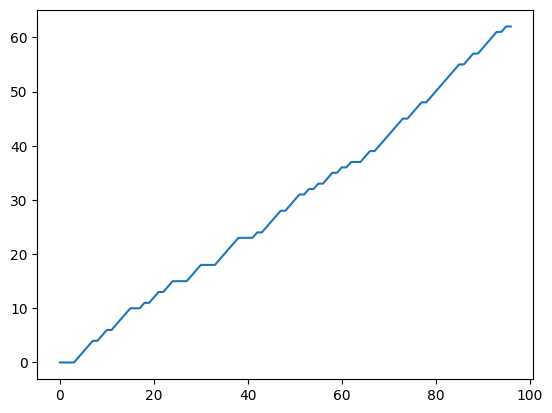

In [5]:

import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from itertools import cycle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def pre_process_data(file_name, print_yes = False, save_yes = False):
    positive_set = []
    negative_set = []
    negative_set_enemy = []
    positive_set_state = []
    negative_set_state = []
    negative_set_enemy_state = []
    with open(file_name, 'rb') as file:
        objects = []
        while True:
            try:
                obj = pickle.load(file)
                label = obj['label']
                objects.append(obj)
                V = obj['V']
                if label == 1:
                    negative_set.append(V)
                    negative_set_state.append(obj['state_expl_agent'])
                elif label == 2:
                    positive_set.append(V)
                    positive_set_state.append(obj['state_expl_agent'])
                else:
                    negative_set_enemy.append(V)
                    negative_set_enemy_state.append(obj['state_expl_agent'])
            except EOFError:
                break
    if print_yes:
        print(f'We have {len(objects)} data at {file_name}')
        print(f'Positive set: {len(positive_set)}')
        print(f'Negative set: {len(negative_set)}')
        print(f'Negative set enemy: {len(negative_set_enemy)}')

    if save_yes:
        torch.save(positive_set, 'positive_set_test.pth')
        torch.save(negative_set, 'negative_set_test.pth')
        torch.save(negative_set_enemy, 'negative_set_enemy_test.pth')
        torch.save(positive_set_state, 'positive_set_state_test.pth')
        torch.save(negative_set_state, 'negative_set_state_test.pth')
        torch.save(negative_set_enemy_state, 'negative_set_enemy_state_test.pth')

    return objects, positive_set, negative_set, negative_set_enemy, positive_set_state, negative_set_state, negative_set_enemy_state

def dimension_check(positive_set, negative_set, negative_set_enemy, positive_set_pretrain, negative_set_pretrain):
    positive_set_new = []
    negative_set_new = []
    negative_set_enemy_new = []
    positive_set_pretrain_new = []
    negative_set_pretrain_new = []

    for i in positive_set:
        positive_set_new.append([tensor.squeeze(0) for tensor in i])
    for i in negative_set:
        negative_set_new.append([tensor.squeeze(0) for tensor in i])
    for i in negative_set_enemy:
        negative_set_enemy_new.append([tensor.squeeze(0) for tensor in i])
    positive_set = positive_set_new
    negative_set = negative_set_new
    negative_set_enemy = negative_set_enemy_new

    for i in positive_set_pretrain:
        positive_set_pretrain_new.append([tensor.squeeze(0) for tensor in i])
    for i in negative_set_pretrain:
        negative_set_pretrain_new.append([tensor.squeeze(0) for tensor in i])
    positive_set_pretrain = positive_set_pretrain_new
    negative_set_pretrain = negative_set_pretrain_new

    return positive_set, negative_set, negative_set_enemy, positive_set_pretrain, negative_set_pretrain

def postitive_check(positive_state, postitive_set, key_word='pickup_key'):
    """
    Checks and removes positive samples that do not contain a specific keyword.

    Args:
        positive_state (list): The state of positive samples.
        postitive_set (list): The positive samples.
        key_word (str, optional): The keyword to check for. Defaults to 'pickup_key'.

    Returns:
        tuple: A tuple containing the updated positive state and positive set.
    """
    index = []
    for i in range(len(positive_state)):
        counter = 0
        for j in range(len(positive_state[i])):
            if key_word in positive_state[i][j][0]:
                counter += 1
        if counter == 0:
            index.append(i)
            # print('Index:', i)

    for idx in sorted(index, reverse=True):
        del positive_state[idx]
    for idx in sorted(index, reverse=True):
        del postitive_set[idx]

    return positive_state, postitive_set

def negative_check(negative_state, negative_set, key_word='pickup_key'):
    index = []
    for i in range(len(negative_state)):
        counter = 0
        for j in range(len(negative_state[i])):
            if key_word in negative_state[i][j][0]:
                counter += 1
        if counter > 0:
            index.append(i)
            # print('Index:', i)

    for idx in sorted(index, reverse=True):
        del negative_state[idx]
    for idx in sorted(index, reverse=True):
        del negative_set[idx]

    return negative_state, negative_set


def pretrain_pre_process(positive_state, postitive_set, key_word='pickup_key'):
    positive_state_new = []
    positive_set_new = []
    negative_state_new = []
    negative_set_new = []
    for i in range(len(positive_state)):
        for j in range(len(positive_state[i])):
            if key_word in positive_state[i][j][0]:
                positive_state_new.append(positive_state[i][j])
                positive_set_new.append(postitive_set[i][j])
            else:
                negative_state_new.append(positive_state[i][j])
                negative_set_new.append(postitive_set[i][j])

    return positive_state_new, positive_set_new, negative_state_new, negative_set_new



def postitive_check_length(positive_state, key_word='pickup_key'):
    """
    Checks the length of positive samples that contain a specific keyword.

    Args:
        positive_state (list): The state of positive samples.
        key_word (str, optional): The keyword to check for. Defaults to 'pickup_key'.
    """
    index = []
    for i in range(len(positive_state)):
        counter = 0
        for j in range(len(positive_state[i])):
            if key_word in positive_state[i][j][0]:
                counter += 1
        if counter == 0:
            index.append(i)
            # print('Index:', i)

    print('Length:', len(positive_state) - len(index))

    return
file_saved_before = True
# objects = pre_process_data('1.pkl', print_yes = True)
if not(file_saved_before):
    objects_full, positive_set, negative_set, negative_set_enemy, positive_set_state, negative_set_state, negative_set_enemy_state = pre_process_data('2.pkl', print_yes = True, save_yes= True)
else:
    positive_set = torch.load('positive_small.pth')
    negative_set = torch.load('negative_small.pth')
    negative_set_enemy = torch.load('negative_enemy_small.pth')
    positive_set_state = torch.load('positive_state_small.pth')
    negative_set_state = torch.load('negative_state_small.pth')
    negative_set_enemy_state = torch.load('negative_enemy_state_small.pth') # when you are running for the second time, just fix this typo in the name of the file





# objects_2 = pre_process_data('14.pkl', print_yes = True)
positive_set_state, positive_set = postitive_check(positive_set_state, positive_set, key_word = 'pickup_key')
# negative_set_state, negative_set = negative_check(negative_set_state, negative_set, key_word = 'pickup_key')
# negative_set_enemy_state, negative_set_enemy = negative_check(negative_set_enemy_state, negative_set_enemy, key_word = 'pickup_key')
print('HERE:',len(positive_set))
postitive_check_length(negative_set_state, key_word = 'pickup_key')
with open("output.txt", "w") as f:
    for i in range(len(positive_set_state)):
        list_of_strings = ["\n".join(arr) for arr in positive_set_state[i]]
        for line in list_of_strings:
            f.write(line )
        f.write("\nnew data \n")

print(f'Length of positive set: {len(positive_set)}')
print(f'Length of negative set: {len(negative_set)}')
print(f'Length of negative set enemy: {len(negative_set_enemy)}')
print(f'Length of positive set state: {len(positive_set_state)}')
print(f'Length of negative set state: {len(negative_set_state)}')
print(f'Length of negative set enemy state: {len(negative_set_enemy_state)}')
# Print all objects retrieved from the file
positive_state_pretrain, positive_set_pretrain, negative_state_pretrain, negative_set_pretrain = pretrain_pre_process(positive_set_state+negative_set_enemy_state+negative_set_state, positive_set+negative_set_enemy+negative_set, key_word = 'pickup_key')

print(f'Length of negative set state for pretrain: {len(negative_state_pretrain)}')
print(f'Length of positive set state for pretrain: {len(positive_state_pretrain)}')
print(f'len of positive set pretrain: {len(positive_set[0][0])}')
if len(positive_set[0][0]) == 1:
    positive_set, negative_set, negative_set_enemy, positive_set_pretrain, negative_set_pretrain = dimension_check(positive_set, negative_set, negative_set_enemy, positive_set_pretrain, negative_set_pretrain)


# Define the contrastive loss function
def positive_loss(z1):
    one = torch.ones(z1.size()).to(device)
    z1 = z1.to(device)
    # penalty = torch.abs(torch.abs(z1 - 0.5) - 0.5).mean()
    # print('Z!',z1.shape)
    return torch.nn.functional.mse_loss(z1,one) #+ penalty

def negative_loss(z1):
    one = torch.zeros(z1.size()).to(device)
    z1 = z1.to(device)
    # penalty = torch.abs(torch.abs(z1 - 0.5) - 0.5).mean()
    # print('Z!',z1.shape)
    return torch.nn.functional.mse_loss(z1,one) #+ penalty



def contrastive_loss_cross(z1, z2, tau=0.5):
    # print('Z1',z1[-2:], z2[-2:])
    min_size = min(z1.size(0), z2.size(0))
    tau = 2

    z1 = z1[:min_size].to(device)
    z2 = z2[:min_size].to(device)
    # penalty = torch.abs(torch.abs(z1 - 0.5) - 0.5).mean()+ torch.abs(torch.abs(z2 - 0.5) -0.5).mean()
    z1 = z1.sum(dim=1)
    lambda_ = 1/1e4
    # print('Z!',z1.shape, z2.shape)
    z2 = z2.sum(dim=1)
    max_1 = z1.max()
    max_2 = z2.max()

    # deifference_from_landmarks = torch.norm(torch.matmul(z1, z1.T), p =2)/torch.norm(z1,p=2)**2
    max_ = 0
    if max_1 > max_2:
        max_ = max_1
    else:
        max_ = max_2
    # if max_ > 10:


    # z1 = z1-max_
    # z2 = z2-max_

    criterion = nn.CrossEntropyLoss()
    pos_target = torch.zeros(z1.size(0)).long().to(device)
    Z = torch.cat((z1, z2), 1).float()
    score = criterion(Z, pos_target)
    print('HERE:',z1.mean(), z2.mean())

    return  score #-1*score + torch.abs(max_ - tau) #+ -1* deifference_from_landmarks#+ lambda_*penalty#+ lambda_ * z1.mean() + lambda_*z2.mean()



def load_model(filneame = 'contrastive_model_full.pth'):
    model = torch.load(filneame)
    return model
file_name_here = 'model_4.pth'
train_cont_model(positive_set[:50], negative_set_enemy+negative_set, training_step =2000, loss_func = contrastive_loss_cross, model = None, batch_size= 16, lr = 1e-3, save_name=file_name_here)
model = load_model(filneame = file_name_here)
idx = 4
l = []
counter = 0
with torch.no_grad():
    for i in range(len(positive_set)):
        output = model(torch.stack([tensor.squeeze(0) for tensor in positive_set[i]]).to(device))
        predicted_label = torch.argmax(output, dim=1)
        max_ = output.max()
        max_value, max_index = output.max(dim=0)
        print('max:', max_value, max_index)

        sorted_output, sorted_indices = torch.sort(output, descending=True)
        # print(sorted_indices)
        index = sorted_indices.squeeze().tolist()
        # print(index)
        if 'pickup_key' in positive_set_state[i][max_index.item()][0]:
            counter += 1
            l.append(1)
        else:
            l.append(0)
import matplotlib.pyplot as plt
plt.plot(np.cumsum(np.array(l)))
plt.show()


30


<ipython-input-13-35505e072d34>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem('test on 50 data',np.cumsum(np.array(l))[-1] - np.cumsum(np.array(l))[50], use_line_collection=True)


<StemContainer object of 3 artists>

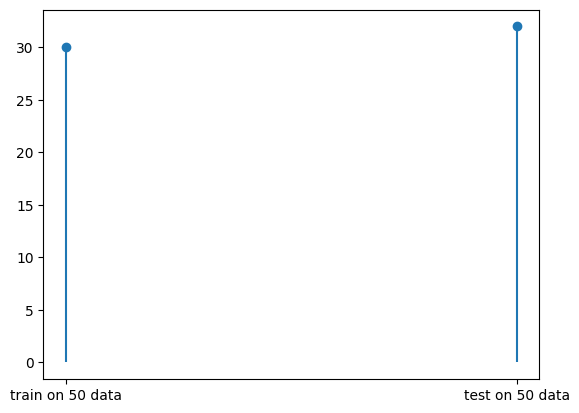

In [13]:
print(np.cumsum(np.array(l))[50])
plt.stem('train on 50 data',np.cumsum(np.array(l))[50])
plt.stem('test on 50 data',np.cumsum(np.array(l))[-1] - np.cumsum(np.array(l))[50], use_line_collection=True)
# plt.show()